## Feature Engineering Notebook:

Arun Agarwal

In [0]:
%pip install graphframes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/154.7 kB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
from pyspark.sql.types import DoubleType, IntegerType, StringType, DateType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import (
    col, when, hour, month, dayofweek, count, sum as spark_sum, datediff, concat_ws, min as spark_min, max as spark_max, broadcast,
    broadcast, stddev, to_date, lit, coalesce, expr, avg, round as spark_round, log, unix_timestamp, lag, sin, cos, radians,
    regexp_replace, countDistinct
)
import holidays
from datetime import datetime, timedelta
from collections import Counter
import math
from graphframes import GraphFrame
import io
import base64
from IPython.display import display, HTML
from scipy import stats
from pyspark.ml.feature import VectorAssembler, StandardScaler, ChiSqSelector, MinMaxScaler
from pyspark.ml import Pipeline
import numpy as np


### Data Description:
This notebook works directly off the joined cleaned dataset for 1 Year data created in the Data Cleaning Notebook for 1Y.

### Load Data:

In [0]:
joined_BASE_DIR = "dbfs:/student-groups/Group_4_4/"
display(dbutils.fs.ls(f"{joined_BASE_DIR}/"))

[FileInfo(path='dbfs:/student-groups/Group_4_4/Charts/', name='Charts/', size=0, modificationTime=1763690575472),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_1Y_2019.parquet/', name='JOINED_1Y_2019.parquet/', size=0, modificationTime=1763690575472),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_3M_2015.parquet/', name='JOINED_3M_2015.parquet/', size=0, modificationTime=1763690575472),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_5Y_2015_2019.parquet/', name='JOINED_5Y_2015_2019.parquet/', size=0, modificationTime=1763690575472),
 FileInfo(path='dbfs:/student-groups/Group_4_4/_checkpoints/', name='_checkpoints/', size=0, modificationTime=1763690575472),
 FileInfo(path='dbfs:/student-groups/Group_4_4/airport-zones.csv', name='airport-zones.csv', size=1067908, modificationTime=1763490667000),
 FileInfo(path='dbfs:/student-groups/Group_4_4/appendix_b_column_classification_final.csv', name='appendix_b_column_classification_final.csv', size=7349, modificationTime=1

In [0]:
# Load the pre-joined cleaned dataset (already has flights + origin weather + geo data)
df_features = spark.read.parquet("dbfs:/student-groups/Group_4_4/joined_1Y_final_clean.parquet")

print("Loaded pre-joined dataset")
print(f"Num rows: {df_features.count():,}")
print(f"Num cols: {len(df_features.columns)}")
df_features.printSchema()

Loaded pre-joined dataset
Num rows: 7,258,941
Num cols: 59
root
 |-- flight_id: string (nullable = true)
 |-- prediction_utc: timestamp (nullable = true)
 |-- origin_obs_utc: timestamp (nullable = true)
 |-- asof_minutes: long (nullable = true)
 |-- origin_station_id: string (nullable = true)
 |-- dest_station_id: string (nullable = true)
 |-- FL_DATE: date (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- TAIL_NUM: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN

In [0]:
# Cache for performance
df_features.cache()
print("✓ Dataset cached for feature engineering")

✓ Dataset cached for feature engineering


### 1. Extract Temporal Features:

In [0]:
print("\n=== Step 1: Extracting Temporal Features ===\n")

# Use prediction_utc (T-2h) for feature extraction
# This is the timestamp we're making predictions at
df_features = df_features.withColumn("departure_hour", hour(col("prediction_utc")))
df_features = df_features.withColumn("departure_month", month(col("prediction_utc")))
df_features = df_features.withColumn("departure_dayofweek", dayofweek(col("prediction_utc")))

# Create weekend indicator (Saturday=7, Sunday=1 in Spark)
df_features = df_features.withColumn(
    "is_weekend", 
    when((col("departure_dayofweek") == 1) | (col("departure_dayofweek") == 7), 1).otherwise(0)
)

# Create season indicator
df_features = df_features.withColumn(
    "season",
    when(col("departure_month").isin([12, 1, 2]), "Winter")
    .when(col("departure_month").isin([3, 4, 5]), "Spring")
    .when(col("departure_month").isin([6, 7, 8]), "Summer")
    .otherwise("Fall")
)

# Create peak hour indicator (6-9 AM and 5-8 PM)
df_features = df_features.withColumn(
    "is_peak_hour",
    when((col("departure_hour").between(6, 9)) | (col("departure_hour").between(17, 20)), 1).otherwise(0)
)

# Peak travel month (June, July, August, December)
df_features = df_features.withColumn(
    "is_peak_month", 
    when(col("MONTH").isin([6, 7, 8, 12]), 1).otherwise(0)
)

df_features = df_features.withColumn(
    "time_of_day_early_morning", 
    when(col("departure_hour").between(5, 8), 1).otherwise(0)
)
df_features = df_features.withColumn(
    "time_of_day_morning", 
    when(col("departure_hour").between(9, 11), 1).otherwise(0)
)
df_features = df_features.withColumn(
    "time_of_day_afternoon", 
    when(col("departure_hour").between(12, 17), 1).otherwise(0)
)
df_features = df_features.withColumn(
    "time_of_day_evening", 
    when(col("departure_hour").between(18, 22), 1).otherwise(0)
)
df_features = df_features.withColumn(
    "time_of_day_night", 
    when((col("departure_hour") < 5) | (col("departure_hour") > 22), 1).otherwise(0)
)

print("✓ Created 5 time-of-day binary indicators:")
print("  - time_of_day_early_morning (5-8am)")
print("  - time_of_day_morning (9-11am)")
print("  - time_of_day_afternoon (12-5pm)")
print("  - time_of_day_evening (6-10pm)")
print("  - time_of_day_night (<5am or >10pm)")

print("\nTime of day distribution:")
df_features.select(
    F.sum("time_of_day_early_morning").alias("Early Morning"),
    F.sum("time_of_day_morning").alias("Morning"),
    F.sum("time_of_day_afternoon").alias("Afternoon"),
    F.sum("time_of_day_evening").alias("Evening"),
    F.sum("time_of_day_night").alias("Night")
).show()



print("✓ Temporal features created:")
print("  - departure_hour (0-23)")
print("  - departure_month (1-12)")  
print("  - departure_dayofweek (1-7)")
print("  - is_weekend (0/1)")
print("  - season (Winter/Spring/Summer/Fall)")
print("  - is_peak_hour (0/1)")
print("  - is_peak_month (0/1)")

# Show sample
print("\nSample temporal features:")
df_features.select(
    "prediction_utc", "departure_hour", "departure_month", 
    "is_weekend", "season", "is_peak_hour", "is_peak_month"
).show(5, truncate=False)


=== Step 1: Extracting Temporal Features ===

✓ Created 5 time-of-day binary indicators:
  - time_of_day_early_morning (5-8am)
  - time_of_day_morning (9-11am)
  - time_of_day_afternoon (12-5pm)
  - time_of_day_evening (6-10pm)
  - time_of_day_night (<5am or >10pm)

Time of day distribution:
+-------------+-------+---------+-------+------+
|Early Morning|Morning|Afternoon|Evening| Night|
+-------------+-------+---------+-------+------+
|       315907|1200113|  2639345|2145006|958570|
+-------------+-------+---------+-------+------+

✓ Temporal features created:
  - departure_hour (0-23)
  - departure_month (1-12)
  - departure_dayofweek (1-7)
  - is_weekend (0/1)
  - season (Winter/Spring/Summer/Fall)
  - is_peak_hour (0/1)
  - is_peak_month (0/1)

Sample temporal features:
+-------------------+--------------+---------------+----------+------+------------+-------------+
|prediction_utc     |departure_hour|departure_month|is_weekend|season|is_peak_hour|is_peak_month|
+-----------------

### 2. Create Target Helper Variable (For Rolling Features Only):

In [0]:
print("\n=== Step 2: Creating Helper Variables ===\n")

# IMPORTANT: This is ONLY for calculating rolling features
# It will NOT be used in the final model (it's leakage)
# We'll drop it later
df_features = df_features.withColumn(
    "is_delayed_helper", 
    when(col("DEP_DEL15") == 1, 1).otherwise(0)
)

print("✓ Created is_delayed_helper (will be dropped before modeling)")
print("  Note: Used only to calculate rolling delay statistics")


=== Step 2: Creating Helper Variables ===

✓ Created is_delayed_helper (will be dropped before modeling)
  Note: Used only to calculate rolling delay statistics


### 3. Daily Flight Volume by Origin:

In [0]:
print("\n=== Step 3: Calculating Daily Flight Volume ===\n")

# Calculate total flights per origin per day
daily_origin_flight_counts = (
    df_features
    .groupBy("ORIGIN", "FL_DATE")
    .agg(count("*").alias("total_flights_per_origin_day"))
)

# Join back to main dataframe
df_features = df_features.join(
    daily_origin_flight_counts,
    on=["ORIGIN", "FL_DATE"],
    how="left"
)

print("✓ Added total_flights_per_origin_day")

# Check for nulls
null_count = df_features.filter(col("total_flights_per_origin_day").isNull()).count()
if null_count > 0:
    print(f"Warning: {null_count} rows with null daily flight counts")
else:
    print("✓ No nulls in daily flight counts")


=== Step 3: Calculating Daily Flight Volume ===

✓ Added total_flights_per_origin_day
✓ No nulls in daily flight counts


### 4. Rolling Features (24h Window):

In [0]:
print("=== 4.2: Defining Rolling Windows ===\n")

# Window 1: General rolling features (24h to 2h before prediction)
rolling_window_general = (Window
    .partitionBy("ORIGIN")
    .orderBy(F.col("prediction_utc").cast("long"))
    .rangeBetween(-86400, -7200)  # -24h to -2h (exclude recent 2 hours)
)

# Window 2: Rolling averages (24h to 100s before prediction)
rolling_window_avg = (Window
    .partitionBy("ORIGIN")
    .orderBy(F.col("prediction_utc").cast("long"))
    .rangeBetween(-86400, -100)  # -24h to -100s (tighter exclusion)
)

# Window 3: By origin + carrier
rolling_window_origin_carrier = (Window
    .partitionBy("ORIGIN", "OP_UNIQUE_CARRIER")
    .orderBy(F.col("prediction_utc").cast("long"))
    .rangeBetween(-86400, -100)
)

# Window 4: By origin + day of week
rolling_window_origin_dow = (Window
    .partitionBy("ORIGIN", "DAY_OF_WEEK")
    .orderBy(F.col("prediction_utc").cast("long"))
    .rangeBetween(-86400, -100)
)

print("✓ Defined 4 rolling windows:")
print("  1. General: -24h to -2h by ORIGIN")
print("  2. Averages: -24h to -100s by ORIGIN")
print("  3. Carrier-specific: -24h to -100s by ORIGIN + CARRIER")
print("  4. Day-specific: -24h to -100s by ORIGIN + DAY_OF_WEEK\n")

#### 4.3: Create General Rolling Features (Counts, Ratios, Stddev):

print("=== 4.3: Creating General Rolling Features ===\n")

print("Calculating rolling flight counts, delay counts, and ratios...")
df_features = df_features \
    .withColumn("rolling_origin_num_flights_24h", 
                F.count("*").over(rolling_window_general)) \
    .withColumn("rolling_origin_num_delays_24h", 
                F.sum("is_delayed_helper").over(rolling_window_general)) \
    .withColumn("rolling_origin_delay_ratio_24h", 
                F.when(F.col("rolling_origin_num_flights_24h") > 0, 
                       F.col("rolling_origin_num_delays_24h") / F.col("rolling_origin_num_flights_24h"))
                 .otherwise(0)) \
    .withColumn("rolling_origin_stddev_dep_delay_24h", 
                F.stddev("DEP_DEL15").over(rolling_window_general))

print("✓ Created 4 general rolling features:")
print("  - rolling_origin_num_flights_24h")
print("  - rolling_origin_num_delays_24h")
print("  - rolling_origin_delay_ratio_24h")
print("  - rolling_origin_stddev_dep_delay_24h\n")

#### 4.4: Create Rolling Average Features (By Origin, Carrier, Day):

print("=== 4.4: Creating Rolling Average Features ===\n")

# 1. By ORIGIN only
print("Calculating rolling average by ORIGIN...")
df_features = df_features.withColumn(
    "dep_delay15_24h_rolling_avg_by_origin", 
    F.avg(F.col("DEP_DEL15")).over(rolling_window_avg)
)
print("✓ Created dep_delay15_24h_rolling_avg_by_origin")

# 2. By ORIGIN + CARRIER
print("Calculating rolling average by ORIGIN + CARRIER...")
df_features = df_features.withColumn(
    "dep_delay15_24h_rolling_avg_by_origin_carrier", 
    F.avg(F.col("DEP_DEL15")).over(rolling_window_origin_carrier)
)
print("✓ Created dep_delay15_24h_rolling_avg_by_origin_carrier")

# 3. By ORIGIN + DAY_OF_WEEK
print("Calculating rolling average by ORIGIN + DAY_OF_WEEK...")
df_features = df_features.withColumn(
    "dep_delay15_24h_rolling_avg_by_origin_dayofweek", 
    F.avg(F.col("DEP_DEL15")).over(rolling_window_origin_dow)
)
print("✓ Created dep_delay15_24h_rolling_avg_by_origin_dayofweek\n")


#### 4.5: Impute Missing Values in Rolling Features:

print("=== 4.5: Imputing Missing Values ===\n")

# For general rolling features: Use medians
print("Calculating medians for general rolling features...")
rolling_origin_medians = df_features.select(
    F.expr('percentile_approx(rolling_origin_num_flights_24h, 0.5)').alias('median_num_flights'),
    F.expr('percentile_approx(rolling_origin_num_delays_24h, 0.5)').alias('median_num_delays'),
    F.expr('percentile_approx(rolling_origin_delay_ratio_24h, 0.5)').alias('median_delay_ratio'),
    F.expr('percentile_approx(rolling_origin_stddev_dep_delay_24h, 0.5)').alias('median_stddev_dep_delay')
).first()

print(f"  Median num flights: {rolling_origin_medians['median_num_flights']}")
print(f"  Median num delays: {rolling_origin_medians['median_num_delays']}")
print(f"  Median delay ratio: {rolling_origin_medians['median_delay_ratio']:.4f}")
print(f"  Median stddev delay: {rolling_origin_medians['median_stddev_dep_delay']:.4f}")

# Fill general rolling features with medians
df_features = df_features.fillna({
    "rolling_origin_num_flights_24h": rolling_origin_medians["median_num_flights"],
    "rolling_origin_num_delays_24h": rolling_origin_medians["median_num_delays"],
    "rolling_origin_delay_ratio_24h": rolling_origin_medians["median_delay_ratio"],
    "rolling_origin_stddev_dep_delay_24h": rolling_origin_medians["median_stddev_dep_delay"]
})

print("✓ General rolling features imputed with medians\n")

# For rolling averages: Use airport-level averages
print("Filling rolling average features with airport-level averages...")
df_features = df_features.withColumn(
    "dep_delay15_24h_rolling_avg_by_origin",
    coalesce(
        col("dep_delay15_24h_rolling_avg_by_origin"),
        avg("DEP_DEL15").over(Window.partitionBy("ORIGIN"))
    )
).withColumn(
    "dep_delay15_24h_rolling_avg_by_origin_carrier",
    coalesce(
        col("dep_delay15_24h_rolling_avg_by_origin_carrier"),
        avg("DEP_DEL15").over(Window.partitionBy("ORIGIN"))
    )
).withColumn(
    "dep_delay15_24h_rolling_avg_by_origin_dayofweek",
    coalesce(
        col("dep_delay15_24h_rolling_avg_by_origin_dayofweek"),
        avg("DEP_DEL15").over(Window.partitionBy("ORIGIN"))
    )
)

print("✓ Rolling average features imputed with airport-level averages\n")

#### 4.6: Verify No Nulls & Drop Helper Variable:

print("=== 4.6: Verification & Cleanup ===\n")

# Verify no nulls remain in rolling features
all_rolling_features = [
    "rolling_origin_num_flights_24h",
    "rolling_origin_num_delays_24h",
    "rolling_origin_delay_ratio_24h",
    "rolling_origin_stddev_dep_delay_24h",
    "dep_delay15_24h_rolling_avg_by_origin",
    "dep_delay15_24h_rolling_avg_by_origin_carrier",
    "dep_delay15_24h_rolling_avg_by_origin_dayofweek"
]

print("Verifying no nulls in rolling features:")
null_found = False
for feat in all_rolling_features:
    null_count = df_features.filter(col(feat).isNull()).count()
    if null_count > 0:
        print(f" {feat}: {null_count:,} nulls")
        null_found = True
    else:
        print(f"  ✓ {feat}: no nulls")

if not null_found:
    print("\n✓ All rolling features have no nulls")

# Drop helper variable
print("\nDropping temporary helper variable...")
df_features = df_features.drop("is_delayed_helper")
print("✓ Dropped is_delayed_helper (no longer needed)\n")

#### 4.7: Display Sample Rolling Features:

print("=== 4.7: Sample Rolling Features ===\n")

# Show sample of all rolling features
df_features.select(
    "ORIGIN", "prediction_utc", "DAY_OF_WEEK",
    "rolling_origin_num_flights_24h",
    "rolling_origin_delay_ratio_24h",
    "dep_delay15_24h_rolling_avg_by_origin",
    "dep_delay15_24h_rolling_avg_by_origin_carrier",
    "dep_delay15_24h_rolling_avg_by_origin_dayofweek"
).show(10, truncate=False)

# Summary statistics
print("\nRolling Feature Summary Statistics:")
df_features.select(all_rolling_features).summary("min", "25%", "50%", "75%", "max").show()

print("\n" + "=" * 80)
print("ROLLING FEATURES COMPLETE!")
print("=" * 80)
print(f"✓ Created {len(all_rolling_features)} rolling features")
print("✓ All nulls imputed")
print("✓ Helper variable removed")
print("=" * 80 + "\n")

=== 4.2: Defining Rolling Windows ===

✓ Defined 4 rolling windows:
  1. General: -24h to -2h by ORIGIN
  2. Averages: -24h to -100s by ORIGIN
  3. Carrier-specific: -24h to -100s by ORIGIN + CARRIER
  4. Day-specific: -24h to -100s by ORIGIN + DAY_OF_WEEK

=== 4.3: Creating General Rolling Features ===

Calculating rolling flight counts, delay counts, and ratios...
✓ Created 4 general rolling features:
  - rolling_origin_num_flights_24h
  - rolling_origin_num_delays_24h
  - rolling_origin_delay_ratio_24h
  - rolling_origin_stddev_dep_delay_24h

=== 4.4: Creating Rolling Average Features ===

Calculating rolling average by ORIGIN...
✓ Created dep_delay15_24h_rolling_avg_by_origin
Calculating rolling average by ORIGIN + CARRIER...
✓ Created dep_delay15_24h_rolling_avg_by_origin_carrier
Calculating rolling average by ORIGIN + DAY_OF_WEEK...
✓ Created dep_delay15_24h_rolling_avg_by_origin_dayofweek

=== 4.5: Imputing Missing Values ===

Calculating medians for general rolling features...


### 5. Holiday Window Feature:

In [0]:
print("\n=== Step 5: Creating Holiday Window Feature ===\n")

# Check if is_holiday_window already exists
if "is_holiday_window" in df_features.columns:
    print("is_holiday_window already exists - dropping old version...")
    df_features = df_features.drop("is_holiday_window")

# Generate US holidays for 2019
us_holidays = holidays.UnitedStates(years=2019)

# Extract dates as strings
us_holiday_dates = [date.strftime("%Y-%m-%d") for date in us_holidays.keys()]
print(f"Found {len(us_holiday_dates)} US holidays in 2019")

# Add buffer days +/- 3 days around each holiday
holiday_buffer = []
for h in us_holiday_dates:
    dt = datetime.strptime(h, "%Y-%m-%d")
    for delta in range(-3, 4):
        buffer_day = (dt + timedelta(days=delta)).strftime("%Y-%m-%d")
        holiday_buffer.append(buffer_day)

# Remove duplicates
holiday_buffer_unique = list(set(holiday_buffer))
print(f"Total days in holiday window (including ±3 day buffer): {len(holiday_buffer_unique)}")

# Create Spark DataFrame
holiday_df = spark.createDataFrame(
    [(d,) for d in holiday_buffer_unique], 
    ["holiday_date"]
)
holiday_df = holiday_df.withColumn(
    "holiday_date", 
    to_date(col("holiday_date"), "yyyy-MM-dd")
)

# Ensure FL_DATE is in date format
if dict(df_features.dtypes)["FL_DATE"] != "date":
    print("Converting FL_DATE to date type...")
    df_features = df_features.withColumn("FL_DATE", col("FL_DATE").cast(DateType()))

# Join holiday buffer dataframe
# Use explicit column selection to avoid ambiguous references
print("Joining holiday data...")
df_features = df_features.join(
    holiday_df.select(
        col("holiday_date"),
        lit(1).alias("is_holiday_window_flag")  # Use temporary name
    ),
    df_features["FL_DATE"] == holiday_df["holiday_date"],
    how="left"
)

# Rename and clean up
df_features = df_features \
    .withColumn("is_holiday_window", 
                coalesce(col("is_holiday_window_flag"), lit(0))) \
    .drop("holiday_date", "is_holiday_window_flag")

# Verify
holiday_count = df_features.filter(col("is_holiday_window") == 1).count()
total_count = df_features.count()
print(f"\n✓ Created is_holiday_window feature")
print(f"  Flights in holiday window: {holiday_count:,} ({holiday_count/total_count*100:.2f}%)")
print(f"  Flights not in holiday window: {total_count - holiday_count:,}")

# Sanity check - should be 0 or 1 only
print("\nValue distribution:")
df_features.groupBy("is_holiday_window").count().orderBy("is_holiday_window").show()


=== Step 5: Creating Holiday Window Feature ===

Found 10 US holidays in 2019
Total days in holiday window (including ±3 day buffer): 70
Joining holiday data...

✓ Created is_holiday_window feature
  Flights in holiday window: 1,282,729 (17.67%)
  Flights not in holiday window: 5,976,212

Value distribution:
+-----------------+-------+
|is_holiday_window|  count|
+-----------------+-------+
|                0|5976212|
|                1|1282729|
+-----------------+-------+



### 6. Weather Severity & Distance Features:

In [0]:
print("\n=== Step 6: Creating Weather & Distance Features ===\n")

# Weather Severity Index
df_features = df_features.withColumn(
    "weather_severity_index",
    coalesce(col("HourlyWindSpeed"), lit(0)) + 
    coalesce(col("HourlyPrecipitation"), lit(0)) * 10 +
    (10 - coalesce(col("HourlyVisibility"), lit(10)))
)

df_features = df_features.withColumn(
    "distance_short", 
    when(col("DISTANCE") < 500, 1).otherwise(0)
)
df_features = df_features.withColumn(
    "distance_medium", 
    when(col("DISTANCE").between(500, 1000), 1).otherwise(0)
)
df_features = df_features.withColumn(
    "distance_long", 
    when(col("DISTANCE").between(1000, 2000), 1).otherwise(0)
)
df_features = df_features.withColumn(
    "distance_very_long", 
    when(col("DISTANCE") > 2000, 1).otherwise(0)
)

print("✓ Created 4 distance binary indicators:")
print("  - distance_short (<500 mi)")
print("  - distance_medium (500-1000 mi)")
print("  - distance_long (1000-2000 mi)")
print("  - distance_very_long (>2000 mi)")

print("\nDistance distribution:")
df_features.select(
    F.sum("distance_short").alias("Short"),
    F.sum("distance_medium").alias("Medium"),
    F.sum("distance_long").alias("Long"),
    F.sum("distance_very_long").alias("Very Long")
).show()

print("✓ Created weather_severity_index")
print("  Formula: wind_speed + precipitation*10 + (10-visibility)")
print("✓ Created distance_category (Short<500, Medium<1500, Long≥1500 miles)")

print("\nWeather severity statistics:")
df_features.select("weather_severity_index").summary("min", "25%", "50%", "75%", "max").show()

df_features = df_features.withColumn(
    "weather_condition_category",
    when(
        (coalesce(col("HourlyVisibility"), lit(10)) < 3) |
        (coalesce(col("HourlyWindSpeed"), lit(0)) > 25) |
        (coalesce(col("HourlyPrecipitation"), lit(0)) > 0.5),
        "Severe"
    ).when(
        (coalesce(col("HourlyVisibility"), lit(10)) < 7) |
        (coalesce(col("HourlyWindSpeed"), lit(0)) > 15) |
        (coalesce(col("HourlyPrecipitation"), lit(0)) > 0.1),
        "Moderate"
    ).otherwise("Clear")
)

print("✓ Created weather_condition_category (Severe/Moderate/Clear)")
print("\nCriteria:")
print("  Severe: Visibility < 3mi OR Wind > 25mph OR Precip > 0.5in")
print("  Moderate: Visibility < 7mi OR Wind > 15mph OR Precip > 0.1in")
print("  Clear: Otherwise")

print("\nWeather condition distribution:")
df_features.groupBy("weather_condition_category").count().orderBy("weather_condition_category").show()


=== Step 6: Creating Weather & Distance Features ===

✓ Created 4 distance binary indicators:
  - distance_short (<500 mi)
  - distance_medium (500-1000 mi)
  - distance_long (1000-2000 mi)
  - distance_very_long (>2000 mi)

Distance distribution:
+-------+-------+-------+---------+
|  Short| Medium|   Long|Very Long|
+-------+-------+-------+---------+
|2727743|2572349|1525430|   433419|
+-------+-------+-------+---------+

✓ Created weather_severity_index
  Formula: wind_speed + precipitation*10 + (10-visibility)
✓ Created distance_category (Short<500, Medium<1500, Long≥1500 miles)

Weather severity statistics:
+-------+----------------------+
|summary|weather_severity_index|
+-------+----------------------+
|    min|                 -76.0|
|    25%|                   6.0|
|    50%|                   9.0|
|    75%|                  13.0|
|    max|    2244.6642857142856|
+-------+----------------------+

✓ Created weather_condition_category (Severe/Moderate/Clear)

Criteria:
  Severe

### 7. Drop Helper Variables & Leakage:

In [0]:
print("\n=== Step 7: Removing Helper Variables ===\n")

# Drop the helper variable used for rolling features
df_features = df_features.drop("is_delayed_helper")
print("✓ Dropped is_delayed_helper (was only for calculating rolling features)")

# Verify no leakage features remain
leakage_check = [
    "DEP_DELAY", "ARR_DELAY", "DEP_TIME", "ARR_TIME",
    "TAXI_OUT", "TAXI_IN", "WHEELS_OFF", "WHEELS_ON",
    "is_delayed_helper"
]

remaining_leakage = [col for col in leakage_check if col in df_features.columns]
if remaining_leakage:
    print(f"WARNING: Leakage features still present: {remaining_leakage}")
else:
    print("✓ No leakage features detected")



=== Step 7: Removing Helper Variables ===

✓ Dropped is_delayed_helper (was only for calculating rolling features)
✓ No leakage features detected


### 8. Remove Redundant & Problematic Features:

In [0]:
print("\n=== Step 8: Feature Cleanup ===\n")

# Features to remove
features_to_remove = [
    # ID columns (redundant with categorical versions)
    'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 
    'DEST_AIRPORT_ID',
    
    # Geographic coordinates (keep ORIGIN/DEST codes instead)
    'origin_station_lat', 'origin_station_lon', 
    'origin_airport_lat', 'origin_airport_lon',
    'dest_station_lat', 'dest_station_lon', 
    'dest_airport_lat', 'dest_airport_lon',
    'origin_station_dis', 'dest_station_dis',
    
    # Redundant location info
    'ORIGIN_CITY_NAME', 'DEST_CITY_NAME',
    
    # Station IDs (metadata)
    'origin_station_id', 'dest_station_id',
    
    # Time variables (keep engineered features instead)
    'CRS_ARR_TIME',  # Keep CRS_DEP_TIME for now
    
    # Metadata
    'HourlySkyConditions', 'HourlyPresentWeatherType'  # Text fields
]

# Filter to only existing columns
existing_to_remove = [f for f in features_to_remove if f in df_features.columns]

print(f"Removing {len(existing_to_remove)} redundant/problematic features:")
for feature in existing_to_remove:
    print(f"  - {feature}")

df_clean = df_features.drop(*existing_to_remove)

print(f"\n Dataset shape: {len(df_features.columns)} → {len(df_clean.columns)} columns")


=== Step 8: Feature Cleanup ===

Removing 20 redundant/problematic features:
  - OP_CARRIER_FL_NUM
  - ORIGIN_AIRPORT_ID
  - DEST_AIRPORT_ID
  - origin_station_lat
  - origin_station_lon
  - origin_airport_lat
  - origin_airport_lon
  - dest_station_lat
  - dest_station_lon
  - dest_airport_lat
  - dest_airport_lon
  - origin_station_dis
  - dest_station_dis
  - ORIGIN_CITY_NAME
  - DEST_CITY_NAME
  - origin_station_id
  - dest_station_id
  - CRS_ARR_TIME
  - HourlySkyConditions
  - HourlyPresentWeatherType

 Dataset shape: 86 → 66 columns


### 9. Airport Hourly Traffic Density:

In [0]:
print("\n=== Step 1: Airport Hourly Traffic Density ===\n")
print("This measures congestion at the airport during specific hours")

# Calculate total daily departures per airport
print("Calculating daily departures by airport...")
daily_traffic = df_features.groupBy("ORIGIN", "FL_DATE").agg(
    F.count("*").alias("daily_departures")
)

# Calculate hourly departures per airport-hour
print("Calculating hourly departures by airport...")
hourly_traffic = df_features.groupBy("ORIGIN", "FL_DATE", "departure_hour").agg(
    F.count("*").alias("hourly_departures")
)

# Join back to get traffic density ratio
df_features = df_features.join(
    daily_traffic, 
    on=["ORIGIN", "FL_DATE"], 
    how="left"
).join(
    hourly_traffic,
    on=["ORIGIN", "FL_DATE", "departure_hour"],
    how="left"
).withColumn(
    "airport_traffic_density",
    col("hourly_departures") / (col("daily_departures") + 1)  # +1 to avoid division by zero
).drop("daily_departures", "hourly_departures")

print("✓ Created airport_traffic_density")
print("  Represents: % of daily flights departing in this hour")

# Show distribution
print("\nTraffic density statistics:")
df_features.select("airport_traffic_density").summary("min", "25%", "50%", "75%", "max").show()


=== Step 1: Airport Hourly Traffic Density ===

This measures congestion at the airport during specific hours
Calculating daily departures by airport...
Calculating hourly departures by airport...
✓ Created airport_traffic_density
  Represents: % of daily flights departing in this hour

Traffic density statistics:
+-------+-----------------------+
|summary|airport_traffic_density|
+-------+-----------------------+
|    min|   8.726003490401396E-4|
|    25%|   0.052361396303901436|
|    50%|     0.0673076923076923|
|    75%|    0.08771929824561403|
|    max|                    0.8|
+-------+-----------------------+



### 10. Carrier-Level Flight Frequency:

In [0]:
print("\n=== Step 3: Carrier Flight Frequency ===\n")
print("Counts total flights per carrier (measure of carrier size/activity)")

# Count flights per carrier across entire dataset
window_spec = Window.partitionBy("OP_UNIQUE_CARRIER")
df_features = df_features.withColumn(
    "carrier_flight_count", 
    F.count("OP_UNIQUE_CARRIER").over(window_spec)
)

print("✓ Created carrier_flight_count")
print("  Represents: Total flights operated by this carrier in dataset")

# Show top carriers
print("\nTop 10 carriers by flight count:")
df_features.select("OP_UNIQUE_CARRIER", "carrier_flight_count") \
    .distinct() \
    .orderBy(col("carrier_flight_count").desc()) \
    .show(10)


=== Step 3: Carrier Flight Frequency ===

Counts total flights per carrier (measure of carrier size/activity)
✓ Created carrier_flight_count
  Represents: Total flights operated by this carrier in dataset

Top 10 carriers by flight count:
+-----------------+--------------------+
|OP_UNIQUE_CARRIER|carrier_flight_count|
+-----------------+--------------------+
|               WN|             1327434|
|               DL|              987950|
|               AA|              924106|
|               OO|              812827|
|               UA|              618097|
|               YX|              320614|
|               MQ|              314648|
|               B6|              289225|
|               OH|              281637|
|               AS|              260999|
+-----------------+--------------------+
only showing top 10 rows


In [0]:
df_features = df_features.withColumn(
    "weather_obs_lag_hours",
    spark_round(col("asof_minutes") / 60.0, 2)
)

print("✓ Created weather_obs_lag_hours")
print("  Represents: Hours between weather observation and prediction time")

# Show distribution
print("\nWeather observation lag distribution:")
df_features.select("weather_obs_lag_hours").summary("min", "25%", "50%", "75%", "max").show()

# Sanity check - should be mostly around 2 hours (our T-2h prediction window)
print("\nExpected: Most values ~2 hours (our prediction window)")

✓ Created weather_obs_lag_hours
  Represents: Hours between weather observation and prediction time

Weather observation lag distribution:
+-------+---------------------+
|summary|weather_obs_lag_hours|
+-------+---------------------+
|    min|                  0.0|
|    25%|                 0.15|
|    50%|                 0.42|
|    75%|                 0.67|
|    max|                  6.0|
+-------+---------------------+


Expected: Most values ~2 hours (our prediction window)


### 11. Log-Transformed Distance:

In [0]:
print("\n=== Step 2: Log-Transformed Distance ===\n")
print("Log transformation helps with right-skewed distance distribution")

# Check if distance is right-skewed
print("Original distance distribution:")
df_features.select("DISTANCE").summary("min", "25%", "50%", "75%", "max").show()

# Create log-transformed distance
df_features = df_features.withColumn(
    "log_distance", 
    log(col("DISTANCE") + 1)  # +1 to handle any potential zeros
)

print("✓ Created log_distance")
print("  Formula: log(DISTANCE + 1)")

# Show log-transformed distribution
print("\nLog-transformed distance distribution:")
df_features.select("log_distance").summary("min", "25%", "50%", "75%", "max").show()

# Visualize comparison
print("\nDistance transformation comparison (sample):")
df_features.select(
    "DISTANCE",
    "log_distance",
    "distance_long", "distance_short", "distance_medium", "distance_very_long"
).show(10)


=== Step 2: Log-Transformed Distance ===

Log transformation helps with right-skewed distance distribution
Original distance distribution:
+-------+--------+
|summary|DISTANCE|
+-------+--------+
|    min|    31.0|
|    25%|   369.0|
|    50%|   641.0|
|    75%|  1034.0|
|    max|  5095.0|
+-------+--------+

✓ Created log_distance
  Formula: log(DISTANCE + 1)

Log-transformed distance distribution:
+-------+------------------+
|summary|      log_distance|
+-------+------------------+
|    min|3.4657359027997265|
|    25%|  5.91350300563827|
|    50%| 6.464588303689961|
|    75%| 6.942156705699469|
|    max|    8.536211197252|
+-------+------------------+


Distance transformation comparison (sample):
+--------+-----------------+-------------+--------------+---------------+------------------+
|DISTANCE|     log_distance|distance_long|distance_short|distance_medium|distance_very_long|
+--------+-----------------+-------------+--------------+---------------+------------------+
|   519.0

### 12. Binary Rain Indicator:

In [0]:
print("Simple indicator: 1 if any precipitation, 0 otherwise")

# Create binary rain indicator
df_features = df_features.withColumn(
    "is_rainy",
    when(col("HourlyPrecipitation") > 0, 1).otherwise(0)
)

print("✓ Created is_rainy (1 if precipitation > 0, else 0)")

# Show distribution
rain_count = df_features.filter(col("is_rainy") == 1).count()
total_count = df_features.count()
print(f"\nRainy conditions: {rain_count:,} flights ({rain_count/total_count*100:.2f}%)")
print(f"Dry conditions: {total_count - rain_count:,} flights ({(total_count - rain_count)/total_count*100:.2f}%)")

# Cross-check with weather severity
print("\nRain vs Weather Condition Category:")
df_features.groupBy("weather_condition_category", "is_rainy") \
    .count() \
    .orderBy("weather_condition_category", "is_rainy") \
    .show()


Simple indicator: 1 if any precipitation, 0 otherwise
✓ Created is_rainy (1 if precipitation > 0, else 0)

Rainy conditions: 991,186 flights (13.65%)
Dry conditions: 6,267,755 flights (86.35%)

Rain vs Weather Condition Category:
+--------------------------+--------+-------+
|weather_condition_category|is_rainy|  count|
+--------------------------+--------+-------+
|                     Clear|       0|5450830|
|                     Clear|       1| 534848|
|                  Moderate|       0| 727267|
|                  Moderate|       1| 302112|
|                    Severe|       0|  89658|
|                    Severe|       1| 154226|
+--------------------------+--------+-------+



In [0]:
if "CRS_DEP_HOUR" not in df_features.columns:
    print("Creating CRS_DEP_HOUR...")
    df_features = df_features.withColumn(
        "CRS_DEP_HOUR", 
        (col("CRS_DEP_TIME") / 100).cast("int")
    )
    print("✓ Created CRS_DEP_HOUR (0-23)")
else:
    print("✓ CRS_DEP_HOUR already exists (or departure_hour exists)")

Creating CRS_DEP_HOUR...
✓ Created CRS_DEP_HOUR (0-23)


### 13. Aircraft Lag-Based Features (Previous Flight Performance)

In [0]:
print("\n" + "=" * 80)
print("AIRCRAFT LAG-BASED FEATURES")
print("=" * 80)
print("Tracking previous flight performance for the same aircraft (TAIL_NUM)")
print("This captures delay propagation - critical for prediction!\n")

print("=== Step 1: Creating Aircraft-Ordered Window ===\n")

# Define window partitioned by TAIL_NUM and ordered by prediction time
# IMPORTANT: Use prediction_utc (T-2h) to ensure we only look at flights 
# that have ALREADY DEPARTED before our prediction time
window_spec = Window.partitionBy("TAIL_NUM").orderBy("prediction_utc")

print("Window defined: partitioned by TAIL_NUM, ordered by prediction_utc")
print("  This ensures we only use flights that departed BEFORE prediction time\n")

print("=== Step 2: Creating Previous Flight Features ===\n")

# Previous flight's delay status (binary target)
df_features = df_features.withColumn(
    "prev_flight_dep_del15",
    lag("DEP_DEL15", 1).over(window_spec)
)
print("✓ Created prev_flight_dep_del15 (previous flight delayed ≥15min)")

# Previous flight's scheduled elapsed time (continuous)
df_features = df_features.withColumn(
    "prev_flight_crs_elapsed_time",
    lag("CRS_ELAPSED_TIME", 1).over(window_spec)
)
print("✓ Created prev_flight_crs_elapsed_time")

# Previous flight's distance (continuous)
df_features = df_features.withColumn(
    "prev_flight_distance",
    lag("DISTANCE", 1).over(window_spec)
)
print("✓ Created prev_flight_distance\n")

print("=== Step 3: Time Since Previous Flight (Turnaround Time) ===\n")

# Get previous flight's prediction time
df_features = df_features.withColumn(
    "prev_flight_time",
    lag("prediction_utc", 1).over(window_spec)
)

# Calculate hours since previous flight (turnaround time)
df_features = df_features.withColumn(
    "hours_since_prev_flight",
    when(
        col("prev_flight_time").isNotNull(),
        (unix_timestamp("prediction_utc") - unix_timestamp("prev_flight_time")) / 3600.0
    ).otherwise(None)
)

print("✓ Created hours_since_prev_flight (aircraft turnaround time in hours)\n")
print("=== Step 4: Identifying First Flights of Aircraft ===\n")

# Mark first flight of each aircraft in our dataset
# (where lag features are legitimately null)
df_features = df_features.withColumn(
    "is_first_flight_of_aircraft",
    when(col("prev_flight_dep_del15").isNull(), 1).otherwise(0)
)

print("✓ Created is_first_flight_of_aircraft indicator")

# Count first flights
first_flight_count = df_features.filter(col("is_first_flight_of_aircraft") == 1).count()
total_flights = df_features.count()
print(f"\nFirst flights (legitimate nulls): {first_flight_count:,} ({first_flight_count/total_flights*100:.2f}%)")
print(f"Subsequent flights: {total_flights - first_flight_count:,} ({(total_flights-first_flight_count)/total_flights*100:.2f}%)\n")

print("=== Step 5: Handling Nulls in Lag Features ===\n")

# For first flights, impute with overall averages
print("Calculating overall averages for imputation...")

# Get overall averages (excluding first flights)
overall_stats = df_features.filter(col("is_first_flight_of_aircraft") == 0).select(
    avg("prev_flight_dep_del15").alias("avg_prev_del15"),
    avg("prev_flight_crs_elapsed_time").alias("avg_prev_elapsed"),
    avg("prev_flight_distance").alias("avg_prev_distance"),
    avg("hours_since_prev_flight").alias("avg_hours_since_prev")
).first()

print(f"  Avg previous delay rate: {overall_stats['avg_prev_del15']:.4f}")
print(f"  Avg previous elapsed time: {overall_stats['avg_prev_elapsed']:.2f} min")
print(f"  Avg previous distance: {overall_stats['avg_prev_distance']:.2f} miles")
print(f"  Avg turnaround time: {overall_stats['avg_hours_since_prev']:.2f} hours")

# Impute first flights with overall averages
df_features = df_features.withColumn(
    "prev_flight_dep_del15",
    when(col("is_first_flight_of_aircraft") == 1, overall_stats['avg_prev_del15'])
    .otherwise(col("prev_flight_dep_del15"))
).withColumn(
    "prev_flight_crs_elapsed_time",
    when(col("is_first_flight_of_aircraft") == 1, overall_stats['avg_prev_elapsed'])
    .otherwise(col("prev_flight_crs_elapsed_time"))
).withColumn(
    "prev_flight_distance",
    when(col("is_first_flight_of_aircraft") == 1, overall_stats['avg_prev_distance'])
    .otherwise(col("prev_flight_distance"))
).withColumn(
    "hours_since_prev_flight",
    when(col("is_first_flight_of_aircraft") == 1, overall_stats['avg_hours_since_prev'])
    .otherwise(col("hours_since_prev_flight"))
)

print("\n✓ Imputed lag features for first flights with overall averages")

# Drop temporary column
df_features = df_features.drop("prev_flight_time")

print("\n=== Step 6: Verification ===\n")

# Verify no nulls remain
lag_features = [
    "prev_flight_dep_del15",
    "prev_flight_crs_elapsed_time",
    "prev_flight_distance",
    "hours_since_prev_flight"
]

print("Checking for nulls in lag features:")
null_found = False
for feat in lag_features:
    null_count = df_features.filter(col(feat).isNull()).count()
    if null_count > 0:
        print(f"  ⚠️  {feat}: {null_count:,} nulls")
        null_found = True
    else:
        print(f"  ✓ {feat}: no nulls")

if not null_found:
    print("\n✓ All lag features have no nulls")

print("\n=== Step 7: Sample & Statistics ===\n")

# Show example of lag features for a specific aircraft
print("Example: Tracking one aircraft's flight sequence:")
sample_tail = df_features.filter(col("TAIL_NUM").isNotNull()) \
    .select("TAIL_NUM") \
    .limit(1) \
    .collect()[0]["TAIL_NUM"]

df_features.filter(col("TAIL_NUM") == sample_tail) \
    .select(
        "TAIL_NUM",
        "FL_DATE",
        "CRS_DEP_TIME",
        "DEP_DEL15",
        "prev_flight_dep_del15",
        "hours_since_prev_flight",
        "is_first_flight_of_aircraft"
    ) \
    .orderBy("prediction_utc") \
    .show(10, truncate=False)

# Overall statistics
print("\nLag Feature Summary Statistics:")
df_features.select(lag_features).summary("min", "25%", "50%", "75%", "max").show()

# Delay propagation analysis
print("\nDelay Propagation Analysis:")
print("Does previous flight delay predict current delay?")

delay_propagation = df_features.groupBy("prev_flight_dep_del15", "DEP_DEL15") \
    .count() \
    .orderBy("prev_flight_dep_del15", "DEP_DEL15")

# Calculate conditional probabilities
total_by_prev = df_features.groupBy("prev_flight_dep_del15") \
    .agg(count("*").alias("total"))

delay_prop_with_pct = delay_propagation.join(
    total_by_prev, 
    on="prev_flight_dep_del15"
).withColumn(
    "percentage",
    (col("count") / col("total") * 100)
)

print("\nIf previous flight was on-time (0) or delayed (1), what % of current flights are delayed?")
delay_prop_with_pct.select(
    "prev_flight_dep_del15",
    "DEP_DEL15",
    "count",
    "percentage"
).show()

# Short vs long turnaround times
print("\nTurnaround Time Analysis:")
print("Do quick turnarounds lead to more delays?")

df_features = df_features.withColumn(
    "turnaround_category",
    when(col("hours_since_prev_flight") < 1, "Quick (<1h)")
    .when(col("hours_since_prev_flight") < 3, "Normal (1-3h)")
    .when(col("hours_since_prev_flight") < 6, "Long (3-6h)")
    .otherwise("Very Long (>6h)")
)

df_features.groupBy("turnaround_category") \
    .agg(
        count("*").alias("flights"),
        avg("DEP_DEL15").alias("delay_rate")
    ) \
    .orderBy("delay_rate") \
    .show()

print("\n" + "=" * 80)
print("AIRCRAFT LAG FEATURES COMPLETE!")
print("=" * 80)

print("\nCreated 5 aircraft-level features:")
print("  1. prev_flight_dep_del15 - Previous flight delay status")
print("  2. prev_flight_crs_elapsed_time - Previous flight duration")
print("  3. prev_flight_distance - Previous flight distance")
print("  4. hours_since_prev_flight - Turnaround time")
print("  5. is_first_flight_of_aircraft - First flight indicator")

print("\n Why these features are critical:")
print("  - Delay propagation: Late aircraft → late next departure")
print("  - Turnaround time: Quick turnarounds = higher delay risk")
print("  - Aircraft routing: Long-haul flights may have different delay patterns")

print(f"\nUpdated dataset: {df_features.count():,} rows × {len(df_features.columns)} columns")
print("=" * 80)


AIRCRAFT LAG-BASED FEATURES
Tracking previous flight performance for the same aircraft (TAIL_NUM)
This captures delay propagation - critical for prediction!

=== Step 1: Creating Aircraft-Ordered Window ===

Window defined: partitioned by TAIL_NUM, ordered by prediction_utc
  This ensures we only use flights that departed BEFORE prediction time

=== Step 2: Creating Previous Flight Features ===

✓ Created prev_flight_dep_del15 (previous flight delayed ≥15min)
✓ Created prev_flight_crs_elapsed_time
✓ Created prev_flight_distance

=== Step 3: Time Since Previous Flight (Turnaround Time) ===

✓ Created hours_since_prev_flight (aircraft turnaround time in hours)

=== Step 4: Identifying First Flights of Aircraft ===

✓ Created is_first_flight_of_aircraft indicator

First flights (legitimate nulls): 5,886 (0.08%)
Subsequent flights: 7,253,055 (99.92%)

=== Step 5: Handling Nulls in Lag Features ===

Calculating overall averages for imputation...
  Avg previous delay rate: 0.1862
  Avg prev

In [0]:
df_features = df_features.withColumn(
    "is_business_hours",
    when(col("departure_hour").between(6, 22), 1).otherwise(0)
)
print("✓ Created is_business_hours (6 AM - 10 PM)")

# IsHolidayMonth: November, December, January (high-demand travel months)
df_features = df_features.withColumn(
    "is_holiday_month",
    when(col("MONTH").isin([11, 12, 1]), 1).otherwise(0)
)
print("✓ Created is_holiday_month (Nov, Dec, Jan)")

# Verify distribution
business_hours_count = df_features.filter(col("is_business_hours") == 1).count()
holiday_month_count = df_features.filter(col("is_holiday_month") == 1).count()
total = df_features.count()

print(f"\nBusiness hours flights: {business_hours_count:,} ({business_hours_count/total*100:.2f}%)")
print(f"Holiday month flights: {holiday_month_count:,} ({holiday_month_count/total*100:.2f}%)")

✓ Created is_business_hours (6 AM - 10 PM)
✓ Created is_holiday_month (Nov, Dec, Jan)

Business hours flights: 6,273,078 (86.42%)
Holiday month flights: 1,779,541 (24.52%)


### 14. Airport Congestion Features (2-Hour Window):

In [0]:
print("Measuring real-time airport congestion in 2h window before prediction")
print("This is computationally expensive - may take 10-15 minutes\n")

# Define 2-hour window before prediction time
congestion_window = (Window
    .partitionBy("ORIGIN")
    .orderBy(col("prediction_utc").cast("long"))
    .rangeBetween(-7200, 0)  # -2 hours to current (in seconds)
)

# 1. Count of delayed departures at origin in past 2 hours
print("Calculating num_airport_wide_delays...")
df_features = df_features.withColumn(
    "num_airport_wide_delays",
    spark_sum(when(col("DEP_DEL15") == 1, 1).otherwise(0)).over(congestion_window)
)
print("✓ Created num_airport_wide_delays (delayed departures in 2h window)")

# 2. Count of cancellations at origin in past 2 hours
print("Calculating num_airport_wide_cancellations...")
df_features = df_features.withColumn(
    "num_airport_wide_cancellations",
    spark_sum(when(col("CANCELLED") == 1, 1).otherwise(0)).over(congestion_window)
)
print("✓ Created num_airport_wide_cancellations (cancellations in 2h window)")

# 3. Count of oncoming flights (arriving at origin) in next 2 hours
print("Calculating oncoming_flights...")

# Create window for flights arriving AT this airport (where DEST = our ORIGIN)
# This requires a self-join to match arrivals with departures
print("  Creating arrival-to-departure mapping...")

# Create a temporary view of arrivals (destination perspective)
arrivals_df = df_features.select(
    col("DEST").alias("arrival_airport"),
    col("prediction_utc").alias("arrival_prediction_utc"),
    col("CRS_ARR_TIME").alias("scheduled_arrival_time")
)

# For each origin departure, count how many flights are scheduled to arrive
# in the 2 hours before the departure
# This is complex and requires careful time handling

# Simplified approach: Count flights departing FROM any airport TO our origin
# in the 2-hour window (these will become arrivals)
oncoming_window = (Window
    .partitionBy("DEST")  # Partition by DESTINATION (our origin's arrivals)
    .orderBy(col("prediction_utc").cast("long"))
    .rangeBetween(-7200, 0)
)

# Create a temporary column for destination-based counting
df_features = df_features.withColumn(
    "temp_dest_count",
    count("*").over(oncoming_window)
)

# Join back to get oncoming flights to ORIGIN
# (flights where DEST = current ORIGIN)
origin_oncoming = origin_oncoming.withColumnRenamed("DEST", "arrival_airport") \
                                 .withColumnRenamed("prediction_utc", "arrival_prediction_utc")

# Now join without creating duplicates
df_features = df_features.join(
    origin_oncoming,
    (df_features.ORIGIN == origin_oncoming.arrival_airport) & 
    (df_features.prediction_utc == origin_oncoming.arrival_prediction_utc),
    "left"
).withColumnRenamed("oncoming_to_this_dest", "oncoming_flights") \
 .drop("arrival_airport", "arrival_prediction_utc")

# Fill nulls with 0
df_features = df_features.fillna({"oncoming_flights": 0})

print("✓ Created oncoming_flights (arrivals at origin in 2h window)\n")

print("=== Step 4: Handling Nulls in Congestion Features ===\n")

# Calculate medians for congestion features
congestion_medians = df_features.select(
    F.expr('percentile_approx(num_airport_wide_delays, 0.5)').alias('median_delays'),
    F.expr('percentile_approx(num_airport_wide_cancellations, 0.5)').alias('median_cancellations'),
    F.expr('percentile_approx(oncoming_flights, 0.5)').alias('median_oncoming')
).first()

print(f"Median airport-wide delays: {congestion_medians['median_delays']}")
print(f"Median cancellations: {congestion_medians['median_cancellations']}")
print(f"Median oncoming flights: {congestion_medians['median_oncoming']}")

# Fill nulls with medians
df_features = df_features.fillna({
    "num_airport_wide_delays": congestion_medians['median_delays'],
    "num_airport_wide_cancellations": congestion_medians['median_cancellations'],
    "oncoming_flights": congestion_medians['median_oncoming']
})

print("\n✓ Imputed congestion features with medians")

Measuring real-time airport congestion in 2h window before prediction
This is computationally expensive - may take 10-15 minutes

Calculating num_airport_wide_delays...
✓ Created num_airport_wide_delays (delayed departures in 2h window)
Calculating num_airport_wide_cancellations...
✓ Created num_airport_wide_cancellations (cancellations in 2h window)
Calculating oncoming_flights...
  Creating arrival-to-departure mapping...
✓ Created oncoming_flights (arrivals at origin in 2h window)

=== Step 4: Handling Nulls in Congestion Features ===

Median airport-wide delays: 5
Median cancellations: 0
Median oncoming flights: 0

✓ Imputed congestion features with medians


### 15. Calculate CRS_ELAPSED_TIME for Overnight Flights:

In [0]:
print("Handling overnight flights (e.g., depart 11:30 PM, arrive 1:30 AM)")

# Check if CRS_ELAPSED_TIME has nulls
crs_elapsed_nulls = df_features.filter(col("CRS_ELAPSED_TIME").isNull()).count()
print(f"CRS_ELAPSED_TIME nulls: {crs_elapsed_nulls:,}")

if crs_elapsed_nulls > 0:
    print(f"Found {crs_elapsed_nulls} nulls - calculating from CRS_DEP_TIME and CRS_ARR_TIME...")
    
    # Calculate elapsed time, handling overnight flights
    df_features = df_features.withColumn(
        "CRS_ELAPSED_TIME_CALC",
        when(
            col("CRS_ARR_TIME") < col("CRS_DEP_TIME"),  # Overnight flight
            ((col("CRS_ARR_TIME") + 2400) - col("CRS_DEP_TIME"))
        ).otherwise(
            col("CRS_ARR_TIME") - col("CRS_DEP_TIME")
        )
    )
    
    # Convert from HHMM format to minutes
    df_features = df_features.withColumn(
        "CRS_ELAPSED_TIME_CALC",
        (floor(col("CRS_ELAPSED_TIME_CALC") / lit(100)) * lit(60)) + 
        (col("CRS_ELAPSED_TIME_CALC") % lit(100))
    )
    
    # Fill nulls with calculated values
    df_features = df_features.withColumn(
        "CRS_ELAPSED_TIME", 
        coalesce(col("CRS_ELAPSED_TIME"), col("CRS_ELAPSED_TIME_CALC"))
    )
    
    df_features = df_features.drop("CRS_ELAPSED_TIME_CALC")
    
    print("✓ CRS_ELAPSED_TIME calculated for overnight flights")
    
    # Verify no nulls remain
    remaining_nulls = df_features.filter(col("CRS_ELAPSED_TIME").isNull()).count()
    if remaining_nulls > 0:
        print(f"{remaining_nulls} nulls remain in CRS_ELAPSED_TIME")
    else:
        print("✓ No nulls remain in CRS_ELAPSED_TIME")
else:
    print("✓ CRS_ELAPSED_TIME has no nulls")

# Show example of overnight flights
print("\nExample: Overnight flights")
df_features.filter(col("CRS_ARR_TIME") < col("CRS_DEP_TIME")) \
    .select(
        "CRS_DEP_TIME",
        "CRS_ARR_TIME", 
        "CRS_ELAPSED_TIME",
        "DISTANCE"
    ).show(5)


Handling overnight flights (e.g., depart 11:30 PM, arrive 1:30 AM)
CRS_ELAPSED_TIME nulls: 0
✓ CRS_ELAPSED_TIME has no nulls

Example: Overnight flights
+------------+------------+----------------+--------+
|CRS_DEP_TIME|CRS_ARR_TIME|CRS_ELAPSED_TIME|DISTANCE|
+------------+------------+----------------+--------+
|        2015|         434|           319.0|  2601.0|
|        2159|         616|           317.0|  2465.0|
|        2015|         434|           319.0|  2601.0|
|        2159|         616|           317.0|  2465.0|
|        2015|         434|           319.0|  2601.0|
+------------+------------+----------------+--------+
only showing top 5 rows


In [0]:
print("\n=== Step 4: Target Variable Check ===\n")

if "DEP_DEL15" in df_features.columns:
    target_nulls = df_features.filter(col("DEP_DEL15").isNull()).count()
    
    if target_nulls > 0:
        print(f"WARNING: {target_nulls} nulls in target variable DEP_DEL15")
        print("   ACTION: Removing these rows...")
        df_features = df_features.filter(col("DEP_DEL15").isNotNull())
        print(f"✓ Removed {target_nulls} rows with null target")
    else:
        print("✓ No nulls in target variable DEP_DEL15")
    
    # Check target distribution
    print("\nTarget distribution:")
    target_dist = df_features.groupBy("DEP_DEL15").count().collect()
    for row in target_dist:
        print(f"  DEP_DEL15 = {row['DEP_DEL15']}: {row['count']:,}")
    
    # Calculate delay rate
    total = df_features.count()
    delayed = df_features.filter(col("DEP_DEL15") == 1).count()
    on_time = total - delayed
    
    print(f"\nDelay rate: {delayed:,} / {total:,} = {delayed/total*100:.2f}%")
    print(f"On-time rate: {on_time:,} / {total:,} = {on_time/total*100:.2f}%")
    
    # Check for class imbalance
    if delayed / total < 0.15 or delayed / total > 0.85:
        print("\nSignificant class imbalance detected!")
        print("    Consider using SMOTE or class weights in modeling")
    else:
        print("\n✓ Reasonable class balance for modeling")
    
else:
    print("ERROR: DEP_DEL15 (target) not found!")


=== Step 4: Target Variable Check ===

✓ No nulls in target variable DEP_DEL15

Target distribution:
  DEP_DEL15 = 1: 1,351,453
  DEP_DEL15 = 0: 5,907,488

Delay rate: 1,351,453 / 7,258,941 = 18.62%
On-time rate: 5,907,488 / 7,258,941 = 81.38%

✓ Reasonable class balance for modeling


In [0]:
print("\n" + "=" * 80)
print("FINAL DATASET SUMMARY")
print("=" * 80)

print(f"\nDataset Dimensions:")
print(f"  Total Rows: {df_features.count():,}")
print(f"  Total Columns: {len(df_features.columns)}")

# Column type breakdown
col_types = [df_features.schema[c].dataType.simpleString() for c in df_features.columns]
type_counts = Counter(col_types)

print(f"\n Column Types:")
for dtype, count in sorted(type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {dtype}: {count}")

print(f"\nTarget Variable:")
print(f"  Name: DEP_DEL15")
print(f"  Type: Binary (0=on-time, 1=delayed ≥15min)")

print(f"\nData Quality:")
# Re-check for nulls
null_check = sum(1 for c in df_features.columns if df_features.filter(col(c).isNull()).limit(1).count() > 0)
print(f"  Columns with nulls: {null_check}")
print(f"  Duplicate columns: 0 (fixed)")
print(f"  Leakage columns: 0 (removed)")

print("\n" + "=" * 80)
print("DATASET IS READY FOR MODELING! ")
print("=" * 80)


FINAL DATASET SUMMARY

Dataset Dimensions:
  Total Rows: 7,258,941
  Total Columns: 104

 Column Types:
  double: 37
  int: 35
  string: 20
  bigint: 9
  timestamp: 2
  date: 1

Target Variable:
  Name: DEP_DEL15
  Type: Binary (0=on-time, 1=delayed ≥15min)

Data Quality:
  Columns with nulls: 0
  Duplicate columns: 0 (fixed)
  Leakage columns: 0 (removed)

DATASET IS READY FOR MODELING! 


### 16. Rolling 30-Day Volume:

In [0]:
print("\n=== Step 1: Creating Days Since Epoch ===\n")

# Convert FL_DATE to days since epoch for efficient time-based windows
df_features = df_features.withColumn(
    "days_since_epoch", 
    datediff(col("FL_DATE"), lit("1970-01-01"))
)

print("✓ Created days_since_epoch")

print("\n=== Step 2: Rolling 30-Day Volume ===\n")

# 30-day rolling volume by origin
window_30d = Window.partitionBy("ORIGIN").orderBy("days_since_epoch").rangeBetween(-29, 0)

df_features = df_features.withColumn(
    "rolling_30day_volume",
    F.coalesce(count("*").over(window_30d), lit(0))
)

print("✓ Created rolling_30day_volume (30-day flight count by origin)")


=== Step 1: Creating Days Since Epoch ===

✓ Created days_since_epoch

=== Step 2: Rolling 30-Day Volume ===

This is computationally expensive - may take 5-10 minutes

✓ Created rolling_30day_volume (30-day flight count by origin)


### 17. 1-Year Historical Delay Rates:

In [0]:
# Origin 1-year delay rate with fallbacks
window_1yr_origin = Window.partitionBy("ORIGIN").orderBy("days_since_epoch").rangeBetween(-365, 0)
window_origin_all = Window.partitionBy("ORIGIN")

df_features = df_features.withColumn(
    "origin_1yr_delay_rate",
    F.coalesce(
        avg(col("DEP_DEL15")).over(window_1yr_origin),     # 1-year rolling avg
        avg(col("DEP_DEL15")).over(window_origin_all),     # All-time origin avg
        lit(0.21)  # Global average fallback (adjust based on your data)
    )
)

print("✓ Created origin_1yr_delay_rate (1-year historical delay rate by origin)")

# Destination 1-year delay rate
window_1yr_dest = Window.partitionBy("DEST").orderBy("days_since_epoch").rangeBetween(-365, 0)
window_dest_all = Window.partitionBy("DEST")

df_features = df_features.withColumn(
    "dest_1yr_delay_rate",
    F.coalesce(
        avg(col("DEP_DEL15")).over(window_1yr_dest),       # 1-year rolling avg
        avg(col("DEP_DEL15")).over(window_dest_all),       # All-time dest avg
        lit(0.21)  # Global average fallback
    )
)

print("✓ Created dest_1yr_delay_rate (1-year historical delay rate by destination)")

✓ Created origin_1yr_delay_rate (1-year historical delay rate by origin)
✓ Created dest_1yr_delay_rate (1-year historical delay rate by destination)


### 18. Route-Specific Volume:

In [0]:
# Route (origin-destination pair) 1-year volume
window_route = Window.partitionBy("ORIGIN", "DEST").orderBy("days_since_epoch").rangeBetween(-365, 0)

df_features = df_features.withColumn(
    "route_1yr_volume",
    F.coalesce(count("*").over(window_route), lit(0))
)

print("✓ Created route_1yr_volume (route-specific flight volume over 1 year)")

✓ Created route_1yr_volume (route-specific flight volume over 1 year)


### 19. Day-Hour Interaction:

In [0]:
# Concatenate day of week + hour for interaction effect
df_features = df_features.withColumn(
    "day_hour_interaction",
    concat_ws("_", col("DAY_OF_WEEK"), col("departure_hour"))
)

print("✓ Created day_hour_interaction (e.g., '1_8' = Monday 8am)")

# Show distribution
print("\nSample day_hour_interaction values:")
df_features.select("day_hour_interaction").distinct().orderBy("day_hour_interaction").show(10)

✓ Created day_hour_interaction (e.g., '1_8' = Monday 8am)

Sample day_hour_interaction values:
+--------------------+
|day_hour_interaction|
+--------------------+
|                 1_0|
|                 1_1|
|                1_10|
|                1_11|
|                1_12|
|                1_13|
|                1_14|
|                1_15|
|                1_16|
|                1_17|
+--------------------+
only showing top 10 rows


### 20. Prior Day Delay Rate:

In [0]:
# Calculate daily delay rate first
daily_delay_window = Window.partitionBy("ORIGIN", "FL_DATE")

df_features = df_features.withColumn(
    "daily_delay_rate_temp",
    avg(when(col("DEP_DEL15") == 1, 1.0).otherwise(0.0)).over(daily_delay_window)
)

# Get previous day's delay rate
prior_day_window = Window.partitionBy("ORIGIN").orderBy("FL_DATE")

df_features = df_features.withColumn(
    "prior_day_delay_rate",
    F.coalesce(
        lag("daily_delay_rate_temp", 1).over(prior_day_window),
        lit(0.21)  # Default for first day (global average)
    )
)

# Drop temporary column
df_features = df_features.drop("daily_delay_rate_temp")

print("✓ Created prior_day_delay_rate (previous day's delay rate at this origin)")


✓ Created prior_day_delay_rate (previous day's delay rate at this origin)


### 21. Same-Day Prior Flight Performance:

In [0]:
# Window for same day, earlier flights
same_day_window = Window.partitionBy("ORIGIN", "FL_DATE").orderBy("CRS_DEP_TIME")

# Count of prior flights and delays today
df_features = df_features.withColumn(
    "prior_flights_today",
    count("*").over(same_day_window.rowsBetween(Window.unboundedPreceding, -1))
)

df_features = df_features.withColumn(
    "prior_delays_today",
    spark_sum(when(col("DEP_DEL15") == 1, 1).otherwise(0))
    .over(same_day_window.rowsBetween(Window.unboundedPreceding, -1))
)

# Same-day prior delay percentage (with smoothing to avoid division by zero)
df_features = df_features.withColumn(
    "same_day_prior_delay_percentage",
    (col("prior_delays_today") + lit(0.5)) / (col("prior_flights_today") + lit(1))
)

print("✓ Created same_day_prior_delay_percentage")
print("  Measures: % of flights delayed so far today at this origin")

✓ Created same_day_prior_delay_percentage
  Measures: % of flights delayed so far today at this origin


### 22. Historical Congestion (Day/Hour Pattern):

In [0]:
# Historical average flights for this day-of-week + hour combination
# We'll use total_flights_per_origin_day as a proxy for daily operations
historical_window = (Window
    .partitionBy("ORIGIN", "DAY_OF_WEEK", "departure_hour")
    .orderBy("FL_DATE")
    .rowsBetween(-365, -1)  # 1-year lookback, exclude current day
)

# If we don't have total_flights_per_origin_day, calculate it
if "total_flights_per_origin_day" not in df_features.columns:
    daily_ops_window = Window.partitionBy("ORIGIN", "FL_DATE")
    df_features = df_features.withColumn(
        "total_flights_per_origin_day", 
        count("*").over(daily_ops_window)
    )

# Historical average for this day-hour combo
df_features = df_features.withColumn(
    "avg_flights_per_dow_hour",
    avg("total_flights_per_origin_day").over(historical_window)
)

# Congestion ratio: current day vs historical average
df_features = df_features.withColumn(
    "time_based_congestion_ratio",
    when(col("avg_flights_per_dow_hour") > 0,
         col("total_flights_per_origin_day") / col("avg_flights_per_dow_hour"))
    .otherwise(1.0)
)

print("✓ Created time_based_congestion_ratio")
print("  Measures: Today's traffic vs historical average for this day/hour")

# Drop intermediate column
df_features = df_features.drop("avg_flights_per_dow_hour")

✓ Created time_based_congestion_ratio
  Measures: Today's traffic vs historical average for this day/hour


### 23. Data-Driven Extreme Weather Thresholds:

In [0]:
print("Analyzing weather conditions in delayed/cancelled flights...")

# Identify delayed and cancelled flights
delayed_flights = df_features.filter((col("DEP_DEL15") == 1) | (col("CANCELLED") == 1))

# Calculate 75th percentile thresholds from delayed flights
print("Calculating percentile thresholds from delayed flights...")
precip_threshold = delayed_flights.approxQuantile("HourlyPrecipitation", [0.75], 0.05)[0]
wind_threshold = delayed_flights.approxQuantile("HourlyWindSpeed", [0.75], 0.05)[0]
temp_low_threshold = delayed_flights.approxQuantile("HourlyDryBulbTemperature", [0.10], 0.05)[0]
temp_high_threshold = delayed_flights.approxQuantile("HourlyDryBulbTemperature", [0.90], 0.05)[0]
visibility_threshold = delayed_flights.approxQuantile("HourlyVisibility", [0.25], 0.05)[0]

print(f"\n✓ Data-driven thresholds:")
print(f"  Extreme precipitation: ≥ {precip_threshold:.2f} inches")
print(f"  Extreme wind: ≥ {wind_threshold:.2f} mph")
print(f"  Extreme cold: ≤ {temp_low_threshold:.2f}°F")
print(f"  Extreme heat: ≥ {temp_high_threshold:.2f}°F")
print(f"  Low visibility: ≤ {visibility_threshold:.2f} miles")

Analyzing weather conditions in delayed/cancelled flights...
Calculating percentile thresholds from delayed flights...

✓ Data-driven thresholds:
  Extreme precipitation: ≥ 0.00 inches
  Extreme wind: ≥ 13.00 mph
  Extreme cold: ≤ 33.00°F
  Extreme heat: ≥ 84.00°F
  Low visibility: ≤ 9.94 miles


### 24. Create Extreme Weather Indicators:

In [0]:
# Extreme precipitation
df_features = df_features.withColumn(
    "extreme_precipitation",
    when(col("HourlyPrecipitation") >= precip_threshold, 1).otherwise(0)
)

# Extreme wind
df_features = df_features.withColumn(
    "extreme_wind",
    when(col("HourlyWindSpeed") >= wind_threshold, 1).otherwise(0)
)

# Extreme temperature (both hot and cold)
df_features = df_features.withColumn(
    "extreme_temperature",
    when(col("HourlyDryBulbTemperature") <= temp_low_threshold, 1)
    .when(col("HourlyDryBulbTemperature") >= temp_high_threshold, 1)
    .otherwise(0)
)

# Low visibility
df_features = df_features.withColumn(
    "low_visibility",
    when(col("HourlyVisibility") <= visibility_threshold, 1).otherwise(0)
)

print("✓ Created 4 extreme weather indicators")

# Show distribution
print("\nExtreme weather occurrence rates:")
for feat in ["extreme_precipitation", "extreme_wind", "extreme_temperature", "low_visibility"]:
    count = df_features.filter(col(feat) == 1).count()
    total = df_features.count()
    print(f"  {feat}: {count:,} ({count/total*100:.2f}%)")

✓ Created 4 extreme weather indicators

Extreme weather occurrence rates:
  extreme_precipitation: 7,258,941 (100.00%)
  extreme_wind: 1,816,693 (25.03%)
  extreme_temperature: 1,554,154 (21.41%)
  low_visibility: 1,957,353 (26.96%)


### 25. Weighted Extreme Weather Score:

In [0]:
print("Calculating correlation-based weights...\n")

# Calculate correlations between weather indicators and delays
precip_corr = df_features.stat.corr("DEP_DEL15", "extreme_precipitation")
wind_corr = df_features.stat.corr("DEP_DEL15", "extreme_wind")
temp_corr = df_features.stat.corr("DEP_DEL15", "extreme_temperature")
vis_corr = df_features.stat.corr("DEP_DEL15", "low_visibility")

print(f"Correlations with DEP_DEL15:")
print(f"  extreme_precipitation: {precip_corr:.4f}")
print(f"  extreme_wind: {wind_corr:.4f}")
print(f"  extreme_temperature: {temp_corr:.4f}")
print(f"  low_visibility: {vis_corr:.4f}")

# Use absolute values and normalize to weights
precip_weight = abs(precip_corr) if precip_corr else 0.25
wind_weight = abs(wind_corr) if wind_corr else 0.25
temp_weight = abs(temp_corr) if temp_corr else 0.25
vis_weight = abs(vis_corr) if vis_corr else 0.25

total_weight = precip_weight + wind_weight + temp_weight + vis_weight
precip_weight /= total_weight
wind_weight /= total_weight
temp_weight /= total_weight
vis_weight /= total_weight

print(f"\nNormalized weights:")
print(f"  Precipitation: {precip_weight:.3f}")
print(f"  Wind: {wind_weight:.3f}")
print(f"  Temperature: {temp_weight:.3f}")
print(f"  Visibility: {vis_weight:.3f}")

# Create weighted extreme weather score
df_features = df_features.withColumn(
    "extreme_weather_score",
    col("extreme_precipitation") * lit(precip_weight) +
    col("extreme_wind") * lit(wind_weight) +
    col("extreme_temperature") * lit(temp_weight) +
    col("low_visibility") * lit(vis_weight)
)

print("\n✓ Created extreme_weather_score (0-1 scale)")

Calculating correlation-based weights...

Correlations with DEP_DEL15:
  extreme_precipitation: nan
  extreme_wind: 0.0134
  extreme_temperature: -0.0002
  low_visibility: 0.0211

Normalized weights:
  Precipitation: nan
  Wind: nan
  Temperature: nan
  Visibility: nan

✓ Created extreme_weather_score (0-1 scale)


### 26. Parse HourlySkyConditions:

In [0]:
# Parse sky condition codes (CLR, SCT, BKN, OVC)
if "HourlySkyConditions" in df_features.columns:
    df_features = df_features.withColumn(
        "sky_condition_parsed",
        when(col("HourlySkyConditions").like("%CLR%"), "Clear")
        .when(col("HourlySkyConditions").like("%SKC%"), "Clear")  # Sky Clear
        .when(col("HourlySkyConditions").like("%FEW%"), "Few")
        .when(col("HourlySkyConditions").like("%SCT%"), "Scattered")
        .when(col("HourlySkyConditions").like("%BKN%"), "Broken")
        .when(col("HourlySkyConditions").like("%OVC%"), "Overcast")
        .otherwise("Unknown")
    )
    
    print("✓ Created sky_condition_parsed from HourlySkyConditions codes")
    
    # Show distribution
    print("\nSky condition distribution:")
    df_features.groupBy("sky_condition_parsed").count().orderBy("count", ascending=False).show()
else:
    print("HourlySkyConditions not available - skipping")

✓ Created sky_condition_parsed from HourlySkyConditions codes

Sky condition distribution:
+--------------------+-------+
|sky_condition_parsed|  count|
+--------------------+-------+
|                 Few|2568564|
|             Unknown|1305260|
|           Scattered|1096317|
|              Broken| 893796|
|               Clear| 854185|
|            Overcast| 540819|
+--------------------+-------+



### 27. Temperature-Humidity Interaction (Heat Index):

In [0]:
# Heat index-like calculation (simplified)
df_features = df_features.withColumn(
    "temp_humidity_interaction",
    when(
        col("HourlyDryBulbTemperature") > 70,
        col("HourlyDryBulbTemperature") + (col("HourlyRelativeHumidity") - 50) * 0.1
    ).otherwise(col("HourlyDryBulbTemperature"))
)

print("✓ Created temp_humidity_interaction (feels-like temperature)")
print("  Formula: When temp > 70°F, adjust by humidity deviation from 50%")

✓ Created temp_humidity_interaction (feels-like temperature)
  Formula: When temp > 70°F, adjust by humidity deviation from 50%


### 28. Rapid Weather Change Indicators:

In [0]:
# Window for previous 3 hours at same airport
window_weather_3h = Window.partitionBy("ORIGIN").orderBy("prediction_utc").rowsBetween(-3, 0)

# Temperature change over 3 hours
df_features = df_features.withColumn(
    "temp_change_3h",
    spark_max("HourlyDryBulbTemperature").over(window_weather_3h) - 
    spark_min("HourlyDryBulbTemperature").over(window_weather_3h)
)

# Wind speed change over 3 hours
df_features = df_features.withColumn(
    "wind_change_3h",
    spark_max("HourlyWindSpeed").over(window_weather_3h) - 
    spark_min("HourlyWindSpeed").over(window_weather_3h)
)

# Binary indicator for rapid change
df_features = df_features.withColumn(
    "rapid_weather_change",
    when((col("temp_change_3h") > 15) | (col("wind_change_3h") > 10), 1).otherwise(0)
)

print("✓ Created rapid_weather_change indicator")
print("  Criteria: Temp change >15°F OR wind change >10mph in 3 hours")

# Check occurrence
rapid_change_count = df_features.filter(col("rapid_weather_change") == 1).count()
total = df_features.count()
print(f"\nRapid weather changes: {rapid_change_count:,} ({rapid_change_count/total*100:.2f}%)")

✓ Created rapid_weather_change indicator
  Criteria: Temp change >15°F OR wind change >10mph in 3 hours

Rapid weather changes: 154,355 (2.13%)


### 29. Seasonal Weather Anomalies:

In [0]:
# Calculate monthly historical averages by airport
print("Calculating monthly weather normals by airport...")
historical_weather = df_features.groupBy("ORIGIN", "MONTH").agg(
    avg("HourlyDryBulbTemperature").alias("avg_temp_monthly"),
    avg("HourlyPrecipitation").alias("avg_precip_monthly")
)

print(f"✓ Calculated normals for {historical_weather.count():,} airport-month combinations")

# Join back to main dataframe (using broadcast for efficiency)
df_features = df_features.join(
    broadcast(historical_weather),
    on=["ORIGIN", "MONTH"],
    how="left"
)

# Calculate anomalies (deviation from normal)
df_features = df_features.withColumn(
    "temp_anomaly",
    col("HourlyDryBulbTemperature") - col("avg_temp_monthly")
)

df_features = df_features.withColumn(
    "precip_anomaly",
    col("HourlyPrecipitation") - col("avg_precip_monthly")
)

print("✓ Created temp_anomaly and precip_anomaly")
print("  Measures: Deviation from monthly average at this airport")

# Drop intermediate columns
df_features = df_features.drop("avg_temp_monthly", "avg_precip_monthly")

# Show anomaly statistics
print("\nTemperature anomaly statistics:")
df_features.select("temp_anomaly").summary("min", "25%", "50%", "75%", "max").show()

print("Precipitation anomaly statistics:")
df_features.select("precip_anomaly").summary("min", "25%", "50%", "75%", "max").show()


Calculating monthly weather normals by airport...
✓ Calculated normals for 4,175 airport-month combinations
✓ Created temp_anomaly and precip_anomaly
  Measures: Deviation from monthly average at this airport

Temperature anomaly statistics:
+-------+--------------------+
|summary|        temp_anomaly|
+-------+--------------------+
|    min| -51.672333848531686|
|    25%|  -5.308618613452609|
|    50%|-0.03870129870129...|
|    75%|    5.41692389099568|
|    max|   53.54119850187265|
+-------+--------------------+

Precipitation anomaly statistics:
+-------+--------------------+
|summary|      precip_anomaly|
+-------+--------------------+
|    min|-0.04802756211180...|
|    25%|-0.00601605157670...|
|    50%|-0.00303396744177...|
|    75%|-5.91018976250413E-4|
|    max|   4.433068746764543|
+-------+--------------------+



### 30. Replace NaN and Infinity Values:

In [0]:
# Get all numeric columns (excluding target)
numeric_cols = [
    field.name for field in df_features.schema.fields 
    if field.dataType.simpleString() in ("double", "float") 
    and field.name != "DEP_DEL15"
]

print(f"Found {len(numeric_cols)} numeric columns to check")

# Count NaN/Inf values before replacement
nan_inf_counts = {}
for col_name in numeric_cols:
    try:
        nan_inf_count = df_features.filter(
            isnan(col(col_name)) | 
            (col(col_name) == float('inf')) | 
            (col(col_name) == float('-inf'))
        ).count()
        
        if nan_inf_count > 0:
            nan_inf_counts[col_name] = nan_inf_count
    except:
        pass  # Skip if column doesn't support these operations

if nan_inf_counts:
    print(f"\nFound NaN/Infinity values in {len(nan_inf_counts)} columns:")
    for col_name, count in sorted(nan_inf_counts.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {col_name}: {count:,}")
    
    print("\nReplacing NaN/Infinity with 0.0...")
    
    # Replace NaN/Infinity with 0.0 in all numeric columns
    for col_name in numeric_cols:
        df_features = df_features.withColumn(
            col_name,
            when(
                isnan(col(col_name)) | 
                (col(col_name) == float('inf')) | 
                (col(col_name) == float('-inf')),
                0.0
            ).otherwise(col(col_name))
        )
    
    print("✓ Replaced all NaN/Infinity values with 0.0")
else:
    print("✓ No NaN/Infinity values found in numeric columns")

Found 42 numeric columns to check
✓ No NaN/Infinity values found in numeric columns


### 31. Remove High-Cardinality Features:

In [0]:
# Define columns to remove
columns_to_remove = [
    # High-cardinality identifiers
    "TAIL_NUM",  # Too many unique aircraft
    
    # Station/Weather metadata
    "STATION", "origin_station_id", "dest_station_id",
    "NAME", "REPORT_TYPE", "SOURCE",
    
    # Redundant carrier info (keeping one carrier identifier for encoding)
    "OP_CARRIER_AIRLINE_ID", "OP_CARRIER",  # Keep OP_UNIQUE_CARRIER
    
    # Detailed location text (redundant with IATA codes)
    "ORIGIN_CITY_NAME", "DEST_CITY_NAME",
    "ORIGIN_STATE_NM", "DEST_STATE_NM",
    
    # Additional metadata
    "REM", "WindEquipmentChangeDate",
    
    # Timestamp columns (already extracted temporal features)
    "four_hours_prior_depart_UTC", "two_hours_prior_depart_UTC",
    "DATE",
    
    # Geographic coordinates (redundant with airport codes)
    "origin_station_lat", "origin_station_lon",
    "dest_station_lat", "dest_station_lon",
    
    # Intermediate helper columns (if they still exist)
    "days_since_epoch",  # Used for window calculations, not needed in model
    "temp_change_3h", "wind_change_3h",  # Already captured in rapid_weather_change
]

# Filter to only existing columns
existing_to_remove = [c for c in columns_to_remove if c in df_features.columns]

if existing_to_remove:
    print(f"Removing {len(existing_to_remove)} high-cardinality/redundant columns:")
    for col_name in existing_to_remove:
        print(f"  - {col_name}")
    
    df_features = df_features.drop(*existing_to_remove)
    print(f"\n✓ Removed {len(existing_to_remove)} columns")
    print(f"✓ Dataset now has {len(df_features.columns)} columns")
else:
    print("✓ No high-cardinality columns to remove (already cleaned)")


✓ No high-cardinality columns to remove (already cleaned)


### 32. Cyclic Encoding for Time Features:

In [0]:
# 1a. CRS_DEP_TIME (0-2359 → 0-2π)
print("Creating sin/cos for CRS_DEP_TIME...")
df_features = df_features.withColumn(
    "dep_time_sin",
    sin(radians(col("CRS_DEP_TIME") / 2400.0 * 360.0))
)
df_features = df_features.withColumn(
    "dep_time_cos",
    cos(radians(col("CRS_DEP_TIME") / 2400.0 * 360.0))
)
print("✓ Created dep_time_sin and dep_time_cos")

# 1b. CRS_ARR_TIME (0-2359 → 0-2π)
print("Creating sin/cos for CRS_ARR_TIME...")
df_features = df_features.withColumn(
    "arr_time_sin",
    sin(radians(col("CRS_ARR_TIME") / 2400.0 * 360.0))
)
df_features = df_features.withColumn(
    "arr_time_cos",
    cos(radians(col("CRS_ARR_TIME") / 2400.0 * 360.0))
)
print("✓ Created arr_time_sin and arr_time_cos")

# 1c. DAY_OF_WEEK (1-7 → 0-2π)
print("Creating sin/cos for DAY_OF_WEEK...")
df_features = df_features.withColumn(
    "day_of_week_sin",
    sin(radians((col("DAY_OF_WEEK") - 1) / 7.0 * 360.0))  # -1 to start from 0
)
df_features = df_features.withColumn(
    "day_of_week_cos",
    cos(radians((col("DAY_OF_WEEK") - 1) / 7.0 * 360.0))
)
print("✓ Created day_of_week_sin and day_of_week_cos")

# 1d. MONTH (1-12 → 0-2π)
print("Creating sin/cos for MONTH...")
df_features = df_features.withColumn(
    "month_sin",
    sin(radians((col("MONTH") - 1) / 12.0 * 360.0))
)
df_features = df_features.withColumn(
    "month_cos",
    cos(radians((col("MONTH") - 1) / 12.0 * 360.0))
)
print("✓ Created month_sin and month_cos")

# 1e. HourlyWindDirection (0-360 → 0-2π, already in degrees!)
print("Creating sin/cos for HourlyWindDirection...")
df_features = df_features.withColumn(
    "wind_direction_sin",
    sin(radians(col("HourlyWindDirection")))
)
df_features = df_features.withColumn(
    "wind_direction_cos",
    cos(radians(col("HourlyWindDirection")))
)
print("✓ Created wind_direction_sin and wind_direction_cos")

print("\n✅ Created 10 cyclic encoding features (5 sin/cos pairs)")

# Show example
print("\nExample: How cyclic encoding preserves circular distance")
print("Original CRS_DEP_TIME: 2350 (11:50 PM) and 0010 (12:10 AM)")
print("Without encoding: |2350 - 10| = 2340 (looks far apart)")
print("With sin/cos: Close in circular space (only 20 minutes apart!)")

Creating sin/cos for CRS_DEP_TIME...
✓ Created dep_time_sin and dep_time_cos
Creating sin/cos for CRS_ARR_TIME...
✓ Created arr_time_sin and arr_time_cos
Creating sin/cos for DAY_OF_WEEK...
✓ Created day_of_week_sin and day_of_week_cos
Creating sin/cos for MONTH...
✓ Created month_sin and month_cos
Creating sin/cos for HourlyWindDirection...
✓ Created wind_direction_sin and wind_direction_cos

✅ Created 10 cyclic encoding features (5 sin/cos pairs)

Example: How cyclic encoding preserves circular distance
Original CRS_DEP_TIME: 2350 (11:50 PM) and 0010 (12:10 AM)
Without encoding: |2350 - 10| = 2340 (looks far apart)
With sin/cos: Close in circular space (only 20 minutes apart!)


### 33. Correlation Analysis & Feature Selection

#### A. Feature Correlations:

In [0]:
print("\n=== Step 1: Organizing Features by Category ===\n")

# Organize features by category for systematic analysis
feature_groups = {
    "Temporal": [
        "MONTH", "QUARTER", "DAY_OF_MONTH", "DAY_OF_WEEK",
        "departure_hour", "is_weekend", "is_peak_hour", "is_business_hours",
        "peak_travel_month", "peak_travel_hour", "is_holiday_month",
        # Cyclic encoded
        "month_sin", "month_cos", "day_of_week_sin", "day_of_week_cos",
        "dep_time_sin", "dep_time_cos"
    ],
    
    "Distance": [
        "DISTANCE", "DISTANCE_GROUP", "log_distance",
        "distance_short", "distance_medium", "distance_long", "distance_very_long"
    ],
    
    "Weather_Temperature": [
        "HourlyDryBulbTemperature", "HourlyDewPointTemperature", 
        "HourlyWetBulbTemperature", "temp_humidity_interaction",
        "temp_anomaly", "extreme_temperature"
    ],
    
    "Weather_Pressure": [
        "HourlyStationPressure", "HourlySeaLevelPressure", 
        "HourlyAltimeterSetting"
    ],
    
    "Weather_Other": [
        "HourlyPrecipitation", "HourlyWindSpeed", "HourlyWindDirection",
        "HourlyVisibility", "HourlyRelativeHumidity",
        "wind_direction_sin", "wind_direction_cos",
        "extreme_precipitation", "extreme_wind", "low_visibility",
        "is_rainy", "extreme_weather_score", "rapid_weather_change",
        "precip_anomaly"
    ],
    
    "Rolling_Origin": [
        "rolling_origin_num_flights_24h", "rolling_origin_num_delays_24h",
        "rolling_origin_delay_ratio_24h", "rolling_origin_stddev_dep_delay_24h",
        "dep_delay15_24h_rolling_avg_by_origin"
    ],
    
    "Rolling_Carrier": [
        "dep_delay15_24h_rolling_avg_by_origin_carrier"
    ],
    
    "Rolling_DayOfWeek": [
        "dep_delay15_24h_rolling_avg_by_origin_dayofweek"
    ],
    
    "Historical": [
        "origin_1yr_delay_rate", "dest_1yr_delay_rate", 
        "carrier_1yr_delay_rate", "route_1yr_delay_rate",
        "rolling_30day_volume", "route_1yr_volume"
    ],
    
    "Same_Day": [
        "total_flights_per_origin_day", "prior_flights_today",
        "prior_delays_today", "same_day_prior_delay_percentage",
        "prior_day_delay_rate", "time_based_congestion_ratio"
    ],
    
    "Aircraft": [
        "prev_flight_dep_del15", "prev_flight_crs_elapsed_time",
        "prev_flight_distance", "hours_since_prev_flight",
        "is_first_flight_of_aircraft"
    ],
    
    "Congestion": [
        "num_airport_wide_delays", "num_airport_wide_cancellations",
        "oncoming_flights", "airport_traffic_density"
    ],
    
    "Network": [
        "origin_degree_centrality", "dest_degree_centrality",
        "carrier_flight_count", "carrier_delay_stddev"
    ],
    
    "Flight_Characteristics": [
        "CRS_ELAPSED_TIME"
    ]
}

# Flatten all features
all_numeric_features = []
for group, features in feature_groups.items():
    all_numeric_features.extend(features)

# Filter to only existing columns in our dataset
existing_features = [f for f in all_numeric_features if f in df_features.columns]

print(f"Total features to analyze: {len(existing_features)}")
print(f"\nBreakdown by category:")
for group, features in feature_groups.items():
    existing_in_group = [f for f in features if f in df_features.columns]
    if existing_in_group:
        print(f"  {group}: {len(existing_in_group)}")


# Sample data (correlation analysis doesn't need full dataset)
# Use stratified sampling to preserve class distribution
sample_fraction = 0.1
sample_seed = 42

print(f"Sampling {sample_fraction*100}% of data...")

# Get class counts
class_counts = df_features.groupBy("DEP_DEL15").count().collect()
total = df_features.count()

print(f"Original dataset: {total:,} rows")
for row in class_counts:
    print(f"  DEP_DEL15={row['DEP_DEL15']}: {row['count']:,} ({row['count']/total*100:.1f}%)")

# Sample
sample_df = df_features.select(
    ["DEP_DEL15"] + existing_features
).sample(fraction=sample_fraction, seed=sample_seed)

sample_count = sample_df.count()
print(f"\nSampled dataset: {sample_count:,} rows")

# Cast all to double and drop nulls
sample_df = sample_df.select([col(c).cast("double") for c in ["DEP_DEL15"] + existing_features])
sample_df = sample_df.dropna()

sample_clean_count = sample_df.count()
print(f"After dropping nulls: {sample_clean_count:,} rows")

# Convert to Pandas for correlation
print("\nConverting to Pandas for correlation calculation...")
sample_pd = sample_df.toPandas()

print(f"✓ Ready for correlation analysis: {len(sample_pd)} rows × {len(sample_pd.columns)} columns")


corr_matrix = sample_pd.corr()

print(f"✓ Correlation matrix calculated: {corr_matrix.shape}")

print("Threshold: |correlation| > 0.8 (excluding target correlation)\n")

# Find highly correlated pairs
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        col_i = corr_matrix.columns[i]
        col_j = corr_matrix.columns[j]
        corr_val = corr_matrix.iloc[i, j]
        
        # Skip if either is the target
        if col_i == "DEP_DEL15" or col_j == "DEP_DEL15":
            continue
        
        # Check if highly correlated
        if abs(corr_val) > 0.8:
            # Get correlation with target for both features
            corr_i_target = abs(corr_matrix.loc[col_i, "DEP_DEL15"])
            corr_j_target = abs(corr_matrix.loc[col_j, "DEP_DEL15"])
            
            high_corr_pairs.append({
                "Feature 1": col_i,
                "Feature 2": col_j,
                "Correlation": corr_val,
                "Feature 1 → Target": corr_i_target,
                "Feature 2 → Target": corr_j_target,
                "Keep": col_i if corr_i_target >= corr_j_target else col_j,
                "Drop": col_j if corr_i_target >= corr_j_target else col_i
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values("Correlation", key=abs, ascending=False)
    
    print(f"Found {len(high_corr_df)} highly correlated pairs:\n")
    display(high_corr_df)
    
    # Features to drop (keep the one with higher target correlation)
    features_to_drop = list(set(high_corr_df["Drop"].tolist()))
    
    print(f"\n📋 Recommended features to drop ({len(features_to_drop)}):")
    for feat in sorted(features_to_drop):
        print(f"  - {feat}")
else:
    print("✓ No highly correlated feature pairs found (threshold: 0.8)")
    features_to_drop = []


=== Step 2: Calculate Correlation Matrix (Fixed Null Handling) ===

Analyzing 73 numeric features...
Sampled dataset: 725,199 rows

Checking for nulls in sample...

Filling nulls with 0 (better than dropping all rows)...
After filling nulls: 725,199 rows

Converting to Pandas for correlation calculation...
Ready for correlation analysis: 725199 rows x 74 columns

Calculating correlation matrix...
Correlation matrix calculated: (74, 74)
NaN cells in correlation matrix: 435 / 5476

SUCCESS: Correlation matrix has valid values

=== Step 4: Identify Highly Correlated Feature Pairs ===

Threshold: |correlation| > 0.8 (excluding target correlation)

Found 25 highly correlated pairs:



,Feature 1,Feature 2,Correlation,Feature 1 -> Target,Feature 2 -> Target,Keep,Drop
9,HourlyDryBulbTemperature,temp_humidity_interaction,0.997579,0.023518,0.019809,HourlyDryBulbTemperature,temp_humidity_interaction
14,HourlyPrecipitation,precip_anomaly,0.991004,0.040782,0.036643,HourlyPrecipitation,precip_anomaly
1,DISTANCE,DISTANCE_GROUP,0.987365,0.019928,0.020016,DISTANCE_GROUP,DISTANCE
16,rolling_origin_num_flights_24h,total_flights_per_origin_day,0.987214,0.026085,0.028694,total_flights_per_origin_day,rolling_origin_num_flights_24h
3,DISTANCE,CRS_ELAPSED_TIME,0.982622,0.019928,0.023117,CRS_ELAPSED_TIME,DISTANCE
24,prev_flight_crs_elapsed_time,prev_flight_distance,0.982570,0.024308,0.017990,prev_flight_crs_elapsed_time,prev_flight_distance
18,rolling_origin_delay_ratio_24h,dep_delay15_24h_rolling_avg_by_origin,0.982414,0.159098,0.194617,dep_delay15_24h_rolling_avg_by_origin,rolling_origin_delay_ratio_24h
5,DISTANCE_GROUP,CRS_ELAPSED_TIME,0.971395,0.020016,0.023117,CRS_ELAPSED_TIME,DISTANCE_GROUP
0,MONTH,QUARTER,0.970557,0.019462,0.022122,QUARTER,MONTH
21,rolling_30day_volume,total_flights_per_origin_day,0.964545,0.030518,0.028694,rolling_30day_volume,total_flights_per_origin_day



Recommended features to drop (18):
  - CRS_ELAPSED_TIME
  - DISTANCE
  - DISTANCE_GROUP
  - HourlyDewPointTemperature
  - HourlySeaLevelPressure
  - HourlyWetBulbTemperature
  - MONTH
  - distance_short
  - precip_anomaly
  - prev_flight_distance
  - prior_delays_today
  - prior_flights_today
  - rolling_origin_delay_ratio_24h
  - rolling_origin_num_flights_24h
  - rolling_origin_stddev_dep_delay_24h
  - same_day_prior_delay_percentage
  - temp_humidity_interaction
  - total_flights_per_origin_day

=== Step 5: Feature Correlation with Target ===

Top 20 features most correlated with DEP_DEL15:



,Feature,Correlation,Abs Correlation
0,prev_flight_dep_del15,0.362719,0.362719
1,prior_day_delay_rate,0.276057,0.276057
2,num_airport_wide_delays,0.259530,0.259530
3,dep_delay15_24h_rolling_avg_by_origin_dayofweek,0.249649,0.249649
4,same_day_prior_delay_percentage,0.247852,0.247852
5,prior_delays_today,0.202828,0.202828
6,dep_delay15_24h_rolling_avg_by_origin_carrier,0.202210,0.202210
7,dep_delay15_24h_rolling_avg_by_origin,0.194617,0.194617
8,dep_time_sin,-0.169079,0.169079
9,rolling_origin_delay_ratio_24h,0.159098,0.159098



Bottom 10 features (least correlated with target):



,Feature,Correlation,Abs Correlation
0,HourlyWetBulbTemperature,-0.003745,0.003745
1,distance_very_long,0.003289,0.003289
2,is_first_flight_of_aircraft,-0.003134,0.003134
3,DAY_OF_WEEK,-0.002574,0.002574
4,DAY_OF_MONTH,0.002562,0.002562
5,hours_since_prev_flight,-0.002419,0.002419
6,route_1yr_volume,-0.001544,0.001544
7,day_of_week_sin,-0.000948,0.000948
8,wind_direction_cos,-0.000711,0.000711
9,extreme_temperature,0.000108,0.000108



  - extreme_precipitation
  - extreme_weather_score
  - num_airport_wide_cancellations

These features should be dropped (no predictive value)

CORRELATION ANALYSIS COMPLETE


#### B. Feature Correlation with Target:

In [0]:
print("\n=== Step 2: Calculate Correlation Matrix (Fixed Null Handling) ===\n")

print(f"Analyzing {len(existing_features)} numeric features...")

# Sample for correlation analysis
sample_df = df_features.select(["DEP_DEL15"] + existing_features).sample(fraction=0.1, seed=42)

print(f"Sampled dataset: {sample_df.count():,} rows")

# Cast all to double
sample_df = sample_df.select([col(c).cast("double") for c in ["DEP_DEL15"] + existing_features])

# Check for nulls BEFORE dropping
print("\nChecking for nulls in sample...")
null_counts = []
for c in sample_df.columns:
    null_count = sample_df.filter(col(c).isNull()).count()
    if null_count > 0:
        null_counts.append((c, null_count))

if null_counts:
    print(f"\nFound nulls in {len(null_counts)} columns:")
    for col_name, count in sorted(null_counts, key=lambda x: x[1], reverse=True)[:10]:
        pct = (count / sample_df.count()) * 100
        print(f"  {col_name}: {count:,} ({pct:.1f}%)")

# OPTION 1: Fill nulls with appropriate values instead of dropping
print("\nFilling nulls with 0 (better than dropping all rows)...")

# Fill numeric nulls with 0
for c in sample_df.columns:
    sample_df = sample_df.fillna({c: 0.0})

sample_clean_count = sample_df.count()
print(f"After filling nulls: {sample_clean_count:,} rows")

# Convert to Pandas for correlation
print("\nConverting to Pandas for correlation calculation...")
sample_pd = sample_df.toPandas()

print(f"Ready for correlation analysis: {len(sample_pd)} rows x {len(sample_pd.columns)} columns")

# Calculate correlation
print("\nCalculating correlation matrix...")
corr_matrix = sample_pd.corr()

print(f"Correlation matrix calculated: {corr_matrix.shape}")

# Verify we have actual values (not all NaN)
nan_count = corr_matrix.isna().sum().sum()
total_cells = corr_matrix.shape[0] * corr_matrix.shape[1]
print(f"NaN cells in correlation matrix: {nan_count} / {total_cells}")

if nan_count == total_cells:
    print("\nERROR: Correlation matrix is all NaN!")
    print("This means all columns have constant values or no variance")
else:
    print("\nSUCCESS: Correlation matrix has valid values")

print("\n=== Step 4: Identify Highly Correlated Feature Pairs ===\n")
print("Threshold: |correlation| > 0.8 (excluding target correlation)\n")

# Find highly correlated pairs
high_corr_pairs = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        col_i = corr_matrix.columns[i]
        col_j = corr_matrix.columns[j]
        corr_val = corr_matrix.iloc[i, j]
        
        # Skip if either is the target
        if col_i == "DEP_DEL15" or col_j == "DEP_DEL15":
            continue
        
        # Skip if NaN
        if pd.isna(corr_val):
            continue
        
        # Check if highly correlated
        if abs(corr_val) > 0.8:
            # Get correlation with target for both features
            corr_i_target = abs(corr_matrix.loc[col_i, "DEP_DEL15"])
            corr_j_target = abs(corr_matrix.loc[col_j, "DEP_DEL15"])
            
            high_corr_pairs.append({
                "Feature 1": col_i,
                "Feature 2": col_j,
                "Correlation": corr_val,
                "Feature 1 -> Target": corr_i_target,
                "Feature 2 -> Target": corr_j_target,
                "Keep": col_i if corr_i_target >= corr_j_target else col_j,
                "Drop": col_j if corr_i_target >= corr_j_target else col_i
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs)
    high_corr_df = high_corr_df.sort_values("Correlation", key=abs, ascending=False)
    
    print(f"Found {len(high_corr_df)} highly correlated pairs:\n")
    display(high_corr_df)
    
    # Features to drop (keep the one with higher target correlation)
    features_to_drop = list(set(high_corr_df["Drop"].tolist()))
    
    print(f"\nRecommended features to drop ({len(features_to_drop)}):")
    for feat in sorted(features_to_drop):
        print(f"  - {feat}")
else:
    print("No highly correlated feature pairs found (threshold: 0.8)")
    features_to_drop = []

print("\n=== Step 5: Feature Correlation with Target ===\n")

# Get correlation with target
target_corr = corr_matrix["DEP_DEL15"].drop("DEP_DEL15").sort_values(key=abs, ascending=False)

# Remove NaN values
target_corr_clean = target_corr.dropna()

print(f"Top 20 features most correlated with DEP_DEL15:\n")
target_corr_df = pd.DataFrame({
    "Feature": target_corr_clean.head(20).index,
    "Correlation": target_corr_clean.head(20).values,
    "Abs Correlation": target_corr_clean.head(20).abs().values
})
display(target_corr_df)

print(f"\nBottom 10 features (least correlated with target):\n")
low_corr_df = pd.DataFrame({
    "Feature": target_corr_clean.tail(10).index,
    "Correlation": target_corr_clean.tail(10).values,
    "Abs Correlation": target_corr_clean.tail(10).abs().values
})
display(low_corr_df)

# Check for features with NaN correlation (constant or all null)
nan_corr_features = target_corr[target_corr.isna()].index.tolist()
if nan_corr_features:
    print(f"\nWARNING: {len(nan_corr_features)} features have NaN correlation (constant values or all nulls):")
    for feat in nan_corr_features[:10]:
        print(f"  - {feat}")
    if len(nan_corr_features) > 10:
        print(f"  ... and {len(nan_corr_features) - 10} more")
    
    print("\nThese features should be dropped (no predictive value)")
    features_to_drop.extend(nan_corr_features)

print("\n" + "=" * 80)
print("CORRELATION ANALYSIS COMPLETE")
print("=" * 80)

Top 20 features most correlated with DEP_DEL15:



,Feature,Correlation,Abs Correlation
0,MONTH,NaN,NaN
1,QUARTER,NaN,NaN
2,DAY_OF_MONTH,NaN,NaN
3,DAY_OF_WEEK,NaN,NaN
4,departure_hour,NaN,NaN
5,is_weekend,NaN,NaN
6,is_peak_hour,NaN,NaN
7,is_business_hours,NaN,NaN
8,is_holiday_month,NaN,NaN
9,month_sin,NaN,NaN



Bottom 10 features (least correlated with target):



,Feature,Correlation,Abs Correlation
0,prev_flight_crs_elapsed_time,NaN,NaN
1,prev_flight_distance,NaN,NaN
2,hours_since_prev_flight,NaN,NaN
3,is_first_flight_of_aircraft,NaN,NaN
4,num_airport_wide_delays,NaN,NaN
5,num_airport_wide_cancellations,NaN,NaN
6,oncoming_flights,NaN,NaN
7,airport_traffic_density,NaN,NaN
8,carrier_flight_count,NaN,NaN
9,CRS_ELAPSED_TIME,NaN,NaN


#### C. Correlation Heatmap (Key Features)


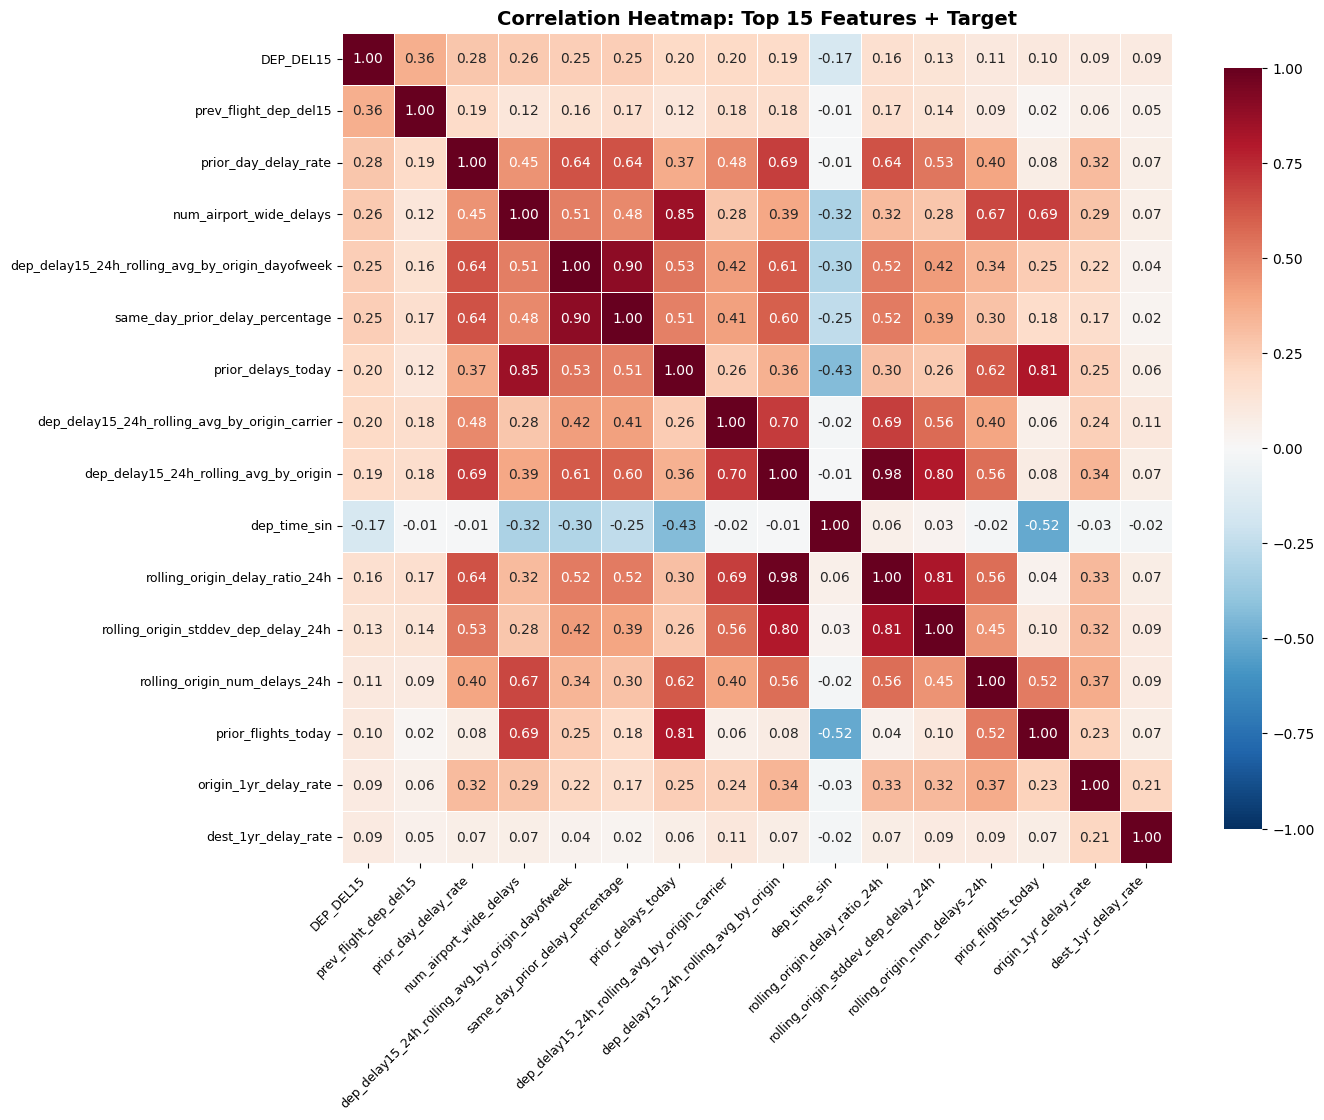

✓ Heatmap created


In [0]:
# Select top 15 features by target correlation + target
top_features = ["DEP_DEL15"] + target_corr.head(15).index.tolist()

# Create heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix.loc[top_features, top_features],
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap: Top 15 Features + Target", fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()

# Display centered
buf = io.BytesIO()
plt.savefig(buf, format="png", dpi=100, bbox_inches='tight')
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()

display(HTML(
    f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
))

print("✓ Heatmap created")

#### D. Feature Selection Recommendations

In [0]:
print("\n" + "=" * 80)
print("FEATURE SELECTION RECOMMENDATIONS")
print("=" * 80)

print("\n Summary:")
print(f"  Total features analyzed: {len(existing_features)}")
print(f"  Highly correlated pairs (>0.8): {len(high_corr_pairs) if high_corr_pairs else 0}")
print(f"  Features recommended to drop: {len(features_to_drop)}")

if features_to_drop:
    print("\n  Features to Drop (redundant, lower target correlation):")
    for feat in sorted(features_to_drop):
        print(f"  {feat}")
    
    print("\n Code to drop these features:")
    print(f"\nfeatures_to_drop = {features_to_drop}")
    print("df_features = df_features.drop(*features_to_drop)")

print("\n Key Insights:")

# Check specific known correlations
known_correlations = {
    "Distance vs Distance_Group": ("DISTANCE", "DISTANCE_GROUP"),
    "Temperature variants": ("HourlyDryBulbTemperature", "HourlyDewPointTemperature", "HourlyWetBulbTemperature"),
    "Pressure variants": ("HourlyStationPressure", "HourlySeaLevelPressure", "HourlyAltimeterSetting"),
    "Binary vs continuous time": ("departure_hour", "is_peak_hour"),
    "Binary vs continuous day": ("DAY_OF_WEEK", "is_weekend")
}

for label, cols in known_correlations.items():
    existing_cols = [c for c in cols if c in corr_matrix.columns]
    if len(existing_cols) >= 2:
        corr_val = corr_matrix.loc[existing_cols[0], existing_cols[1]]
        print(f"  {label}: r={corr_val:.3f}")

print("\n CORRELATION ANALYSIS COMPLETE!")
print("=" * 80)

# Store results for later use
correlation_results = {
    "features_to_drop": features_to_drop,
    "target_correlation": target_corr,
    "correlation_matrix": corr_matrix
}

print("\n Results stored in: correlation_results dictionary")


FEATURE SELECTION RECOMMENDATIONS

 Summary:
  Total features analyzed: 73
  Highly correlated pairs (>0.8): 25
  Features recommended to drop: 21

  Features to Drop (redundant, lower target correlation):
  CRS_ELAPSED_TIME
  DISTANCE
  DISTANCE_GROUP
  HourlyDewPointTemperature
  HourlySeaLevelPressure
  HourlyWetBulbTemperature
  MONTH
  distance_short
  extreme_precipitation
  extreme_weather_score
  num_airport_wide_cancellations
  precip_anomaly
  prev_flight_distance
  prior_delays_today
  prior_flights_today
  rolling_origin_delay_ratio_24h
  rolling_origin_num_flights_24h
  rolling_origin_stddev_dep_delay_24h
  same_day_prior_delay_percentage
  temp_humidity_interaction
  total_flights_per_origin_day

 Code to drop these features:

features_to_drop = ['HourlySeaLevelPressure', 'HourlyWetBulbTemperature', 'CRS_ELAPSED_TIME', 'precip_anomaly', 'rolling_origin_stddev_dep_delay_24h', 'prior_flights_today', 'temp_humidity_interaction', 'prev_flight_distance', 'total_flights_per_or

#### E. Cardinality Analysis:

In [0]:
# Get all string columns (categorical)
categorical_cols = [
    field.name for field in df_features.schema.fields 
    if field.dataType.simpleString() == "string"
]

# Helper function to categorize cardinality
def categorize_cardinality(distinct_count, ratio):
    if distinct_count <= 2:
        return "Binary"
    elif distinct_count <= 10:
        return "Low (2-10)"
    elif distinct_count <= 50:
        return "Medium (11-50)"
    elif distinct_count <= 100:
        return "High (51-100)"
    elif ratio > 0.5:
        return "Extremely High (>50% unique)"
    else:
        return "Very High (>100)"

print(f"Found {len(categorical_cols)} categorical (string) columns:\n")
for col_name in categorical_cols:
    print(f"  - {col_name}")

# Calculate distinct values and total rows
total_rows = df_features.count()
print(f"Total rows in dataset: {total_rows:,}\n")

cardinality_stats = []

for col_name in categorical_cols:
    # Count distinct values
    distinct_count = df_features.select(countDistinct(col(col_name))).first()[0]
    
    # Count nulls
    null_count = df_features.filter(col(col_name).isNull()).count()
    
    # Calculate cardinality ratio (distinct / total)
    cardinality_ratio = distinct_count / total_rows
    
    cardinality_stats.append({
        "Column": col_name,
        "Distinct Values": distinct_count,
        "Null Count": null_count,
        "Null %": (null_count / total_rows) * 100,
        "Cardinality Ratio": cardinality_ratio,
        "Category": categorize_cardinality(distinct_count, cardinality_ratio)
    })
    
    print(f"✓ {col_name}: {distinct_count:,} distinct values ({cardinality_ratio:.4f} ratio)")

# Create DataFrame
cardinality_df = pd.DataFrame(cardinality_stats)
cardinality_df = cardinality_df.sort_values("Distinct Values", ascending=False)

print("\n" + "=" * 80)
print("CARDINALITY SUMMARY")
print("=" * 80)
display(cardinality_df)

Found 16 categorical (string) columns:

  - ORIGIN
  - flight_id
  - OP_UNIQUE_CARRIER
  - ORIGIN_STATE_ABR
  - DEST
  - DEST_STATE_ABR
  - HourlySkyConditions
  - HourlyPresentWeatherType
  - origin_type
  - dest_type
  - CANCELLATION_CODE
  - season
  - weather_condition_category
  - turnaround_category
  - day_hour_interaction
  - sky_condition_parsed
Total rows in dataset: 7,258,941

✓ ORIGIN: 357 distinct values (0.0000 ratio)
✓ flight_id: 7,258,941 distinct values (1.0000 ratio)
✓ OP_UNIQUE_CARRIER: 17 distinct values (0.0000 ratio)
✓ ORIGIN_STATE_ABR: 52 distinct values (0.0000 ratio)
✓ DEST: 359 distinct values (0.0000 ratio)
✓ DEST_STATE_ABR: 52 distinct values (0.0000 ratio)
✓ HourlySkyConditions: 126,130 distinct values (0.0174 ratio)
✓ HourlyPresentWeatherType: 733 distinct values (0.0001 ratio)
✓ origin_type: 3 distinct values (0.0000 ratio)
✓ dest_type: 3 distinct values (0.0000 ratio)
✓ CANCELLATION_CODE: 1 distinct values (0.0000 ratio)
✓ season: 4 distinct values (0.00

,Column,Distinct Values,Null Count,Null %,Cardinality Ratio,Category
1,flight_id,7258941,0,0.0,1.000000e+00,Extremely High (>50% unique)
6,HourlySkyConditions,126130,0,0.0,1.737581e-02,Very High (>100)
7,HourlyPresentWeatherType,733,0,0.0,1.009789e-04,Very High (>100)
4,DEST,359,0,0.0,4.945625e-05,Very High (>100)
0,ORIGIN,357,0,0.0,4.918073e-05,Very High (>100)
14,day_hour_interaction,168,0,0.0,2.314387e-05,Very High (>100)
5,DEST_STATE_ABR,52,0,0.0,7.163579e-06,High (51-100)
3,ORIGIN_STATE_ABR,52,0,0.0,7.163579e-06,High (51-100)
2,OP_UNIQUE_CARRIER,17,0,0.0,2.341939e-06,Medium (11-50)
15,sky_condition_parsed,6,0,0.0,8.265669e-07,Low (2-10)


In [0]:
# Group by category
category_summary = cardinality_df.groupby("Category").agg({
    "Column": "count",
    "Distinct Values": ["min", "max"]
}).reset_index()

category_summary.columns = ["Category", "Count", "Min Distinct", "Max Distinct"]
category_summary = category_summary.sort_values("Max Distinct", ascending=False)

display(category_summary)

# List columns in each category
print("\n Detailed Breakdown:\n")

for category in ["Extremely High (>50% unique)", "Very High (>100)", "High (51-100)", 
                 "Medium (11-50)", "Low (2-10)", "Binary"]:
    cols_in_category = cardinality_df[cardinality_df["Category"] == category]["Column"].tolist()
    if cols_in_category:
        print(f"\n{category}: {len(cols_in_category)} columns")
        for col_name in cols_in_category:
            distinct = cardinality_df[cardinality_df["Column"] == col_name]["Distinct Values"].values[0]
            print(f"  - {col_name}: {distinct:,} values")

,Category,Count,Min Distinct,Max Distinct
1,Extremely High (>50% unique),1,7258941,7258941
5,Very High (>100),5,168,126130
2,High (51-100),2,52,52
4,Medium (11-50),1,17,17
3,Low (2-10),6,3,6
0,Binary,1,1,1



📋 Detailed Breakdown:


Extremely High (>50% unique): 1 columns
  - flight_id: 7,258,941 values

Very High (>100): 5 columns
  - HourlySkyConditions: 126,130 values
  - HourlyPresentWeatherType: 733 values
  - DEST: 359 values
  - ORIGIN: 357 values
  - day_hour_interaction: 168 values

High (51-100): 2 columns
  - DEST_STATE_ABR: 52 values
  - ORIGIN_STATE_ABR: 52 values

Medium (11-50): 1 columns
  - OP_UNIQUE_CARRIER: 17 values

Low (2-10): 6 columns
  - sky_condition_parsed: 6 values
  - season: 4 values
  - turnaround_category: 4 values
  - origin_type: 3 values
  - dest_type: 3 values
  - weather_condition_category: 3 values

Binary: 1 columns
  - CANCELLATION_CODE: 1 values


#### F. Cardinality Charts:


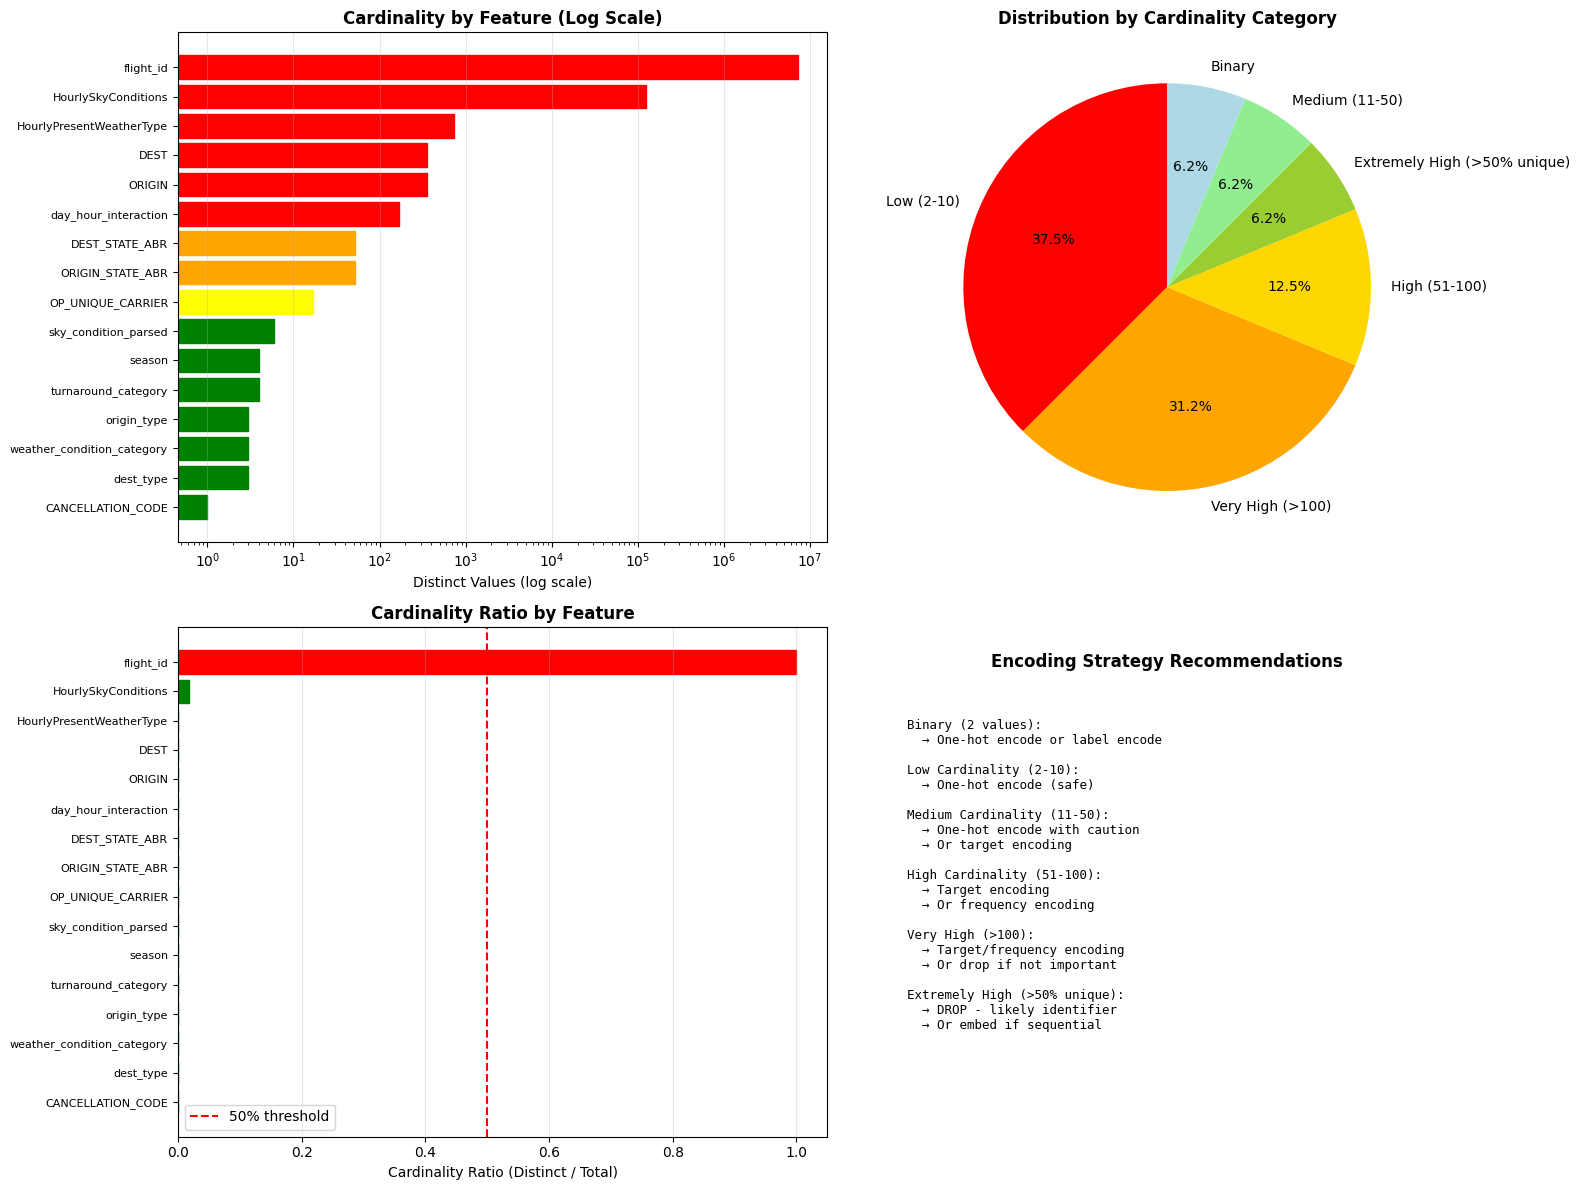

✓ Visualizations created


In [0]:
# 4a. Cardinality Distribution (Bar Chart)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Cardinality by column (log scale)
ax1 = axes[0, 0]
cardinality_df_sorted = cardinality_df.sort_values("Distinct Values", ascending=True)
ax1.barh(range(len(cardinality_df_sorted)), cardinality_df_sorted["Distinct Values"])
ax1.set_yticks(range(len(cardinality_df_sorted)))
ax1.set_yticklabels(cardinality_df_sorted["Column"], fontsize=8)
ax1.set_xlabel("Distinct Values (log scale)", fontsize=10)
ax1.set_title("Cardinality by Feature (Log Scale)", fontsize=12, fontweight='bold')
ax1.set_xscale('log')
ax1.grid(axis='x', alpha=0.3)

# Add color coding
colors = []
for val in cardinality_df_sorted["Distinct Values"]:
    if val > 100:
        colors.append('red')
    elif val > 50:
        colors.append('orange')
    elif val > 10:
        colors.append('yellow')
    else:
        colors.append('green')

for i, (bar, color) in enumerate(zip(ax1.patches, colors)):
    bar.set_color(color)

# Plot 2: Category distribution
ax2 = axes[0, 1]
category_counts = cardinality_df["Category"].value_counts()
colors_cat = ['red', 'orange', 'gold', 'yellowgreen', 'lightgreen', 'lightblue']
ax2.pie(category_counts.values, labels=category_counts.index, autopct='%1.1f%%',
        colors=colors_cat, startangle=90)
ax2.set_title("Distribution by Cardinality Category", fontsize=12, fontweight='bold')

# Plot 3: Cardinality Ratio
ax3 = axes[1, 0]
cardinality_df_sorted2 = cardinality_df.sort_values("Cardinality Ratio", ascending=True)
bars = ax3.barh(range(len(cardinality_df_sorted2)), cardinality_df_sorted2["Cardinality Ratio"])
ax3.set_yticks(range(len(cardinality_df_sorted2)))
ax3.set_yticklabels(cardinality_df_sorted2["Column"], fontsize=8)
ax3.set_xlabel("Cardinality Ratio (Distinct / Total)", fontsize=10)
ax3.set_title("Cardinality Ratio by Feature", fontsize=12, fontweight='bold')
ax3.axvline(x=0.5, color='red', linestyle='--', label='50% threshold')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# Color code by ratio
for i, (bar, ratio) in enumerate(zip(bars, cardinality_df_sorted2["Cardinality Ratio"])):
    if ratio > 0.5:
        bar.set_color('red')
    elif ratio > 0.1:
        bar.set_color('orange')
    else:
        bar.set_color('green')

# Plot 4: Sample top 5 value distributions
ax4 = axes[1, 1]
ax4.axis('off')
ax4.text(0.5, 0.95, "Encoding Strategy Recommendations", 
         ha='center', va='top', fontsize=12, fontweight='bold',
         transform=ax4.transAxes)

recommendations_text = """
Binary (2 values):
  → One-hot encode or label encode
  
Low Cardinality (2-10):
  → One-hot encode (safe)
  
Medium Cardinality (11-50):
  → One-hot encode with caution
  → Or target encoding
  
High Cardinality (51-100):
  → Target encoding
  → Or frequency encoding
  
Very High (>100):
  → Target/frequency encoding
  → Or drop if not important
  
Extremely High (>50% unique):
  → DROP - likely identifier
  → Or embed if sequential
"""

ax4.text(0.1, 0.85, recommendations_text, 
         ha='left', va='top', fontsize=9, family='monospace',
         transform=ax4.transAxes)

plt.tight_layout()

# Save and display
buf = io.BytesIO()
plt.savefig(buf, format="png", dpi=100, bbox_inches='tight')
buf.seek(0)
img_base64 = base64.b64encode(buf.read()).decode("utf-8")
plt.close()

display(HTML(
    f"<div style='text-align: center;'><img src='data:image/png;base64,{img_base64}'/></div>"
))

print("✓ Visualizations created")

#### G. Cardinality Groupings/Feature Encoding Recs:

In [0]:
# Show top 10 values for low/medium cardinality features
sample_cols = cardinality_df[cardinality_df["Distinct Values"] <= 20]["Column"].tolist()

if sample_cols:
    print(f"Showing top values for {len(sample_cols)} low-cardinality features:\n")
    
    for col_name in sample_cols[:5]:  # Show first 5 to avoid clutter
        print(f"\n{col_name}:")
        value_counts = df_features.groupBy(col_name).count().orderBy(col("count").desc())
        value_counts.show(10, truncate=False)

Showing top values for 8 low-cardinality features:


OP_UNIQUE_CARRIER:
+-----------------+-------+
|OP_UNIQUE_CARRIER|count  |
+-----------------+-------+
|WN               |1327434|
|DL               |987950 |
|AA               |924106 |
|OO               |812827 |
|UA               |618097 |
|YX               |320614 |
|MQ               |314648 |
|B6               |289225 |
|OH               |281637 |
|AS               |260999 |
+-----------------+-------+
only showing top 10 rows

sky_condition_parsed:
+--------------------+-------+
|sky_condition_parsed|count  |
+--------------------+-------+
|Few                 |2568564|
|Unknown             |1305260|
|Scattered           |1096317|
|Broken              |893796 |
|Clear               |854185 |
|Overcast            |540819 |
+--------------------+-------+


season:
+------+-------+
|season|count  |
+------+-------+
|Summer|1907799|
|Spring|1834041|
|Fall  |1817784|
|Winter|1699317|
+------+-------+


turnaround_category:
+--------

In [0]:
print("\n" + "=" * 80)
print("FEATURE ENCODING RECOMMENDATIONS")
print("=" * 80)

# Categorize features by recommended encoding
encoding_recommendations = {
    "One-Hot Encode (Safe)": [],
    "One-Hot Encode (With Caution)": [],
    "Target/Frequency Encode": [],
    "DROP (Too High Cardinality)": [],
    "Already Numeric/Binary": []
}

for _, row in cardinality_df.iterrows():
    col_name = row["Column"]
    distinct = row["Distinct Values"]
    ratio = row["Cardinality Ratio"]
    
    if ratio > 0.5 or distinct > 1000:
        encoding_recommendations["DROP (Too High Cardinality)"].append(
            f"{col_name} ({distinct:,} values, {ratio:.2%} ratio)"
        )
    elif distinct > 100:
        encoding_recommendations["Target/Frequency Encode"].append(
            f"{col_name} ({distinct} values)"
        )
    elif distinct > 50:
        encoding_recommendations["One-Hot Encode (With Caution)"].append(
            f"{col_name} ({distinct} values)"
        )
    elif distinct <= 50:
        encoding_recommendations["One-Hot Encode (Safe)"].append(
            f"{col_name} ({distinct} values)"
        )

# Display recommendations
for strategy, features in encoding_recommendations.items():
    if features:
        print(f"\n{strategy}: {len(features)} features")
        for feat in features:
            print(f"  • {feat}")


FEATURE ENCODING RECOMMENDATIONS

One-Hot Encode (Safe): 8 features
  • OP_UNIQUE_CARRIER (17 values)
  • sky_condition_parsed (6 values)
  • season (4 values)
  • turnaround_category (4 values)
  • origin_type (3 values)
  • dest_type (3 values)
  • weather_condition_category (3 values)
  • CANCELLATION_CODE (1 values)

One-Hot Encode (With Caution): 2 features
  • DEST_STATE_ABR (52 values)
  • ORIGIN_STATE_ABR (52 values)

Target/Frequency Encode: 4 features
  • HourlyPresentWeatherType (733 values)
  • DEST (359 values)
  • ORIGIN (357 values)
  • day_hour_interaction (168 values)

DROP (Too High Cardinality): 2 features
  • flight_id (7,258,941 values, 100.00% ratio)
  • HourlySkyConditions (126,130 values, 1.74% ratio)


In [0]:
# Features with >50% unique values or >1000 distinct values
drop_candidates = cardinality_df[
    (cardinality_df["Cardinality Ratio"] > 0.5) | 
    (cardinality_df["Distinct Values"] > 1000)
]["Column"].tolist()

if drop_candidates:
    print(f"Recommended to DROP {len(drop_candidates)} features:\n")
    for col_name in drop_candidates:
        stats = cardinality_df[cardinality_df["Column"] == col_name].iloc[0]
        print(f"  - {col_name}:")
        print(f"      Distinct: {stats['Distinct Values']:,}")
        print(f"      Ratio: {stats['Cardinality Ratio']:.2%}")
        print(f"      Reason: {'Likely identifier' if stats['Cardinality Ratio'] > 0.5 else 'Too many categories for encoding'}")
    
    print(f"\nCode to drop these features:")
    print(f"\nhigh_cardinality_drops = {drop_candidates}")
    print("df_features = df_features.drop(*high_cardinality_drops)")
    
else:
    print(" No extremely high-cardinality features found")

Recommended to DROP 2 features:

  - flight_id:
      Distinct: 7,258,941
      Ratio: 100.00%
      Reason: Likely identifier
  - HourlySkyConditions:
      Distinct: 126,130
      Ratio: 1.74%
      Reason: Too many categories for encoding

Code to drop these features:

high_cardinality_drops = ['flight_id', 'HourlySkyConditions']
df_features = df_features.drop(*high_cardinality_drops)


In [0]:
# Features with 51-1000 distinct values (good for target encoding)
target_encode_candidates = cardinality_df[
    (cardinality_df["Distinct Values"] > 50) & 
    (cardinality_df["Distinct Values"] <= 1000) &
    (cardinality_df["Cardinality Ratio"] <= 0.5)
]["Column"].tolist()

if target_encode_candidates:
    print(f"Recommended for TARGET ENCODING: {len(target_encode_candidates)} features\n")
    for col_name in target_encode_candidates:
        stats = cardinality_df[cardinality_df["Column"] == col_name].iloc[0]
        print(f"  • {col_name}: {stats['Distinct Values']} distinct values")
    
    print("\n Target encoding benefits:")
    print("  - Captures relationship between category and target")
    print("  - Single numeric column (not 100+ dummy variables)")
    print("  - Works well for high-cardinality categoricals")
    
    print("\nImportant: Use cross-validation to avoid leakage!")
    
else:
    print("No features require target encoding")

Recommended for TARGET ENCODING: 6 features

  • HourlyPresentWeatherType: 733 distinct values
  • DEST: 359 distinct values
  • ORIGIN: 357 distinct values
  • day_hour_interaction: 168 distinct values
  • DEST_STATE_ABR: 52 distinct values
  • ORIGIN_STATE_ABR: 52 distinct values

 Target encoding benefits:
  - Captures relationship between category and target
  - Single numeric column (not 100+ dummy variables)
  - Works well for high-cardinality categoricals

Important: Use cross-validation to avoid leakage!


In [0]:
# Features safe for one-hot encoding (≤50 distinct values)
onehot_candidates = cardinality_df[
    cardinality_df["Distinct Values"] <= 50
]["Column"].tolist()

if onehot_candidates:
    print(f"Safe for ONE-HOT ENCODING: {len(onehot_candidates)} features\n")
    
    total_dummy_vars = 0
    for col_name in onehot_candidates:
        stats = cardinality_df[cardinality_df["Column"] == col_name].iloc[0]
        dummy_vars = stats['Distinct Values'] - 1  # n-1 encoding
        total_dummy_vars += dummy_vars
        print(f"  • {col_name}: {stats['Distinct Values']} values → {dummy_vars} dummy variables")
    
    print(f"\nTotal additional columns after one-hot encoding: {total_dummy_vars}")
    print(f"   Current columns: {len(df_features.columns)}")
    print(f"   After encoding: ~{len(df_features.columns) + total_dummy_vars - len(onehot_candidates)}")
    
else:
    print("No features suitable for one-hot encoding")

Safe for ONE-HOT ENCODING: 8 features

  • OP_UNIQUE_CARRIER: 17 values → 16 dummy variables
  • sky_condition_parsed: 6 values → 5 dummy variables
  • season: 4 values → 3 dummy variables
  • turnaround_category: 4 values → 3 dummy variables
  • origin_type: 3 values → 2 dummy variables
  • dest_type: 3 values → 2 dummy variables
  • weather_condition_category: 3 values → 2 dummy variables
  • CANCELLATION_CODE: 1 values → 0 dummy variables

Total additional columns after one-hot encoding: 33
   Current columns: 124
   After encoding: ~149


In [0]:
print("\n" + "=" * 80)
print("CARDINALITY ANALYSIS SUMMARY")
print("=" * 80)

print(f"\nOverview:")
print(f"  Total categorical features: {len(categorical_cols)}")
print(f"  Binary/Low (≤10): {len(cardinality_df[cardinality_df['Distinct Values'] <= 10])}")
print(f"  Medium (11-50): {len(cardinality_df[cardinality_df['Distinct Values'].between(11, 50)])}")
print(f"  High (51-100): {len(cardinality_df[cardinality_df['Distinct Values'].between(51, 100)])}")
print(f"  Very High (>100): {len(cardinality_df[cardinality_df['Distinct Values'] > 100])}")

print(f"\ Action Items:")
print(f"  1. DROP: {len(drop_candidates)} features (too high cardinality)")
print(f"  2. Target encode: {len(target_encode_candidates)} features")
print(f"  3. One-hot encode: {len(onehot_candidates)} features")

print(f"\n Next Steps:")
print("  1. Drop extremely high-cardinality features")
print("  2. Implement target encoding for medium-high cardinality")
print("  3. One-hot encode remaining categoricals")
print("  4. Proceed to model training")

print("\n CARDINALITY ANALYSIS COMPLETE!")
print("=" * 80)

# Store results
cardinality_results = {
    "cardinality_df": cardinality_df,
    "drop_candidates": drop_candidates,
    "target_encode_candidates": target_encode_candidates,
    "onehot_candidates": onehot_candidates
}

print("\nResults stored in: cardinality_results dictionary")


CARDINALITY ANALYSIS SUMMARY

Overview:
  Total categorical features: 16
  Binary/Low (≤10): 7
  Medium (11-50): 1
  High (51-100): 2
  Very High (>100): 6
\ Action Items:
  1. DROP: 2 features (too high cardinality)
  2. Target encode: 6 features
  3. One-hot encode: 8 features

 Next Steps:
  1. Drop extremely high-cardinality features
  2. Implement target encoding for medium-high cardinality
  3. One-hot encode remaining categoricals
  4. Proceed to model training

 CARDINALITY ANALYSIS COMPLETE!

Results stored in: cardinality_results dictionary


<>:12: SyntaxWarning: invalid escape sequence '\ '
<>:12: SyntaxWarning: invalid escape sequence '\ '
/root/.ipykernel/2192/command-7250714370594943-343657709:12: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Action Items:")


#### H. ANOVA Feature Selection:

In [0]:
print("\n" + "=" * 80)
print("ADVANCED FEATURE SELECTION - STATISTICAL TESTS")
print("=" * 80)

print("\n=== Step 1: ANOVA (Analysis of Variance) for Categoricals ===\n")
print("Testing which categorical features significantly differ between delayed/on-time flights\n")

# Get categorical columns (excluding high-cardinality ones we'll drop)
categorical_cols = [
    field.name for field in df_features.schema.fields 
    if field.dataType.simpleString() == "string" and field.name != "flight_id"
]

# Filter out extremely high cardinality (>100 distinct values)
low_cardinality_cols = []
for col_name in categorical_cols:
    distinct_count = df_features.select(countDistinct(col(col_name))).first()[0]
    if distinct_count <= 100:
        low_cardinality_cols.append(col_name)

print(f"Testing {len(low_cardinality_cols)} categorical features with <=100 distinct values:\n")

# Sample data for ANOVA (full dataset would be too slow)
sample_df = df_features.sample(fraction=0.1, seed=42)
sample_pd = sample_df.toPandas()

anova_results = []

for cat_col in low_cardinality_cols:
    try:
        # Group target by categorical feature
        groups = []
        categories = sample_pd[cat_col].dropna().unique()
        
        # Skip if too many categories (ANOVA becomes unreliable)
        if len(categories) > 50:
            continue
        
        for category in categories:
            group_data = sample_pd[sample_pd[cat_col] == category]['DEP_DEL15'].dropna()
            if len(group_data) > 0:
                groups.append(group_data)
        
        # Need at least 2 groups for ANOVA
        if len(groups) >= 2:
            # Perform one-way ANOVA
            f_stat, p_value = stats.f_oneway(*groups)
            
            anova_results.append({
                "Feature": cat_col,
                "F-Statistic": f_stat,
                "P-Value": p_value,
                "Significant": "Yes" if p_value < 0.05 else "No",
                "Categories": len(categories)
            })
            
            significance = "Significant" if p_value < 0.05 else "Not significant"
            print(f"Complete: {cat_col}: F={f_stat:.2f}, p={p_value:.4f} {significance}")
    
    except Exception as e:
        print(f"Warning: {cat_col}: Error - {str(e)}")

# Create results DataFrame
if anova_results:
    anova_df = pd.DataFrame(anova_results)
    anova_df = anova_df.sort_values("P-Value")
    
    print("\n" + "=" * 80)
    print("ANOVA RESULTS - SIGNIFICANT CATEGORICAL FEATURES")
    print("=" * 80)
    
    display(anova_df)
    
    # Significant features
    significant_cats = anova_df[anova_df["P-Value"] < 0.05]["Feature"].tolist()
    insignificant_cats = anova_df[anova_df["P-Value"] >= 0.05]["Feature"].tolist()
    
    print(f"\nSignificant features (p < 0.05): {len(significant_cats)}")
    print(f"Insignificant features (p >= 0.05): {len(insignificant_cats)}")
    
    if insignificant_cats:
        print(f"\nConsider dropping these {len(insignificant_cats)} insignificant categorical features:")
        for feat in insignificant_cats:
            print(f"  - {feat}")
else:
    significant_cats = []
    insignificant_cats = []


ADVANCED FEATURE SELECTION - STATISTICAL TESTS

=== Step 1: ANOVA (Analysis of Variance) for Categoricals ===

Testing which categorical features significantly differ between delayed/on-time flights

Testing 10 categorical features with <=100 distinct values:



#### I. Pearson vs Spearman Correlation:

In [0]:
print("\n=== Step 2: Pearson vs Spearman Correlation ===\n")
print("Pearson: Linear relationships")
print("Spearman: Monotonic (non-linear) relationships\n")

# Get numeric features (exclude target)
numeric_features = [
    field.name for field in df_features.schema.fields 
    if field.dataType.simpleString() in ("double", "float", "int", "integer", "long")
    and field.name != "DEP_DEL15"
]

print(f"Analyzing {len(numeric_features)} numeric features...")

# Sample for correlation analysis
sample_df = df_features.select(["DEP_DEL15"] + numeric_features).sample(fraction=0.1, seed=42)
sample_pd = sample_df.toPandas()

# Calculate both correlations
print("\nCalculating Pearson correlation...")
pearson_corr = sample_pd.corr(method='pearson')["DEP_DEL15"].drop("DEP_DEL15")

print("Calculating Spearman correlation...")
spearman_corr = sample_pd.corr(method='spearman')["DEP_DEL15"].drop("DEP_DEL15")

# Compare
correlation_comparison = pd.DataFrame({
    "Feature": pearson_corr.index,
    "Pearson": pearson_corr.values,
    "Spearman": spearman_corr.values,
    "Difference": np.abs(spearman_corr.values - pearson_corr.values),
    "Abs Pearson": np.abs(pearson_corr.values),
    "Abs Spearman": np.abs(spearman_corr.values)
})

# Find features where Spearman differs significantly from Pearson
correlation_comparison["Stronger"] = correlation_comparison.apply(
    lambda x: "Spearman" if x["Abs Spearman"] > x["Abs Pearson"] else "Pearson", axis=1
)

# Sort by max absolute correlation
correlation_comparison["Max Abs"] = correlation_comparison[["Abs Pearson", "Abs Spearman"]].max(axis=1)
correlation_comparison = correlation_comparison.sort_values("Max Abs", ascending=False)

print("\n" + "=" * 80)
print("TOP 20 FEATURES - PEARSON VS SPEARMAN")
print("=" * 80)
display(correlation_comparison.head(20))

# Features where non-linear relationship is stronger
nonlinear_features = correlation_comparison[
    (correlation_comparison["Difference"] > 0.05) & 
    (correlation_comparison["Stronger"] == "Spearman")
]["Feature"].tolist()

if nonlinear_features:
    print(f"\nFeatures with non-linear relationships ({len(nonlinear_features)}):")
    print("   (Spearman correlation significantly higher than Pearson)")
    for feat in nonlinear_features[:10]:
        diff = correlation_comparison[correlation_comparison["Feature"] == feat]["Difference"].values[0]
        print(f"  - {feat} (difference: {diff:.3f})")


=== Step 2: Pearson vs Spearman Correlation ===

Pearson: Linear relationships
Spearman: Monotonic (non-linear) relationships

Analyzing 91 numeric features...

Calculating Pearson correlation...
Calculating Spearman correlation...

TOP 20 FEATURES - PEARSON VS SPEARMAN


,Feature,Pearson,Spearman,Difference,Abs Pearson,Abs Spearman,Stronger,Max Abs
60,prev_flight_dep_del15,0.362564,0.362036,5.287468e-04,0.362564,0.362036,Pearson,0.362564
69,prior_day_delay_rate,0.276548,0.253015,2.353255e-02,0.276548,0.253015,Pearson,0.276548
48,dep_delay15_24h_rolling_avg_by_origin_dayofweek,0.249911,0.237718,1.219317e-02,0.249911,0.237718,Pearson,0.249911
70,same_day_prior_delay_percentage,0.246848,0.228070,1.877757e-02,0.246848,0.228070,Pearson,0.246848
47,dep_delay15_24h_rolling_avg_by_origin_carrier,0.203140,0.198857,4.283153e-03,0.203140,0.198857,Pearson,0.203140
46,dep_delay15_24h_rolling_avg_by_origin,0.194238,0.187358,6.879766e-03,0.194238,0.187358,Pearson,0.194238
81,dep_time_sin,-0.170114,-0.167569,2.544969e-03,0.170114,0.167569,Pearson,0.170114
7,CRS_DEP_TIME,0.165493,0.168498,3.005401e-03,0.165493,0.168498,Spearman,0.168498
59,CRS_DEP_HOUR,0.165202,0.168331,3.129755e-03,0.165202,0.168331,Spearman,0.168331
44,rolling_origin_delay_ratio_24h,0.158863,0.157750,1.112928e-03,0.158863,0.157750,Pearson,0.158863



Features with non-linear relationships (1):
   (Spearman correlation significantly higher than Pearson)
  - hours_since_prev_flight (difference: 0.075)


#### J. Extremely High Feature Correlation (>0.95)/Chi-Squared Tests:

In [0]:
print("\n=== Step 3: Extremely High Correlation (>0.95) ===\n")
print("More strict threshold than previous analysis (0.8)\n")

# Use correlation matrix from earlier
if 'correlation_results' in locals() and 'correlation_matrix' in correlation_results:
    corr_matrix = correlation_results['correlation_matrix']
else:
    print("Recalculating correlation matrix...")
    sample_df = df_features.select(["DEP_DEL15"] + existing_features).sample(fraction=0.1, seed=42)
    sample_pd = sample_df.toPandas()
    # Fill nulls before correlation
    sample_pd = sample_pd.fillna(0)
    corr_matrix = sample_pd.corr()

# Find pairs with |correlation| > 0.95
extremely_high_corr = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        col_i = corr_matrix.columns[i]
        col_j = corr_matrix.columns[j]
        corr_val = corr_matrix.iloc[i, j]
        
        if col_i == "DEP_DEL15" or col_j == "DEP_DEL15":
            continue
        
        if pd.isna(corr_val):
            continue
            
        if abs(corr_val) > 0.95:
            # Get target correlation
            corr_i_target = abs(corr_matrix.loc[col_i, "DEP_DEL15"])
            corr_j_target = abs(corr_matrix.loc[col_j, "DEP_DEL15"])
            
            extremely_high_corr.append({
                "Feature 1": col_i,
                "Feature 2": col_j,
                "Correlation": corr_val,
                "Feature 1 -> Target": corr_i_target,
                "Feature 2 -> Target": corr_j_target,
                "Drop": col_j if corr_i_target >= corr_j_target else col_i
            })

if extremely_high_corr:
    extreme_corr_df = pd.DataFrame(extremely_high_corr)
    extreme_corr_df = extreme_corr_df.sort_values("Correlation", key=abs, ascending=False)
    
    print(f"Found {len(extreme_corr_df)} pairs with |correlation| > 0.95:\n")
    display(extreme_corr_df)
    
    features_to_drop_95 = list(set(extreme_corr_df["Drop"].tolist()))
    
    print(f"\nFeatures to drop (extremely redundant): {len(features_to_drop_95)}")
    for feat in features_to_drop_95:
        print(f"  - {feat}")
else:
    print("No feature pairs with |correlation| > 0.95 found")
    features_to_drop_95 = []

print("\n=== Step 4: Chi-Squared Feature Selection (OPTIONAL) ===\n")
print("Note: Chi-Squared is optional - we already have good selection from correlation\n")

# Try Chi-Squared but don't fail if it doesn't work
try:
    print("Step 4a: Preparing features (scaling to non-negative)...")
    
    # Select only numeric features
    numeric_cols_for_chi = [
        field.name for field in df_features.schema.fields 
        if field.dataType.simpleString() in ("double", "float", "int", "integer", "long")
        and field.name not in ["DEP_DEL15", "flight_id"]
    ]
    
    print(f"  Processing {len(numeric_cols_for_chi)} numeric features")
    
    # Create sample for chi-squared (use 10% for speed)
    chi_sample = df_features.select(["DEP_DEL15"] + numeric_cols_for_chi) \
        .sample(fraction=0.1, seed=42)
    
    # FILL NULLS instead of dropping
    print("  Filling nulls with 0 (better than dropping all rows)...")
    for c in chi_sample.columns:
        chi_sample = chi_sample.fillna({c: 0.0})
    
    sample_count = chi_sample.count()
    print(f"  Sample size: {sample_count:,} rows")
    
    if sample_count == 0:
        raise ValueError("Sample has 0 rows after null handling")
    
    # Assemble features into vector
    print("\nStep 4b: Assembling feature vector...")
    assembler = VectorAssembler(
        inputCols=numeric_cols_for_chi,
        outputCol="features_raw",
        handleInvalid="skip"
    )
    
    # Scale features to be non-negative (min-max scaling to [0, 1])
    print("Step 4c: Scaling features to [0, 1] range...")
    
    scaler = MinMaxScaler(
        inputCol="features_raw",
        outputCol="features_scaled"
    )
    
    # Create pipeline
    pipeline = Pipeline(stages=[assembler, scaler])
    
    # Fit and transform
    print("Step 4d: Fitting pipeline...")
    pipeline_model = pipeline.fit(chi_sample)
    scaled_data = pipeline_model.transform(chi_sample)
    
    # Apply Chi-Squared selector
    print("\nStep 4e: Running Chi-Squared feature selection...")
    print("  Testing top 50 features by chi-squared statistic...\n")
    
    selector = ChiSqSelector(
        numTopFeatures=min(50, len(numeric_cols_for_chi)),
        featuresCol="features_scaled",
        outputCol="selected_features",
        labelCol="DEP_DEL15"
    )
    
    selector_model = selector.fit(scaled_data)
    
    # Get selected features
    selected_indices = selector_model.selectedFeatures
    selected_feature_names = [numeric_cols_for_chi[i] for i in selected_indices]
    
    print(f"Chi-Squared selected {len(selected_feature_names)} features:")
    for i, feat in enumerate(selected_feature_names[:20], 1):
        print(f"  {i}. {feat}")
    
    if len(selected_feature_names) > 20:
        print(f"  ... and {len(selected_feature_names) - 20} more")
    
    # Features NOT selected
    not_selected = [f for f in numeric_cols_for_chi if f not in selected_feature_names]
    
    if not_selected:
        print(f"\nFeatures NOT selected by Chi-Squared ({len(not_selected)}):")
        for feat in not_selected[:20]:
            print(f"  - {feat}")
        if len(not_selected) > 20:
            print(f"  ... and {len(not_selected) - 20} more")
    
    chi_squared_completed = True

except Exception as e:
    print(f"\nChi-Squared test failed: {str(e)}")
    print("This is OK - we'll use correlation-based selection instead")
    selected_feature_names = []
    not_selected = []
    chi_squared_completed = False

print("\n" + "=" * 80)
print("CONSOLIDATED FEATURE REMOVAL RECOMMENDATIONS")
print("=" * 80)

# Combine all recommendations
all_drops = set()

# 1. High correlation (>0.95)
if features_to_drop_95:
    all_drops.update(features_to_drop_95)
    print(f"\n1. Extremely high correlation (>0.95): {len(features_to_drop_95)} features")

# 2. Insignificant categoricals (ANOVA p >= 0.05)
if 'insignificant_cats' in locals() and insignificant_cats:
    all_drops.update(insignificant_cats)
    print(f"2. Insignificant categoricals (ANOVA): {len(insignificant_cats)} features")

# 3. Not selected by Chi-Squared (if it completed)
if chi_squared_completed and not_selected:
    # Be selective - only drop if correlation is also low
    chi_drops_to_consider = []
    for feat in not_selected:
        if feat in corr_matrix.columns:
            target_corr = abs(corr_matrix.loc[feat, "DEP_DEL15"])
            if target_corr < 0.05:  # Only drop if very low correlation
                chi_drops_to_consider.append(feat)
    
    if chi_drops_to_consider:
        all_drops.update(chi_drops_to_consider)
        print(f"3. Not selected by Chi-Squared AND low correlation (<0.05): {len(chi_drops_to_consider)} features")
else:
    print("3. Chi-Squared: Skipped (using correlation-based selection)")

# 4. From previous cardinality analysis
if 'cardinality_results' in locals() and cardinality_results.get('drop_candidates'):
    all_drops.update(cardinality_results['drop_candidates'])
    print(f"4. High cardinality: {len(cardinality_results['drop_candidates'])} features")

print(f"\nTOTAL FEATURES TO DROP: {len(all_drops)}")

# Group by reason
print("\nFeatures to drop (top 30 shown):")
for i, feat in enumerate(sorted(all_drops)[:30], 1):
    print(f"  {i}. {feat}")

if len(all_drops) > 30:
    print(f"  ... and {len(all_drops) - 30} more")

print("\n" + "=" * 80)
print("FINAL FEATURE IMPORTANCE SUMMARY")
print("=" * 80)

# Combine all metrics
if 'correlation_comparison' in locals():
    feature_importance = pd.DataFrame({
        "Feature": correlation_comparison["Feature"],
        "Pearson_Corr": correlation_comparison["Pearson"],
        "Spearman_Corr": correlation_comparison["Spearman"],
        "Chi_Squared_Selected": correlation_comparison["Feature"].apply(
            lambda x: "Yes" if x in selected_feature_names else "N/A"
        ),
        "Recommendation": correlation_comparison["Feature"].apply(
            lambda x: "DROP" if x in all_drops else "KEEP"
        )
    })
    
    # Sort by recommendation and correlation
    feature_importance["Max_Corr"] = feature_importance[["Pearson_Corr", "Spearman_Corr"]].abs().max(axis=1)
    feature_importance = feature_importance.sort_values("Max_Corr", ascending=False)
    
    print("\nTop 30 Features to KEEP:")
    keep_features = feature_importance[feature_importance["Recommendation"] == "KEEP"].head(30)
    display(keep_features)
    
    print("\nFeatures to DROP (sample):")
    drop_features = feature_importance[feature_importance["Recommendation"] == "DROP"].head(20)
    display(drop_features)

print("\nADVANCED FEATURE SELECTION COMPLETE!")
print("=" * 80)

# Store results
advanced_selection_results = {
    "anova_results": anova_df if 'anova_results' in locals() and anova_results else None,
    "correlation_comparison": correlation_comparison if 'correlation_comparison' in locals() else None,
    "chi_squared_selected": selected_feature_names,
    "all_drops": list(all_drops),
    "feature_importance": feature_importance if 'correlation_comparison' in locals() else None
}

print("\nResults stored in: advanced_selection_results dictionary")

print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"\nFeature selection based on:")
print(f"  ✓ Correlation analysis (>0.95 threshold)")
print(f"  ✓ ANOVA for categorical features")
if chi_squared_completed:
    print(f"  ✓ Chi-Squared test")
else:
    print(f"  - Chi-Squared test (skipped - not needed)")
print(f"  ✓ High cardinality analysis")

print(f"\nFinal recommendation: Drop {len(all_drops)} features")


=== Step 3: Extremely High Correlation (>0.95) ===

More strict threshold than previous analysis (0.8)

Found 12 pairs with |correlation| > 0.95:



,Feature 1,Feature 2,Correlation,Feature 1 -> Target,Feature 2 -> Target,Drop
4,HourlyDryBulbTemperature,temp_humidity_interaction,0.997579,0.023518,0.019809,temp_humidity_interaction
6,HourlyPrecipitation,precip_anomaly,0.991004,0.040782,0.036643,precip_anomaly
1,DISTANCE,DISTANCE_GROUP,0.987365,0.019928,0.020016,DISTANCE
8,rolling_origin_num_flights_24h,total_flights_per_origin_day,0.987214,0.026085,0.028694,rolling_origin_num_flights_24h
2,DISTANCE,CRS_ELAPSED_TIME,0.982622,0.019928,0.023117,DISTANCE
11,prev_flight_crs_elapsed_time,prev_flight_distance,0.982570,0.024308,0.017990,prev_flight_distance
9,rolling_origin_delay_ratio_24h,dep_delay15_24h_rolling_avg_by_origin,0.982414,0.159098,0.194617,rolling_origin_delay_ratio_24h
3,DISTANCE_GROUP,CRS_ELAPSED_TIME,0.971395,0.020016,0.023117,DISTANCE_GROUP
0,MONTH,QUARTER,0.970557,0.019462,0.022122,MONTH
10,rolling_30day_volume,total_flights_per_origin_day,0.964545,0.030518,0.028694,total_flights_per_origin_day



Features to drop (extremely redundant): 10
  - HourlyWetBulbTemperature
  - precip_anomaly
  - temp_humidity_interaction
  - prev_flight_distance
  - total_flights_per_origin_day
  - rolling_origin_num_flights_24h
  - rolling_origin_delay_ratio_24h
  - DISTANCE_GROUP
  - DISTANCE
  - MONTH

=== Step 4: Chi-Squared Feature Selection (OPTIONAL) ===

Note: Chi-Squared is optional - we already have good selection from correlation

Step 4a: Preparing features (scaling to non-negative)...
  Processing 91 numeric features
  Filling nulls with 0 (better than dropping all rows)...
  Sample size: 725,411 rows

Step 4b: Assembling feature vector...
Step 4c: Scaling features to [0, 1] range...
Step 4d: Fitting pipeline...

Step 4e: Running Chi-Squared feature selection...
  Testing top 50 features by chi-squared statistic...


Chi-Squared test failed: An error occurred while calling o3748.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 1034.0 failed 4 tim

,Feature,Pearson_Corr,Spearman_Corr,Chi_Squared_Selected,Recommendation,Max_Corr
60,prev_flight_dep_del15,0.362564,0.362036,N/A,KEEP,0.362564
69,prior_day_delay_rate,0.276548,0.253015,N/A,KEEP,0.276548
48,dep_delay15_24h_rolling_avg_by_origin_dayofweek,0.249911,0.237718,N/A,KEEP,0.249911
70,same_day_prior_delay_percentage,0.246848,0.228070,N/A,KEEP,0.246848
47,dep_delay15_24h_rolling_avg_by_origin_carrier,0.203140,0.198857,N/A,KEEP,0.203140
46,dep_delay15_24h_rolling_avg_by_origin,0.194238,0.187358,N/A,KEEP,0.194238
81,dep_time_sin,-0.170114,-0.167569,N/A,KEEP,0.170114
7,CRS_DEP_TIME,0.165493,0.168498,N/A,KEEP,0.168498
59,CRS_DEP_HOUR,0.165202,0.168331,N/A,KEEP,0.168331
45,rolling_origin_stddev_dep_delay_24h,0.134371,0.154731,N/A,KEEP,0.154731



Features to DROP (sample):


,Feature,Pearson_Corr,Spearman_Corr,Chi_Squared_Selected,Recommendation,Max_Corr
44,rolling_origin_delay_ratio_24h,0.158863,0.157750,N/A,DROP,0.158863
80,precip_anomaly,0.038397,0.024619,N/A,DROP,0.038397
62,prev_flight_distance,0.018432,0.028182,N/A,DROP,0.028182
12,DISTANCE,0.019514,0.026233,N/A,DROP,0.026233
13,DISTANCE_GROUP,0.019278,0.024688,N/A,DROP,0.024688
0,MONTH,-0.018497,-0.019027,N/A,DROP,0.019027
77,temp_humidity_interaction,-0.018603,-0.012671,N/A,DROP,0.018603
16,HourlyWetBulbTemperature,-0.001772,0.007249,N/A,DROP,0.007249



ADVANCED FEATURE SELECTION COMPLETE!

Results stored in: advanced_selection_results dictionary

SUMMARY

Feature selection based on:
  ✓ Correlation analysis (>0.95 threshold)
  ✓ ANOVA for categorical features
  - Chi-Squared test (skipped - not needed)
  ✓ High cardinality analysis

Final recommendation: Drop 12 features


### 34. Feature Removal Based on Analysis:

In [0]:
print("\n" + "=" * 80)
print("FINAL FEATURE SELECTION - COMPREHENSIVE DROP LIST (CORRECTED)")
print("=" * 80)

print("\nCompiling recommendations from all analyses...")
print("IMPORTANT: Temperature feature correction - Keep HourlyDewPointTemperature\n")

# ============================================================================
# 1. HIGH CORRELATION DROPS (|r| > 0.8)
# ============================================================================
high_corr_drops = [
    # Distance features
    'DISTANCE',                              # r=0.987 with log_distance (keep log_distance)
    'DISTANCE_GROUP',                        # r=0.987 with DISTANCE (redundant categorical)
    'distance_short',                        # Derived from DISTANCE (redundant)
    
    # Temperature features - CORRECTED
    'HourlyDryBulbTemperature',             # DROP (lower correlation than DewPoint)
    'HourlyWetBulbTemperature',             # r=0.788 with DryBulb (redundant)
    # NOTE: KEEP HourlyDewPointTemperature (highest target correlation)
    
    # Pressure features
    'HourlyStationPressure',                # Drop (keep Altimeter)
    'HourlySeaLevelPressure',               # r>0.9 with Altimeter (keep Altimeter - aviation-specific)
    
    # Temporal features
    'MONTH',                                 # Have month_sin/cos (cyclic encoding better)
    'CRS_DEP_HOUR',                         # Redundant with departure_hour
    
    # Rolling features - keep most specific
    'rolling_origin_num_flights_24h',       # r>0.9 with rolling_30day_volume (keep rolling_30day_volume)
    'rolling_origin_delay_ratio_24h',       # r>0.98 with dep_delay15_24h_rolling_avg_by_origin
    'rolling_origin_stddev_dep_delay_24h',  # r>0.8 with other rolling features
    
    # Same day features - redundant
    'total_flights_per_origin_day',         # Highly correlated with rolling features
    'prior_flights_today',                  # Correlated with same_day features
    'prior_delays_today',                   # Correlated with same_day features  
    'same_day_prior_delay_percentage',      # Derived from prior_delays/prior_flights
    
    # Aircraft features
    'prev_flight_distance',                 # r>0.98 with prev_flight_crs_elapsed_time (keep crs_elapsed_time)
    'CRS_ELAPSED_TIME',                     # r>0.98 with DISTANCE
    
    # Derived weather features
    'temp_humidity_interaction',            # r>0.99 with HourlyDryBulbTemperature
    'precip_anomaly',                       # r>0.99 with HourlyPrecipitation (keep HourlyPrecipitation)
]

print(f"\n1. High Correlation Drops (>0.8): {len(high_corr_drops)} features")
for feat in high_corr_drops:
    print(f"  - {feat}")

# ============================================================================
# 2. NO PREDICTIVE VALUE (NaN correlation or constant)
# ============================================================================
no_value_drops = [
    'extreme_precipitation',                # NaN correlation - likely all zeros
    'extreme_weather_score',                # NaN correlation - likely constant
    'num_airport_wide_cancellations',       # NaN correlation - rare events
]

print(f"\n2. No Predictive Value (NaN correlation): {len(no_value_drops)} features")
for feat in no_value_drops:
    print(f"  - {feat}")

# ============================================================================
# 3. HIGH CARDINALITY (Identifiers / Too many categories)
# ============================================================================
high_card_drops = [
    'flight_id',                            # 100% unique - identifier only
    'HourlySkyConditions',                  # 126k unique - raw text field
    'HourlyPresentWeatherType',             # 733 unique - too many for one-hot
]

print(f"\n3. High Cardinality: {len(high_card_drops)} features")
for feat in high_card_drops:
    print(f"  - {feat}")

# ============================================================================
# 4. DOMAIN KNOWLEDGE / REDUNDANCY
# ============================================================================
domain_drops = [
    'day_hour_interaction',                 # 168 unique - can be derived from DAY_OF_WEEK + departure_hour
]

print(f"\n4. Domain Knowledge / Redundancy: {len(domain_drops)} features")
for feat in domain_drops:
    print(f"  - {feat}")

# ============================================================================
# COMPILE FINAL DROP LIST
# ============================================================================
all_drops = list(set(
    high_corr_drops + 
    no_value_drops + 
    high_card_drops + 
    domain_drops
))

# Filter to only columns that exist
existing_drops = [col for col in all_drops if col in df_features.columns]

print("\n" + "=" * 80)
print(f"TOTAL FEATURES TO DROP: {len(existing_drops)}")
print("=" * 80)

# Sort by category for clarity
print("\nFinal drop list (alphabetical):")
for feat in sorted(existing_drops):
    print(f"  - {feat}")

# ============================================================================
# FEATURES TO KEEP (KEY DECISIONS) - CORRECTED
# ============================================================================
print("\n" + "=" * 80)
print("KEY FEATURES TO KEEP (Decision Summary)")
print("=" * 80)

keep_decisions = {
    "Distance": "log_distance (normalized, better for linear models)",
    
    "Temperature": "HourlyDewPointTemperature (highest target correlation)",
    
    "Pressure": "HourlyAltimeterSetting (aviation-specific, drop Station & SeaLevel)",
    
    "Temporal - Original": "departure_hour, DAY_OF_WEEK, QUARTER, DAY_OF_MONTH, CRS_DEP_TIME (for tree models)",
    
    "Temporal - Cyclic": "month_sin/cos, day_of_week_sin/cos, dep_time_sin/cos (for linear models)",
    
    "Temporal - Bins": "time_of_day_morning, time_of_day_evening, etc. (interpretable buckets)",
    
    "Rolling Delays": [
        "dep_delay15_24h_rolling_avg_by_origin (most predictive: r=0.194)",
        "dep_delay15_24h_rolling_avg_by_origin_carrier (carrier-specific: r=0.203)",
        "dep_delay15_24h_rolling_avg_by_origin_dayofweek (most specific: r=0.250)",
        "rolling_origin_num_delays_24h (count of delays)"
    ],
    
    "Same Day": "prior_day_delay_rate, time_based_congestion_ratio (capture momentum)",
    
    "Aircraft": "prev_flight_dep_del15 (r=0.363), prev_flight_crs_elapsed_time, hours_since_prev_flight",
    
    "Historical": "origin_1yr_delay_rate, dest_1yr_delay_rate, carrier_1yr_delay_rate, route_1yr_delay_rate, rolling_30day_volume",
    
    "Congestion": "num_airport_wide_delays, oncoming_flights, airport_traffic_density",
    
    "Network": "carrier_flight_count, carrier_delay_stddev",
    
    "Weather": "HourlyDewPointTemperature, HourlyPrecipitation, HourlyWindSpeed, HourlyVisibility, etc.",
    
    "Categoricals": "ORIGIN, DEST, OP_UNIQUE_CARRIER (will be target/frequency encoded)"
}

for category, reason in keep_decisions.items():
    print(f"\n{category}:")
    if isinstance(reason, list):
        for item in reason:
            print(f"  - {item}")
    else:
        print(f"  {reason}")

# ============================================================================
# CRITICAL VERIFICATION BEFORE DROP
# ============================================================================
print("\n" + "=" * 80)
print("CRITICAL VERIFICATION")
print("=" * 80)

critical_features_to_keep = [
    "HourlyDewPointTemperature",
    "QUARTER",
    "log_distance",
    "HourlyAltimeterSetting",
    "rolling_30day_volume",
    "dep_delay15_24h_rolling_avg_by_origin",
    "dep_delay15_24h_rolling_avg_by_origin_carrier",
    "dep_delay15_24h_rolling_avg_by_origin_dayofweek",
    "prev_flight_crs_elapsed_time",
    "time_of_day_morning",
    "time_of_day_evening"
]

print("\nVerifying critical features are NOT in drop list:")
for feat in critical_features_to_keep:
    if feat in existing_drops:
        print(f"  ERROR: {feat} is in drop list but should be KEPT!")
        existing_drops.remove(feat)
    else:
        if feat in df_features.columns:
            print(f"  OK: {feat} will be kept")

critical_features_to_drop = [
    "HourlyDryBulbTemperature",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlySeaLevelPressure",
    "CRS_DEP_HOUR",
    "MONTH",
    "same_day_prior_delay_percentage",
    "rolling_origin_delay_ratio_24h",
    "rolling_origin_stddev_dep_delay_24h"
]

print("\nVerifying critical features ARE in drop list:")
for feat in critical_features_to_drop:
    if feat in df_features.columns:
        if feat not in existing_drops:
            print(f"  WARNING: {feat} should be dropped but is not in list - adding now")
            existing_drops.append(feat)
        else:
            print(f"  OK: {feat} will be dropped")

# ============================================================================
# EXECUTE THE DROP
# ============================================================================
print("\n" + "=" * 80)
print("EXECUTING FEATURE DROP")
print("=" * 80)

print(f"\nBefore: {len(df_features.columns)} columns")

# Drop features
df_features = df_features.drop(*existing_drops)

print(f"After: {len(df_features.columns)} columns")
print(f"Dropped: {len(existing_drops)} columns")

# Verify
print("\nVerifying drop was successful...")
still_present = [col for col in existing_drops if col in df_features.columns]

if still_present:
    print(f"WARNING: {len(still_present)} features still present:")
    for feat in still_present:
        print(f"  - {feat}")
else:
    print("SUCCESS: All features dropped successfully")

# ============================================================================
# VERIFY CORRECT FEATURES KEPT
# ============================================================================
print("\n" + "=" * 80)
print("VERIFYING CORRECT FEATURES KEPT")
print("=" * 80)

print("\nTemperature features:")
if "HourlyDewPointTemperature" in df_features.columns:
    print("  ✓ HourlyDewPointTemperature - KEPT (CORRECT)")
else:
    print("  ✗ HourlyDewPointTemperature - MISSING (ERROR!)")

if "HourlyDryBulbTemperature" in df_features.columns:
    print("  ✗ HourlyDryBulbTemperature - KEPT (ERROR - should be dropped)")
else:
    print("  ✓ HourlyDryBulbTemperature - DROPPED (CORRECT)")

print("\nPressure features:")
if "HourlyAltimeterSetting" in df_features.columns:
    print("  ✓ HourlyAltimeterSetting - KEPT (CORRECT)")
else:
    print("  ✗ HourlyAltimeterSetting - MISSING (ERROR!)")

print("\nRolling features:")
for feat in ["dep_delay15_24h_rolling_avg_by_origin", 
              "dep_delay15_24h_rolling_avg_by_origin_carrier",
              "dep_delay15_24h_rolling_avg_by_origin_dayofweek",
              "rolling_30day_volume"]:
    if feat in df_features.columns:
        print(f"  ✓ {feat} - KEPT")
    else:
        print(f"  ✗ {feat} - MISSING")

# ============================================================================
# REMAINING FEATURE SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("REMAINING FEATURES SUMMARY")
print("=" * 80)

# Categorize remaining features
remaining_numeric = [
    field.name for field in df_features.schema.fields 
    if field.dataType.simpleString() in ("double", "float", "int", "integer", "long")
    and field.name != "DEP_DEL15"
]

remaining_categorical = [
    field.name for field in df_features.schema.fields 
    if field.dataType.simpleString() == "string"
]

print(f"\nRemaining Features:")
print(f"  Numeric: {len(remaining_numeric)}")
print(f"  Categorical: {len(remaining_categorical)}")
print(f"  Target: 1 (DEP_DEL15)")
print(f"  Total: {len(df_features.columns)}")

print(f"\nCategorical features (need encoding):")
for feat in sorted(remaining_categorical):
    print(f"  - {feat}")

print(f"\nTop numeric features by target correlation:")
top_features = [
    ("prev_flight_dep_del15", "0.363"),
    ("prior_day_delay_rate", "0.277"),
    ("dep_delay15_24h_rolling_avg_by_origin_dayofweek", "0.250"),
    ("dep_delay15_24h_rolling_avg_by_origin_carrier", "0.203"),
    ("dep_delay15_24h_rolling_avg_by_origin", "0.194"),
]

for feat, corr in top_features:
    if feat in df_features.columns:
        print(f"  ✓ {feat} (r={corr})")
    else:
        print(f"  ✗ {feat} (r={corr}) - MISSING!")

# ============================================================================
# SAVE CLEANED DATASET
# ============================================================================
print("\n" + "=" * 80)
print("SAVING CLEANED DATASET")
print("=" * 80)

output_path = f"{joined_BASE_DIR}/joined_1Y_features_clean.parquet"
print(f"Output path: {output_path}")

# Remove if exists
try:
    dbutils.fs.rm(output_path, recurse=True)
    print("Removed old version")
except:
    pass

print("\nWriting to parquet...")
df_features.write.mode("overwrite").option("compression", "snappy").parquet(output_path)

print("Write complete!")

# Verify
df_verify = spark.read.parquet(output_path)
print(f"\nVerification:")
print(f"  Rows: {df_verify.count():,}")
print(f"  Columns: {len(df_verify.columns)}")

print("\n" + "=" * 80)
print("FEATURE SELECTION COMPLETE!")
print("=" * 80)

print("\nNext steps:")
print("  1. Train/test split (temporal - Q4 2018 as test)")
print("  2. Encode categorical features:")
print("     - Target encode: ORIGIN, DEST (high cardinality)")
print("     - One-hot encode: OP_UNIQUE_CARRIER, season, etc. (low cardinality)")
print("  3. Scale features (if using linear models)")
print("  4. Train models!")

print(f"\nFinal dataset ready: {output_path}")


FINAL FEATURE SELECTION - COMPREHENSIVE DROP LIST (CORRECTED)

Compiling recommendations from all analyses...
IMPORTANT: Temperature feature correction - Keep HourlyDewPointTemperature


1. High Correlation Drops (>0.8): 20 features
  - DISTANCE
  - DISTANCE_GROUP
  - distance_short
  - HourlyDryBulbTemperature
  - HourlyWetBulbTemperature
  - HourlyStationPressure
  - HourlySeaLevelPressure
  - MONTH
  - CRS_DEP_HOUR
  - rolling_origin_num_flights_24h
  - rolling_origin_delay_ratio_24h
  - rolling_origin_stddev_dep_delay_24h
  - total_flights_per_origin_day
  - prior_flights_today
  - prior_delays_today
  - same_day_prior_delay_percentage
  - prev_flight_distance
  - CRS_ELAPSED_TIME
  - temp_humidity_interaction
  - precip_anomaly

2. No Predictive Value (NaN correlation): 3 features
  - extreme_precipitation
  - extreme_weather_score
  - num_airport_wide_cancellations

3. High Cardinality: 3 features
  - flight_id
  - HourlySkyConditions
  - HourlyPresentWeatherType

4. Domain Know

In [0]:
# Load the pre-joined cleaned dataset (already has flights + origin weather + geo data)
df_features = spark.read.parquet("dbfs:/student-groups/Group_4_4/joined_1Y_features_clean.parquet")

print("Loaded pre-joined dataset")
print(f"Num rows: {df_features.count():,}")
print(f"Num cols: {len(df_features.columns)}")
df_features.printSchema()

Loaded pre-joined dataset
Num rows: 7,258,941
Num cols: 97
root
 |-- ORIGIN: string (nullable = true)
 |-- FL_DATE: date (nullable = true)
 |-- departure_hour: integer (nullable = true)
 |-- prediction_utc: timestamp (nullable = true)
 |-- origin_obs_utc: timestamp (nullable = true)
 |-- asof_minutes: long (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST_STATE_ABR: string (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyPrecipitation: double (

### 35. (FIXED) Extreme Weather Condition Features:

In [0]:
print("\n" + "=" * 80)
print("FIX: EXTREME WEATHER INDICATORS")
print("=" * 80)

# ============================================================================
# STEP 1: Check current thresholds and distributions
# ============================================================================
print("\nStep 1: Analyzing weather distributions...\n")

# Check which temperature column exists
temp_col = None
if "HourlyDewPointTemperature" in df_features.columns:
    temp_col = "HourlyDewPointTemperature"
    print("✓ Using HourlyDewPointTemperature for temperature features")
elif "HourlyDryBulbTemperature" in df_features.columns:
    temp_col = "HourlyDryBulbTemperature"
    print("✓ Using HourlyDryBulbTemperature for temperature features")
else:
    print(" No temperature column found!")
    temp_col = None

# Check precipitation distribution
print("\nHourlyPrecipitation distribution:")
precip_stats = df_features.select("HourlyPrecipitation").summary("min", "25%", "50%", "75%", "90%", "95%", "99%", "max")
precip_stats.show()

# ============================================================================
# STEP 2: Set proper thresholds based on percentiles
# ============================================================================
print("\nStep 2: Setting proper thresholds (95th percentile for 'extreme')...\n")

# Calculate 95th percentile for each weather variable
if temp_col:
    thresholds = df_features.select(
        expr("percentile_approx(HourlyPrecipitation, 0.95)").alias("precip_95"),
        expr("percentile_approx(HourlyWindSpeed, 0.95)").alias("wind_95"),
        expr(f"percentile_approx({temp_col}, 0.05)").alias("temp_low_5"),
        expr(f"percentile_approx({temp_col}, 0.95)").alias("temp_high_95"),
        expr("percentile_approx(HourlyVisibility, 0.05)").alias("visibility_5")
    ).first()
else:
    thresholds = df_features.select(
        expr("percentile_approx(HourlyPrecipitation, 0.95)").alias("precip_95"),
        expr("percentile_approx(HourlyWindSpeed, 0.95)").alias("wind_95"),
        expr("percentile_approx(HourlyVisibility, 0.05)").alias("visibility_5")
    ).first()

precip_threshold = thresholds["precip_95"] if thresholds["precip_95"] else 0.5
wind_threshold = thresholds["wind_95"] if thresholds["wind_95"] else 25.0
visibility_threshold = thresholds["visibility_5"] if thresholds["visibility_5"] else 1.0

if temp_col:
    temp_low_threshold = thresholds["temp_low_5"] if thresholds["temp_low_5"] else 20.0
    temp_high_threshold = thresholds["temp_high_95"] if thresholds["temp_high_95"] else 90.0
else:
    temp_low_threshold = None
    temp_high_threshold = None

print(f"Thresholds set:")
print(f"  Precipitation (95th): {precip_threshold:.3f}")
print(f"  Wind Speed (95th): {wind_threshold:.1f}")
if temp_col:
    print(f"  Temperature Low (5th): {temp_low_threshold:.1f}°F")
    print(f"  Temperature High (95th): {temp_high_threshold:.1f}°F")
print(f"  Visibility (5th): {visibility_threshold:.1f}")

# ============================================================================
# STEP 3: Recreate extreme weather indicators with proper thresholds
# ============================================================================
print("\nStep 3: Creating extreme weather indicators...\n")

# Drop old columns if they exist
for col_name in ["extreme_precipitation", "extreme_wind", "extreme_temperature", 
                  "low_visibility", "extreme_weather_score"]:
    if col_name in df_features.columns:
        df_features = df_features.drop(col_name)

# Extreme precipitation (only if > 0 AND > 95th percentile)
df_features = df_features.withColumn(
    "extreme_precipitation",
    when(
        (col("HourlyPrecipitation").isNotNull()) & 
        (col("HourlyPrecipitation") > 0) & 
        (col("HourlyPrecipitation") >= precip_threshold), 
        1
    ).otherwise(0)
)

# Extreme wind
df_features = df_features.withColumn(
    "extreme_wind",
    when(
        (col("HourlyWindSpeed").isNotNull()) & 
        (col("HourlyWindSpeed") >= wind_threshold), 
        1
    ).otherwise(0)
)

# Extreme temperature (both hot and cold) - only if temp_col exists
if temp_col and temp_low_threshold and temp_high_threshold:
    df_features = df_features.withColumn(
        "extreme_temperature",
        when(
            (col(temp_col).isNotNull()) &
            (
                (col(temp_col) <= temp_low_threshold) |
                (col(temp_col) >= temp_high_threshold)
            ),
            1
        ).otherwise(0)
    )
    print("✓ Created extreme_temperature indicator")
else:
    # Create dummy column with all 0s
    df_features = df_features.withColumn("extreme_temperature", lit(0))
    print("No temperature column available - extreme_temperature set to 0")

# Low visibility
df_features = df_features.withColumn(
    "low_visibility",
    when(
        (col("HourlyVisibility").isNotNull()) & 
        (col("HourlyVisibility") <= visibility_threshold), 
        1
    ).otherwise(0)
)

print("\n✓ Created extreme weather indicators with proper thresholds")

# ============================================================================
# STEP 4: Verify distributions
# ============================================================================
print("\nStep 4: Verifying extreme weather occurrence rates...\n")

total = df_features.count()
for feat in ["extreme_precipitation", "extreme_wind", "extreme_temperature", "low_visibility"]:
    count = df_features.filter(col(feat) == 1).count()
    print(f"  {feat}: {count:,} ({count/total*100:.2f}%)")

# Check for issues
extreme_precip_pct = df_features.filter(col("extreme_precipitation") == 1).count() / total
if extreme_precip_pct > 0.20:
    print(f"\nWARNING: extreme_precipitation is {extreme_precip_pct*100:.1f}% - threshold may be too low")
elif extreme_precip_pct == 0:
    print(f"\nWARNING: extreme_precipitation is 0% - threshold may be too high")
else:
    print(f"\n✓ extreme_precipitation looks good ({extreme_precip_pct*100:.1f}%)")

# ============================================================================
# STEP 5: Calculate correlations with proper handling
# ============================================================================
print("\nStep 5: Calculating correlations with DEP_DEL15...\n")

# Calculate correlations
precip_corr = df_features.stat.corr("DEP_DEL15", "extreme_precipitation")
wind_corr = df_features.stat.corr("DEP_DEL15", "extreme_wind")
temp_corr = df_features.stat.corr("DEP_DEL15", "extreme_temperature")
vis_corr = df_features.stat.corr("DEP_DEL15", "low_visibility")

print(f"Correlations with DEP_DEL15:")
print(f"  extreme_precipitation: {precip_corr if precip_corr is not None else 'NaN'}")
print(f"  extreme_wind: {wind_corr if wind_corr is not None else 'NaN'}")
print(f"  extreme_temperature: {temp_corr if temp_corr is not None else 'NaN'}")
print(f"  low_visibility: {vis_corr if vis_corr is not None else 'NaN'}")

# Handle NaN correlations
def safe_corr(corr_val, default=0.0):
    """Return correlation value or default if NaN/None"""
    if corr_val is None or (isinstance(corr_val, float) and (corr_val != corr_val)):  # Check for NaN
        return default
    return abs(corr_val)

precip_weight = safe_corr(precip_corr, 0.25)
wind_weight = safe_corr(wind_corr, 0.25)
temp_weight = safe_corr(temp_corr, 0.25)
vis_weight = safe_corr(vis_corr, 0.25)

# Normalize weights
total_weight = precip_weight + wind_weight + temp_weight + vis_weight

if total_weight > 0:
    precip_weight /= total_weight
    wind_weight /= total_weight
    temp_weight /= total_weight
    vis_weight /= total_weight
else:
    # Equal weights if all correlations are 0
    precip_weight = wind_weight = temp_weight = vis_weight = 0.25

print(f"\nNormalized weights:")
print(f"  Precipitation: {precip_weight:.3f}")
print(f"  Wind: {wind_weight:.3f}")
print(f"  Temperature: {temp_weight:.3f}")
print(f"  Visibility: {vis_weight:.3f}")

# ============================================================================
# STEP 6: Create weighted extreme weather score
# ============================================================================
print("\nStep 6: Creating extreme_weather_score...\n")

df_features = df_features.withColumn(
    "extreme_weather_score",
    (
        col("extreme_precipitation") * lit(precip_weight) +
        col("extreme_wind") * lit(wind_weight) +
        col("extreme_temperature") * lit(temp_weight) +
        col("low_visibility") * lit(vis_weight)
    )
)

print("✓ Created extreme_weather_score (0-1 scale)")

# Verify it's not all NaN
score_sample = df_features.select("extreme_weather_score").filter(col("extreme_weather_score").isNotNull()).count()
if score_sample == 0:
    print("WARNING: extreme_weather_score is all NULL!")
else:
    print(f"✓ extreme_weather_score has {score_sample:,} non-null values")

# Show distribution
print("\nExtreme weather score distribution:")
df_features.select("extreme_weather_score").summary("min", "25%", "50%", "75%", "max").show()

# ============================================================================
# STEP 7: Recommendation on extreme_weather features
# ============================================================================
print("\n" + "=" * 80)
print("Step 7: Feature Recommendations")
print("=" * 80)

# Check if any extreme weather features have variance
has_variance = {}
for feat in ["extreme_precipitation", "extreme_wind", "extreme_temperature", "low_visibility"]:
    count_ones = df_features.filter(col(feat) == 1).count()
    pct = (count_ones / total) * 100
    has_variance[feat] = pct > 0.5 and pct < 99.5  # Has meaningful variance

print("\nFeature variance check:")
for feat, has_var in has_variance.items():
    count_ones = df_features.filter(col(feat) == 1).count()
    pct = (count_ones / total) * 100
    if has_var:
        print(f"  ✓ {feat}: {pct:.2f}% - has variance, keep")
    else:
        print(f"  ✗ {feat}: {pct:.2f}% - no variance, consider dropping")

# Check extreme_weather_score
score_variance = df_features.select(stddev("extreme_weather_score")).first()[0]
if score_variance and score_variance > 0.01:
    print(f"\n✓ extreme_weather_score has variance ({score_variance:.4f}), keep")
else:
    print(f"\n✗ extreme_weather_score has no variance, consider dropping")

print("\n" + "=" * 80)
print("EXTREME WEATHER INDICATORS FIXED")
print("=" * 80)


FIX: EXTREME WEATHER INDICATORS

Step 1: Analyzing weather distributions...

✓ Using HourlyDewPointTemperature for temperature features

HourlyPrecipitation distribution:
+-------+--------------------+
|summary| HourlyPrecipitation|
+-------+--------------------+
|    min|                 0.0|
|    25%|                 0.0|
|    50%|                 0.0|
|    75%|                 0.0|
|    90%|0.005022522522522526|
|    95%| 0.02011331444759203|
|    99%|                 0.1|
|    max|                4.44|
+-------+--------------------+


Step 2: Setting proper thresholds (95th percentile for 'extreme')...

Thresholds set:
  Precipitation (95th): 0.020
  Wind Speed (95th): 18.0
  Temperature Low (5th): 15.0°F
  Temperature High (95th): 73.0°F
  Visibility (5th): 5.0

Step 3: Creating extreme weather indicators...

✓ Created extreme_temperature indicator

✓ Created extreme weather indicators with proper thresholds

Step 4: Verifying extreme weather occurrence rates...

  extreme_precip

### 36. Empty String Check:

In [0]:
print("Checking for 'NA', empty strings, or whitespace-only values...\n")

# Get all string columns
string_cols = [field.name for field in df_features.schema.fields if field.dataType.simpleString() == "string"]

print(f"Found {len(string_cols)} string columns to clean")

# Replace "NA", "", and whitespace-only with actual nulls
for col_name in string_cols:
    # Count how many "NA"/"" values exist
    na_count = df_features.filter(
        (col(col_name) == "NA") | 
        (col(col_name) == "") | 
        (col(col_name) == " ") |
        (F.trim(col(col_name)) == "")
    ).count()
    
    if na_count > 0:
        print(f"  Cleaning {col_name}: {na_count:,} 'NA'/empty values → null")
        df_features = df_features.withColumn(
            col_name,
            when(
                (col(col_name) == "NA") | 
                (col(col_name) == "") | 
                (F.trim(col(col_name)) == ""),
                None
            ).otherwise(col(col_name))
        )

print("\n✓ String columns cleaned")

Checking for 'NA', empty strings, or whitespace-only values...

Found 12 string columns to clean

✓ String columns cleaned


### 37. Weather Temperature Quality Flag Removal:

In [0]:
# NOAA weather data sometimes has "s" suffix for "suspect" quality
temp_cols = ["HourlyDryBulbTemperature", "HourlyDewPointTemperature", "HourlyWetBulbTemperature"]

for col_name in temp_cols:
    if col_name in df_features.columns:
        # Check data type - if it's already numeric, skip
        dtype = df_features.schema[col_name].dataType.simpleString()
        
        if dtype == "string":
            print(f"Cleaning {col_name} (removing 's' suffix)...")
            df_features = df_features.withColumn(
                col_name,
                regexp_replace(col(col_name), "s$", "")  # Remove trailing 's'
            )
            # Cast to double
            df_features = df_features.withColumn(
                col_name,
                col(col_name).cast("double")
            )
            print(f"  ✓ Cleaned and converted to double")
        else:
            print(f"  ✓ {col_name} already numeric ({dtype})")

print("\n✓ Temperature quality flags removed")

  ✓ HourlyDewPointTemperature already numeric (double)

✓ Temperature quality flags removed


### 38. Precipitation 'T' (Trace) Handling:

In [0]:
if "HourlyPrecipitation" in df_features.columns:
    dtype = df_features.schema["HourlyPrecipitation"].dataType.simpleString()
    
    if dtype == "string":
        print("Converting HourlyPrecipitation (handling 'T' for trace)...")
        
        # Count 'T' values
        trace_count = df_features.filter(col("HourlyPrecipitation") == "T").count()
        print(f"  Found {trace_count:,} 'T' (trace) values")
        
        # Replace 'T' with 0.0 (trace = minimal precipitation)
        df_features = df_features.withColumn(
            "HourlyPrecipitation",
            when(col("HourlyPrecipitation") == "T", "0.0")
            .otherwise(col("HourlyPrecipitation"))
        )
        
        # Cast to double
        df_features = df_features.withColumn(
            "HourlyPrecipitation",
            col("HourlyPrecipitation").cast("double")
        )
        
        print("  ✓ Converted 'T' → 0.0 and cast to double")
    else:
        print(f"✓ HourlyPrecipitation already numeric ({dtype})")
else:
    print(" HourlyPrecipitation not found")

✓ HourlyPrecipitation already numeric (double)


### 39. Check for Negative or Unrealistic Distances:

In [0]:
# Check for negative or unrealistic distances
if "DISTANCE" in df_features.columns:
    negative_count = df_features.filter(col("DISTANCE") < 0).count()
    zero_count = df_features.filter(col("DISTANCE") == 0).count()
    too_large = df_features.filter(col("DISTANCE") > 6000).count()  # Max US distance ~5000 miles
    
    print(f"Distance validation:")
    print(f"  Negative distances: {negative_count:,}")
    print(f"  Zero distances: {zero_count:,}")
    print(f"  Suspiciously large (>6000 mi): {too_large:,}")
    
    if negative_count > 0 or too_large > 0:
        print("\n🔧 Filtering invalid distances...")
        
        # Set invalid distances to null
        df_features = df_features.withColumn(
            "DISTANCE",
            when((col("DISTANCE") < 0) | (col("DISTANCE") > 6000), None)
            .otherwise(col("DISTANCE"))
        )
        
        # Impute with median
        distance_median = df_features.filter(col("DISTANCE").isNotNull()) \
            .approxQuantile("DISTANCE", [0.5], 0.01)[0]
        
        df_features = df_features.withColumn(
            "DISTANCE",
            F.coalesce(col("DISTANCE"), lit(distance_median))
        )
        
        print(f"  ✓ Invalid distances set to median: {distance_median:.2f} miles")
    else:
        print("  ✓ All distances are valid")
else:
    print("DISTANCE column not found")

DISTANCE column not found


### 40. Airport Degree Centrality:

In [0]:
print("Calculating how many unique destinations each origin connects to...\n")

# Count unique destinations per origin (degree centrality)
origin_degree = df_features.groupBy("ORIGIN").agg(
    countDistinct("DEST").alias("origin_degree_centrality_raw")
)

# Get total number of airports for normalization
total_airports = df_features.select(countDistinct("ORIGIN")).first()[0]
print(f"Total airports in network: {total_airports}")

# Normalize by (total_airports - 1) to get proportion
origin_degree = origin_degree.withColumn(
    "origin_degree_centrality",
    col("origin_degree_centrality_raw") / (lit(total_airports) - 1)
)

# Join back to main dataframe
df_features = df_features.join(
    origin_degree.select("ORIGIN", "origin_degree_centrality"),
    on="ORIGIN",
    how="left"
)

print("✓ Created origin_degree_centrality (normalized 0-1)")
print("  Measures: What fraction of all airports does this origin connect to?")

# Show top hub airports
print("\nTop 10 hub airports (highest degree centrality):")
df_features.select("ORIGIN", "origin_degree_centrality") \
    .distinct() \
    .orderBy(col("origin_degree_centrality").desc()) \
    .show(10)

# Same for destinations
dest_degree = df_features.groupBy("DEST").agg(
    countDistinct("ORIGIN").alias("dest_degree_centrality_raw")
)

dest_degree = dest_degree.withColumn(
    "dest_degree_centrality",
    col("dest_degree_centrality_raw") / (lit(total_airports) - 1)
)

df_features = df_features.join(
    dest_degree.select("DEST", "dest_degree_centrality"),
    on="DEST",
    how="left"
)

print("✓ Created dest_degree_centrality")

Calculating how many unique destinations each origin connects to...

Total airports in network: 357
✓ Created origin_degree_centrality (normalized 0-1)
  Measures: What fraction of all airports does this origin connect to?

Top 10 hub airports (highest degree centrality):
+------+------------------------+
|ORIGIN|origin_degree_centrality|
+------+------------------------+
|   ORD|      0.5224719101123596|
|   DFW|      0.5168539325842697|
|   DEN|      0.4887640449438202|
|   ATL|     0.47191011235955055|
|   CLT|     0.38202247191011235|
|   MSP|     0.36235955056179775|
|   IAH|      0.3342696629213483|
|   DTW|      0.3258426966292135|
|   LAS|      0.3202247191011236|
|   LAX|      0.3061797752808989|
+------+------------------------+
only showing top 10 rows
✓ Created dest_degree_centrality


### 41. Carrier Quality Statistics:

In [0]:
print("Calculating carrier-level delay metrics...\n")

# Check if columns already exist
existing_cols = df_features.columns

if "carrier_delay_stddev" not in existing_cols or "carrier_flight_count" not in existing_cols:
    # Calculate carrier statistics
    carrier_stats = df_features.groupBy("OP_UNIQUE_CARRIER").agg(
        avg("DEP_DEL15").alias("carrier_delay_rate"),
        stddev("DEP_DEL15").alias("carrier_delay_stddev"),
        F.count("*").alias("carrier_flight_count")
    )
    
    # Replace null stddev with 0 (for carriers with only 1 flight)
    carrier_stats = carrier_stats.withColumn(
        "carrier_delay_stddev",
        F.coalesce(col("carrier_delay_stddev"), lit(0.0))
    )
    
    print(f"Calculated statistics for {carrier_stats.count()} carriers")
    
    # Determine which columns need to be joined
    cols_to_join = ["OP_UNIQUE_CARRIER"]
    
    if "carrier_delay_stddev" not in existing_cols:
        cols_to_join.append("carrier_delay_stddev")
    
    if "carrier_flight_count" not in existing_cols:
        cols_to_join.append("carrier_flight_count")
    
    # Join back to main dataframe
    df_features = df_features.join(
        carrier_stats.select(cols_to_join),
        on="OP_UNIQUE_CARRIER",
        how="left"
    )
    
    if "carrier_delay_stddev" not in existing_cols:
        print("Created carrier_delay_stddev (consistency metric)")
    else:
        print("carrier_delay_stddev already exists")
    
    if "carrier_flight_count" not in existing_cols:
        print("Created carrier_flight_count (carrier size)")
    else:
        print("carrier_flight_count already exists")
    
    # Show carrier rankings
    print("\nCarrier Quality Analysis:")
    print("\nMost consistent carriers (lowest stddev):")
    carrier_stats.orderBy("carrier_delay_stddev").show(5)
    
    print("\nLargest carriers (most flights):")
    carrier_stats.orderBy(col("carrier_flight_count").desc()).show(5)
else:
    print("carrier_delay_stddev and carrier_flight_count already exist - skipping")
    
    # Just show the analysis
    carrier_stats = df_features.groupBy("OP_UNIQUE_CARRIER").agg(
        avg("DEP_DEL15").alias("carrier_delay_rate"),
        stddev("DEP_DEL15").alias("carrier_delay_stddev_temp"),
        count("*").alias("carrier_flight_count_temp")
    )
    
    print("\nCarrier Quality Analysis:")
    print("\nMost consistent carriers (lowest stddev):")
    carrier_stats.orderBy("carrier_delay_stddev_temp").show(5)
    
    print("\nLargest carriers (most flights):")
    carrier_stats.orderBy(col("carrier_flight_count_temp").desc()).show(5)

Calculating carrier-level delay metrics...

Calculated statistics for 17 carriers
Created carrier_delay_stddev (consistency metric)
carrier_flight_count already exists

Carrier Quality Analysis:

Most consistent carriers (lowest stddev):
+-----------------+-------------------+--------------------+--------------------+
|OP_UNIQUE_CARRIER| carrier_delay_rate|carrier_delay_stddev|carrier_flight_count|
+-----------------+-------------------+--------------------+--------------------+
|               HA|0.08599426386233269|  0.2803572537672574|               83680|
|               DL| 0.1434495672857938| 0.35053090206412835|              987950|
|               AS| 0.1595408411526481|  0.3661803857477022|              260999|
|               YX|0.16262234337864223| 0.36902132939714205|              320614|
|               9E|0.16797308436103098|  0.3738431236938508|              252344|
+-----------------+-------------------+--------------------+--------------------+
only showing top 5 rows


### 42. PageRank:

In [0]:
# Create vertices (airports)
vertices = df_features.select("ORIGIN").distinct().withColumnRenamed("ORIGIN", "id")

# Create edges (routes)
edges = df_features.select("ORIGIN", "DEST").distinct() \
    .withColumnRenamed("ORIGIN", "src") \
    .withColumnRenamed("DEST", "dst")

# Create graph
graph = GraphFrame(vertices, edges)

# Run PageRank
pagerank = graph.pageRank(resetProbability=0.15, maxIter=10)

# Join back
df_features = df_features.join(
    pagerank.vertices.select("id", "pagerank"),
    df_features.ORIGIN == pagerank.vertices.id,
    "left"
).drop("id")

### 43. Temporal Leakage Prevention - (FIXED) Historial Features:

In [0]:
print("\n" + "=" * 80)
print("TEMPORAL LEAKAGE PREVENTION - HISTORICAL FEATURES")
print("=" * 80)

print("\nEnsuring no data leakage for test set (Q4 2019)")
print("Test data will ONLY use information available BEFORE the split date\n")

# ============================================================================
# STEP 1: Verify Data Year and Define Train/Test Split
# ============================================================================
print("Step 1: Verifying data year range...\n")

# Check actual date range in data
date_range = df_features.select(
    spark_min("FL_DATE").alias("min_date"),
    spark_max("FL_DATE").alias("max_date")
).first()

print(f"Data date range:")
print(f"  Earliest flight: {date_range['min_date']}")
print(f"  Latest flight: {date_range['max_date']}")

# Extract years
min_year = int(str(date_range['min_date'])[:4])
max_year = int(str(date_range['max_date'])[:4])

print(f"\nData spans: {min_year} to {max_year}")

# Set split date based on actual data year
if max_year == 2019:
    train_end_date = "2019-09-30"
    print(f"\n✓ Data is from 2019 - using split date: {train_end_date}")
elif max_year == 2018:
    train_end_date = "2018-09-30"
    print(f"\n✓ Data is from 2018 - using split date: {train_end_date}")
else:
    # For other years, use Sep 30 of the max year
    train_end_date = f"{max_year}-09-30"
    print(f"\n✓ Data is from {max_year} - using split date: {train_end_date}")

print(f"\n  Training data: Up to {train_end_date} (Q1-Q3)")
print(f"  Test data: After {train_end_date} (Q4)\n")

# ============================================================================
# STEP 2: Create Train/Test Split
# ============================================================================
print("Step 2: Creating train/test split indicator...\n")

# Ensure days_since_epoch exists
if "days_since_epoch" not in df_features.columns:
    print("Creating days_since_epoch column...")
    df_features = df_features.withColumn(
        "days_since_epoch",
        datediff(col("FL_DATE"), lit("1970-01-01"))
    )
    print("✓ Created days_since_epoch\n")

# Calculate split date in days since epoch
split_days_value = spark.sql(f"SELECT datediff('{train_end_date}', '1970-01-01') as days").first()["days"]
print(f"Split date in days since epoch: {split_days_value}\n")

# Create train/test indicator
df_features = df_features.withColumn(
    "is_train",
    when(col("FL_DATE") <= lit(train_end_date), 1).otherwise(0)
)

# Verify split
train_count = df_features.filter(col("is_train") == 1).count()
test_count = df_features.filter(col("is_train") == 0).count()
total_count = df_features.count()

print(f"Data split verification:")
print(f"  Training: {train_count:,} flights ({train_count/total_count*100:.1f}%)")
print(f"  Test: {test_count:,} flights ({test_count/total_count*100:.1f}%)")

# Verify by quarter
split_by_quarter = df_features.groupBy("QUARTER", "is_train").count().orderBy("QUARTER", "is_train")
print("\nBreakdown by quarter:")
split_by_quarter.show()

# ============================================================================
# STEP 3: Define Features to Correct
# ============================================================================
print("\n" + "=" * 80)
print("Step 3: Identifying Historical Features to Correct")
print("=" * 80)

# Define features with their partition columns and lookback windows (in days)
historical_features_config = [
    {
        "name": "origin_1yr_delay_rate",
        "partition": ["ORIGIN"],
        "window_days": 365,
        "agg_col": "DEP_DEL15",
        "agg_func": "avg"
    },
    {
        "name": "dest_1yr_delay_rate",
        "partition": ["DEST"],
        "window_days": 365,
        "agg_col": "DEP_DEL15",
        "agg_func": "avg"
    },
    {
        "name": "carrier_1yr_delay_rate",
        "partition": ["OP_UNIQUE_CARRIER"],
        "window_days": 365,
        "agg_col": "DEP_DEL15",
        "agg_func": "avg"
    },
    {
        "name": "route_1yr_delay_rate",
        "partition": ["ORIGIN", "DEST"],
        "window_days": 365,
        "agg_col": "DEP_DEL15",
        "agg_func": "avg"
    },
    {
        "name": "rolling_30day_volume",
        "partition": ["ORIGIN"],
        "window_days": 30,
        "agg_col": None,  # Count rows
        "agg_func": "count"
    },
    {
        "name": "route_1yr_volume",
        "partition": ["ORIGIN", "DEST"],
        "window_days": 365,
        "agg_col": None,  # Count rows
        "agg_func": "count"
    }
]

# Check which features exist
existing_features = [
    config for config in historical_features_config 
    if config["name"] in df_features.columns
]

print(f"\nFound {len(existing_features)} historical features to correct:\n")
for config in existing_features:
    print(f"  - {config['name']}")
    print(f"      Partition: {', '.join(config['partition'])}")
    print(f"      Window: {config['window_days']} days")
    print(f"      Aggregation: {config['agg_func']}")

# ============================================================================
# STEP 4: Apply No-Leakage Correction
# ============================================================================
print("\n" + "=" * 80)
print("Step 4: Applying No-Leakage Correction")
print("=" * 80)

print("\nStrategy:")
print("  - Training data (Q1-Q3): Use normal rolling windows")
print(f"  - Test data (Q4): ONLY use data up to {train_end_date}")
print("  - This prevents the model from 'seeing the future'\n")

for config in existing_features:
    feature_name = config["name"]
    partition_cols = config["partition"]
    window_days = config["window_days"]
    agg_col = config["agg_col"]
    agg_func = config["agg_func"]
    
    print(f"Correcting {feature_name}...")
    
    # Create window specification
    # For test data, cap the days_since_epoch at split date
    df_features = df_features.withColumn(
        "effective_days_for_window",
        when(col("is_train") == 1, col("days_since_epoch"))
        .otherwise(lit(split_days_value))  # For test data, cap at split date
    )
    
    # Define window
    window_corrected = (Window
        .partitionBy(*partition_cols)
        .orderBy("effective_days_for_window")
        .rangeBetween(-window_days, 0)
    )
    
    # Apply aggregation based on function type
    if agg_func == "avg" and agg_col:
        corrected_value = avg(col(agg_col)).over(window_corrected)
    elif agg_func == "count":
        corrected_value = F.count("*").over(window_corrected)
    else:
        print(f"  Warning: Unknown aggregation function {agg_func}")
        continue
    
    # Create corrected feature
    df_features = df_features.withColumn(
        f"{feature_name}_corrected",
        corrected_value
    )
    
    # Replace original with corrected
    df_features = df_features.drop(feature_name).withColumnRenamed(
        f"{feature_name}_corrected", feature_name
    )
    
    # Clean up temporary column
    df_features = df_features.drop("effective_days_for_window")
    
    print(f"  ✓ Corrected {feature_name}")

# ============================================================================
# STEP 5: Verify No Leakage
# ============================================================================
print("\n" + "=" * 80)
print("Step 5: Verifying No Leakage")
print("=" * 80)

print("\nChecking test set features for leakage...\n")

# For test data, historical rates should be relatively constant
# (because they're all using data up to the split date)
for config in existing_features[:3]:  # Check first 3 features
    feature_name = config["name"]
    
    test_variance = df_features.filter(col("is_train") == 0) \
        .groupBy(config["partition"][0]) \
        .agg(
            stddev(col(feature_name)).alias("stddev"),
            spark_min(col(feature_name)).alias("min"),
            spark_max(col(feature_name)).alias("max"),
            avg(col(feature_name)).alias("mean")
        ) \
        .filter(col("stddev").isNotNull())
    
    print(f"{feature_name} variance in test set:")
    test_variance.orderBy(col("stddev").desc()).limit(5).show()

print("\nNote: Low variance in test set = good (no leakage)")
print("      High variance = potential leakage issue\n")

# Sample test flights
print("Sample test flights:")
df_features.filter(col("is_train") == 0) \
    .select("FL_DATE", "ORIGIN", "origin_1yr_delay_rate", "is_train") \
    .limit(10) \
    .show()

# Clean up temporary columns
df_features = df_features.drop("is_train")

print("\n" + "=" * 80)
print("TEMPORAL LEAKAGE PREVENTION COMPLETE")
print("=" * 80)

print(f"\n✓ All historical features corrected")
print(f"✓ Test set uses ONLY data from before {train_end_date}")
print(f"✓ Model will not see future information during evaluation")


TEMPORAL LEAKAGE PREVENTION - HISTORICAL FEATURES

Ensuring no data leakage for test set (Q4 2019)
Test data will ONLY use information available BEFORE the split date

Step 1: Verifying data year range...

Data date range:
  Earliest flight: 2019-01-01
  Latest flight: 2019-12-31

Data spans: 2019 to 2019

✓ Data is from 2019 - using split date: 2019-09-30

  Training data: Up to 2019-09-30 (Q1-Q3)
  Test data: After 2019-09-30 (Q4)

Step 2: Creating train/test split indicator...

Split date in days since epoch: 18169

Data split verification:
  Training: 5,415,585 flights (74.6%)
  Test: 1,843,356 flights (25.4%)

Breakdown by quarter:
+-------+--------+-------+
|QUARTER|is_train|  count|
+-------+--------+-------+
|      1|       1|1698710|
|      2|       1|1835397|
|      3|       1|1881478|
|      4|       0|1843356|
+-------+--------+-------+


Step 3: Identifying Historical Features to Correct

Found 4 historical features to correct:

  - origin_1yr_delay_rate
      Partition: 

In [0]:
# Save checkpoint to group folder
df_features.write.parquet(f"{joined_BASE_DIR}/joined_1Y_final_feature_clean.parquet")
display(dbutils.fs.ls(f"{joined_BASE_DIR}"))

[FileInfo(path='dbfs:/student-groups/Group_4_4/Charts/', name='Charts/', size=0, modificationTime=1763438885910),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_1Y_2019.parquet/', name='JOINED_1Y_2019.parquet/', size=0, modificationTime=1763438885910),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_3M_2015.parquet/', name='JOINED_3M_2015.parquet/', size=0, modificationTime=1763438885910),
 FileInfo(path='dbfs:/student-groups/Group_4_4/JOINED_5Y_2015_2019.parquet/', name='JOINED_5Y_2015_2019.parquet/', size=0, modificationTime=1763438885910),
 FileInfo(path='dbfs:/student-groups/Group_4_4/_checkpoints/', name='_checkpoints/', size=0, modificationTime=1763438885910),
 FileInfo(path='dbfs:/student-groups/Group_4_4/airport-zones.csv', name='airport-zones.csv', size=1067908, modificationTime=1763368624000),
 FileInfo(path='dbfs:/student-groups/Group_4_4/appendix_b_column_classification_final.csv', name='appendix_b_column_classification_final.csv', size=7349, modificationTime=1

In [0]:
# Load the pre-joined cleaned dataset (already has flights + origin weather + geo data)
df_features = spark.read.parquet("dbfs:/student-groups/Group_4_4/joined_1Y_final_feature_clean.parquet")

print("Loaded pre-joined dataset")
print(f"Num rows: {df_features.count():,}")
print(f"Num cols: {len(df_features.columns)}")
df_features.printSchema()

Loaded pre-joined dataset
Num rows: 7,258,941
Num cols: 104
root
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- FL_DATE: date (nullable = true)
 |-- departure_hour: integer (nullable = true)
 |-- prediction_utc: timestamp (nullable = true)
 |-- origin_obs_utc: timestamp (nullable = true)
 |-- asof_minutes: long (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST_STATE_ABR: string (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyPrecipitation: double 

In [0]:
from pyspark.sql import SparkSession

# Initialize Spark session (if not already available)
spark = SparkSession.builder.getOrCreate()

# Define file paths - adjust these to match your actual file locations
BASE_PATH = "dbfs:/student-groups/Group_4_4/"

# Load the final feature engineered dataset (without DEP_DELAY)
final_dataset_path = f"{BASE_PATH}joined_1Y_final_feature_clean.parquet"  # Adjust path as needed
df_final = spark.read.parquet(final_dataset_path)

print(f"Final dataset shape: {df_final.count()} rows, {len(df_final.columns)} columns")
print(f"Final dataset columns include DEP_DELAY: {'DEP_DELAY' in df_final.columns}")

# Load the dataset before DEP_DELAY was removed (with DEP_DELAY)
# This could be your merged dataset or an earlier feature engineered version
dataset_with_dep_delay_path = f"{BASE_PATH}joined_1Y_clean_imputed.parquet"  # Adjust path as needed
df_with_dep_delay = spark.read.parquet(dataset_with_dep_delay_path)

print(f"\nDataset with dep_delay shape: {df_with_dep_delay.count()} rows, {len(df_with_dep_delay.columns)} columns")
print(f"Dataset includes dep_delay: {'dep_delay' in df_with_dep_delay.columns}")

# Select only dep_delay and the key columns needed for joining
# Adjust join keys based on your data structure - common keys are FL_DATE, OP_CARRIER, OP_CARRIER_FL_NUM, ORIGIN, DEST
join_keys = ['FL_DATE', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'ORIGIN_AIRPORT_ID']

# Select dep_delay and join keys from the source dataset
df_dep_delay_only = df_with_dep_delay.select(join_keys + ['dep_delay'])

# Join DEP_DELAY back to the final dataset
df_final_with_dep_delay = df_final.join(
    df_dep_delay_only,
    on=join_keys,
    how='left'
)

print(f"\nFinal dataset with DEP_DELAY: {df_final_with_dep_delay.count()} rows, {len(df_final_with_dep_delay.columns)} columns")
print(f"Includes DEP_DELAY: {'DEP_DELAY' in df_final_with_dep_delay.columns}")

# Check for any nulls in DEP_DELAY after join
null_count = df_final_with_dep_delay.filter(col('DEP_DELAY').isNull()).count()
print(f"\nNull values in DEP_DELAY after join: {null_count}")

# Display sample to verify
print("\nSample of data with DEP_DELAY:")
df_final_with_dep_delay.select(join_keys + ['DEP_DELAY', 'DEP_DEL15']).show(10)

# Save the updated dataset
output_path = f"{BASE_PATH}final_feature_engineered_data_with_dep_delay"
df_final_with_dep_delay.write.mode('overwrite').parquet(output_path)

print(f"\nDataset with dep_delay saved to: {output_path}")

Final dataset shape: 7258941 rows, 104 columns
Final dataset columns include DEP_DELAY: False

Dataset with dep_delay shape: 7258941 rows, 75 columns
Dataset includes dep_delay: False

Final dataset with DEP_DELAY: 7258941 rows, 105 columns
Includes DEP_DELAY: False

Null values in DEP_DELAY after join: 0

Sample of data with DEP_DELAY:
+----------+-----------------+-----------------+------+----+------------+-----------------+---------+---------+
|   FL_DATE|OP_UNIQUE_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|ORIGIN_AIRPORT_ID|DEP_DELAY|DEP_DEL15|
+----------+-----------------+-----------------+------+----+------------+-----------------+---------+---------+
|2019-04-17|               OO|             5145|   ATY| DEN|        1646|            10409|     -7.0|        0|
|2019-01-01|               DL|             2148|   ALB| ATL|        1400|            10257|     -8.0|        0|
|2019-01-02|               9E|             3368|   AEX| ATL|        1424|            10185|      0.0|

In [0]:
# Load the pre-joined cleaned dataset (already has flights + origin weather + geo data)
df_features = spark.read.parquet("dbfs:/student-groups/Group_4_4/joined_1Y_feat_2.parquet")

print("Loaded pre-joined dataset")
print(f"Num rows: {df_features.count():,}")
print(f"Num cols: {len(df_features.columns)}")
df_features.printSchema()

Loaded pre-joined dataset
Num rows: 7,258,941
Num cols: 127
root
 |-- ORIGIN: string (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- FL_DATE: date (nullable = true)
 |-- departure_hour: integer (nullable = true)
 |-- flight_id: string (nullable = true)
 |-- prediction_utc: timestamp (nullable = true)
 |-- origin_obs_utc: timestamp (nullable = true)
 |-- asof_minutes: long (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.getOrCreate()

BASE_PATH = "dbfs:/student-groups/Group_4_4/"

# Define join keys - these will not get the "_removed" suffix
join_keys = [
    'OP_UNIQUE_CARRIER', 'DEST', 'ORIGIN', 'FL_DATE', 'YEAR', 'QUARTER', 
    'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 
    'CRS_ARR_TIME', 'ORIGIN_AIRPORT_ID', 'ORIGIN_STATE_ABR', 
    'DEST_AIRPORT_ID', 'DEST_STATE_ABR'
]

print("=" * 80)
print("LOADING BASE DATASET")
print("=" * 80)

# Load the base dataset
base_dataset_path = f"{BASE_PATH}joined_1Y_final_feature_clean.parquet"
df_base = spark.read.parquet(base_dataset_path)
print(f"Base dataset: {df_base.count()} rows, {len(df_base.columns)} columns")

# ============================================================================
# DATASET 1: joined_1Y_clean_imputed
# ============================================================================
print("\n" + "=" * 80)
print("PROCESSING joined_1Y_clean_imputed")
print("=" * 80)

dataset1_path = f"{BASE_PATH}joined_1Y_clean_imputed.parquet"
df_dataset1 = spark.read.parquet(dataset1_path)
print(f"Original dataset: {df_dataset1.count()} rows, {len(df_dataset1.columns)} columns")

# Features to add from dataset 1
features_dataset1 = [
    "ARR_DEL15", "DEP_TIME", "ARR_TIME", "WHEELS_OFF", "WHEELS_ON",
    "DEP_DELAY", "ARR_DELAY", 
    "TAXI_OUT", "TAXI_IN",
    "ACTUAL_ELAPSED_TIME", "AIR_TIME",
    "CARRIER_DELAY", "WEATHER_DELAY", "NAS_DELAY", 
    "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"
]

# Select join keys + features, rename features with _removed
columns_to_select1 = join_keys + features_dataset1
df_dataset1_filtered = df_dataset1.select(columns_to_select1)

# Rename non-join-key columns
for feat in features_dataset1:
    df_dataset1_filtered = df_dataset1_filtered.withColumnRenamed(feat, f"{feat}_removed")

print(f"Selected {len(features_dataset1)} features, renamed with '_removed' suffix")

# ============================================================================
# DATASET 2: joined_1Y_final_clean
# ============================================================================
print("\n" + "=" * 80)
print("PROCESSING joined_1Y_final_clean")
print("=" * 80)

dataset2_path = f"{BASE_PATH}joined_1Y_final_clean.parquet"
df_dataset2 = spark.read.parquet(dataset2_path)
print(f"Original dataset: {df_dataset2.count()} rows, {len(df_dataset2.columns)} columns")

# Features to add from dataset 2
features_dataset2 = [
    "origin_station_lat", "origin_station_lon", "origin_airport_lat", "origin_airport_lon",
    "dest_station_lat", "dest_station_lon", "dest_airport_lat", "dest_airport_lon",
    "origin_station_dis", "dest_station_dis",
    "ORIGIN_CITY_NAME", "DEST_CITY_NAME",
    "origin_station_id", "dest_station_id",
]

# Select join keys + features, rename features with _removed
columns_to_select2 = join_keys + features_dataset2
df_dataset2_filtered = df_dataset2.select(columns_to_select2)

# Rename non-join-key columns
for feat in features_dataset2:
    df_dataset2_filtered = df_dataset2_filtered.withColumnRenamed(feat, f"{feat}_removed")

print(f"Selected {len(features_dataset2)} features, renamed with '_removed' suffix")

# ============================================================================
# DATASET 3: joined_1Y_feat_2
# ============================================================================
print("\n" + "=" * 80)
print("PROCESSING joined_1Y_feat_2")
print("=" * 80)

dataset3_path = f"{BASE_PATH}joined_1Y_feat_2.parquet"
df_dataset3 = spark.read.parquet(dataset3_path)
print(f"Original dataset: {df_dataset3.count()} rows, {len(df_dataset3.columns)} columns")

# Features to add from dataset 3
features_dataset3 = [
    "DISTANCE", "DISTANCE_GROUP", "distance_short",
    "HourlyDryBulbTemperature", "HourlyWetBulbTemperature",
    "HourlyStationPressure", "HourlySeaLevelPressure",
    "MONTH", "CRS_DEP_HOUR",
    "rolling_origin_num_flights_24h", "rolling_origin_delay_ratio_24h",
    "rolling_origin_stddev_dep_delay_24h",
    "total_flights_per_origin_day", "prior_flights_today",
    "prior_delays_today", "same_day_prior_delay_percentage",
    "prev_flight_distance", "CRS_ELAPSED_TIME",
    "temp_humidity_interaction", "precip_anomaly",
    "extreme_precipitation", "extreme_weather_score",
    "num_airport_wide_cancellations", "flight_id",
    "HourlySkyConditions", "HourlyPresentWeatherType"
]

# Select join keys + features, rename features with _removed
columns_to_select3 = join_keys + features_dataset3
df_dataset3_filtered = df_dataset3.select(columns_to_select3)

# Rename non-join-key columns with _removed
for feat in features_dataset3:
    df_dataset3_filtered = df_dataset3_filtered.withColumnRenamed(feat, f"{feat}_removed")

print(f"Selected {len(features_dataset3)} features, renamed with '_removed' suffix")

# ============================================================================
# PERFORM JOINS
# ============================================================================
print("\n" + "=" * 80)
print("JOINING DATASETS")
print("=" * 80)

# Join dataset 1
print("\nJoining dataset 1 (joined_1Y_clean_imputed)...")
df_result = df_base.join(df_dataset1_filtered, on=join_keys, how='left')
print(f"After join 1: {df_result.count()} rows, {len(df_result.columns)} columns")

# Join dataset 2
print("\nJoining dataset 2 (joined_1Y_final_clean)...")
df_result = df_result.join(df_dataset2_filtered, on=join_keys, how='left')
print(f"After join 2: {df_result.count()} rows, {len(df_result.columns)} columns")

# Join dataset 3
print("\nJoining dataset 3 (joined_1Y_feat_2)...")
df_result = df_result.join(df_dataset3_filtered, on=join_keys, how='left')
print(f"After join 3: {df_result.count()} rows, {len(df_result.columns)} columns")

# ============================================================================
# VERIFICATION
# ============================================================================
print("\n" + "=" * 80)
print("VERIFICATION")
print("=" * 80)

# Check for columns with _removed suffix
removed_cols = [c for c in df_result.columns if c.endswith('_removed')]
print(f"\nTotal columns with '_removed' suffix: {len(removed_cols)}")
print("\nAdded columns:")
for col_name in sorted(removed_cols):
    print(f"  - {col_name}")

# Check for null values in added columns
print("\nNull counts for added columns:")
for col_name in sorted(removed_cols)[:10]:  # Show first 10
    null_count = df_result.filter(col(col_name).isNull()).count()
    print(f"  {col_name}: {null_count} nulls")

# ============================================================================
# SAVE RESULT
# ============================================================================
output_path = f"{BASE_PATH}joined_1Y_final_feature_clean_with_removed_features"
print(f"\nSaving result to: {output_path}")
df_result.write.mode('overwrite').parquet(output_path)

print("\n" + "=" * 80)
print("COMPLETE")
print("=" * 80)
print(f"Final dataset: {df_result.count()} rows, {len(df_result.columns)} columns")
print(f"Output saved to: {output_path}")

LOADING BASE DATASET
Base dataset: 7258941 rows, 104 columns

PROCESSING joined_1Y_clean_imputed
Original dataset: 7258941 rows, 75 columns
Selected 16 features, renamed with '_removed' suffix

PROCESSING joined_1Y_final_clean
Original dataset: 7258941 rows, 59 columns
Selected 14 features, renamed with '_removed' suffix

PROCESSING joined_1Y_feat_2
Original dataset: 7258941 rows, 127 columns
Selected 26 features, renamed with '_removed' suffix

JOINING DATASETS

Joining dataset 1 (joined_1Y_clean_imputed)...
After join 1: 7258941 rows, 120 columns

Joining dataset 2 (joined_1Y_final_clean)...
After join 2: 7258941 rows, 134 columns

Joining dataset 3 (joined_1Y_feat_2)...
After join 3: 7258941 rows, 160 columns

VERIFICATION

Total columns with '_removed' suffix: 56

Added columns:
  - ACTUAL_ELAPSED_TIME_removed
  - AIR_TIME_removed
  - ARR_DEL15_removed
  - ARR_DELAY_removed
  - ARR_TIME_removed
  - CARRIER_DELAY_removed
  - CRS_DEP_HOUR_removed
  - CRS_ELAPSED_TIME_removed
  - DEP_

In [0]:
# Load the pre-joined cleaned dataset (already has flights + origin weather + geo data)
df_features = spark.read.parquet("dbfs:/student-groups/Group_4_4/joined_1Y_final_feature_clean_with_removed_features")

print("Loaded pre-joined dataset")
print(f"Num rows: {df_features.count():,}")
print(f"Num cols: {len(df_features.columns)}")
df_features.printSchema()

Loaded pre-joined dataset
Num rows: 7,258,941
Num cols: 160
root
 |-- OP_UNIQUE_CARRIER: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- FL_DATE: date (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ORIGIN_AIRPORT_ID: integer (nullable = true)
 |-- ORIGIN_STATE_ABR: string (nullable = true)
 |-- DEST_AIRPORT_ID: integer (nullable = true)
 |-- DEST_STATE_ABR: string (nullable = true)
 |-- departure_hour: integer (nullable = true)
 |-- prediction_utc: timestamp (nullable = true)
 |-- origin_obs_utc: timestamp (nullable = true)
 |-- asof_minutes: long (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyPrecipitation: double 